### resources used:
**EMNIST: an extension of MNIST to handwritten letters - https://arxiv.org/abs/1702.05373v1
**A good chunk of this course: https://www.learnpytorch.io/

# Part 0 - Setting up Necessary Libraries

In [1]:
# Importing necessary libraries for handling data
import pandas as pd
import numpy as np

# PyTorch dependencies that we'll be using
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Libraries for dataset / tranformation and accuracy metrics
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST

# Libraries for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Setting a random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Checking if CUDA (GPU support) is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setting the style for matplotlib and seaborn for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')


C:\Users\cameron\anaconda3\envs\pyTorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# I've tried to download in the standard way, but had no luck:
# train_dataset = EMNIST(root='data/', split='balanced', train=True, download=True)
# test_dataset = EMNIST(root='data/', split='balanced', train=False, download=True)

#Instead, we'll use the kaggle dataset and proces the dataset as a csv.

#https://www.kaggle.com/datasets/crawford/emnist/data [accessed 29/03/2024]

#This requires that we upload the dataset manually each time we launch our collab notebook.

## Part 1 - Loading our dataset

In [3]:
# Function to load the dataset from a CSV file
def load_dataset(csv_file):
    # Load data into pandas DataFrame
    data = pd.read_csv(csv_file, header=None)

    # Split the DataFrame into features and labels
    labels = data.iloc[:, 0]
    features = data.iloc[:, 1:]

    # Normalize pixel values and reshape features to (num_samples, channels, height, width)
    features = features / 255.0  # Normalize pixel values to be between [0, 1]
    features = features.values.reshape(-1, 1, 28, 28)

    # Check for NaNs in the features
    if np.isnan(features).any():
        print(f"Warning: NaNs detected in features and will be replaced with 0.")
        features = np.nan_to_num(features)

    # Convert features and labels to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float)
    labels = torch.tensor(labels.values, dtype=torch.long)

    # Create a TensorDataset from the tensors
    dataset = TensorDataset(features, labels)

    return dataset

## Part 2 - split data into a training and test dataset

In [4]:
# Load training and test datasets
train_dataset = load_dataset('emnist-balanced-train.csv')
test_dataset = load_dataset('emnist-balanced-test.csv')

## Part 3 - Loading our dataset using DataLoaders

In [5]:
# We can then create our data loaders to handle batching (for when we train our model later)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Part 4 - Understanding our data

### Data Structure

Number of training samples: 112800
Number of testing samples: 18800
Image size: [1, 28, 28]
Sample label: 45


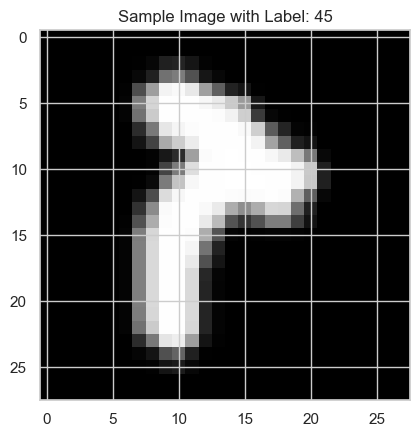

In [6]:
# Let's start by exploring the dataset's structure
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# We can also get a sample from the dataset to understand data format
image, label = train_dataset[0]

print(f"Image size: {list(image.size())}")
print(f"Sample label: {label}")

# Visualizing a sample image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Sample Image with Label: {label}")
plt.show()

**These results tell us that we're working with 112,800 samples in our training dataset and 18800 samples in our test dataset.

**The size of the image [1, 28, 28] tells us that we're dealing with 28 x 28 images in black and white, since there is only one pixel value at each of the 28 x 28 pixel positions. If the images were in an rgb format, the tensor would have a depth of 3 (or higher if working with alternative representations of images).

### Understanding our Mappings

In [7]:
def load_label_mapping(mapping_file):
    # Create a dictionary to hold the mapping from label to character
    label_char_mapping = {}

    # Open the mapping file
    with open(mapping_file, 'r') as file:
        for line in file:
            # Split the line into the label and its ASCII value
            label, ascii_val = line.strip().split()
            # Convert the label and ASCII value to integers
            label, ascii_val = int(label), int(ascii_val)
            # Map the label to the corresponding character
            label_char_mapping[label] = chr(ascii_val)

    return label_char_mapping

# Load the mapping
mapping_file_path = 'emnist-balanced-mapping.txt'
label_char_mapping = load_label_mapping(mapping_file_path)

# Example usage:
print(label_char_mapping)  # Prints the entire mapping

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


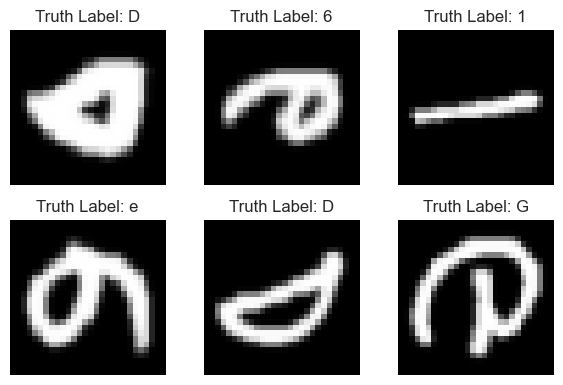

In [8]:
# We can then get a range of samples from the dataset to visualise the format that samples take.
# First set the random seed for reproducibility
torch.manual_seed(0)

# Then we choose 6 random indices from the training dataset
indices = torch.randint(len(train_dataset), size=(6,))

# We then create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(6, 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Get a sample from the dataset
    image, label = train_dataset[indices[i]]

    # Plot the image on the corresponding subplot
    ax.imshow(image.squeeze(), cmap='gray')

    # Set the title for the subplot
    ax.set_title(f"Truth Label: {label_char_mapping[int(label)]}")

    # Turn off axis to remove ticks and numbers
    ax.axis('off')

# Adjust the layout so titles and images don't overlap
plt.tight_layout()
plt.show()

## K-fold Cross Validation

**In order to experimentally explore the hyperparameter space for the neural networks that I will train as part of this assignment, I will implement k-fold cross validation. Because this is a classification task, we'll need to use stratified k-fold validation. This approach evenly distributes the samples of each class amongst each k-fold, thus enabling balanced cross validation.


In [9]:
# Convert PyTorch tensors to numpy arrays
features = train_dataset.tensors[0].numpy()
labels = train_dataset.tensors[1].numpy()


In [10]:
# Use scikit-learn's StratifiedKFold to define the stratified k-fold splitting strategy.
from sklearn.model_selection import StratifiedKFold

# Define the stratified k-fold parameters
n_splits = 5  # Number of folds
shuffle = True
random_state = 42

skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

In [11]:
# Split the dataset into folds. Each fold will be used once as a validation while the k - 1 remaining folds form the training set.
folds = skf.split(features, labels)

## Defining our training loop

**Throughout this project, we will use Cross Entropy Loss for our loss function, since this is a classification task and we essentially want to produce logits (raw output from the model) which we can map to a probability distribution of all possible classes (achieved using the softmax function).

**To make our code modular and reusable across all of our experiments with hyperparameters, we can define a custom function which trains and validates the model using the given data loaders, optimizer, and number of epochs.

In [29]:
from tqdm import tqdm


def train_and_validate_model(train_loader, val_loader, model, optimizer, epochs, device=device):
    """
    Trains and validates the model for a given train/val set, implements early stopping (default trigger - no improvement after 5 epochs).

    Parameters:
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - model: The neural network model to train.
    - optimizer: The optimizer to use for training.
    - epochs: Number of epochs to train for.
    - device: The device (CPU or GPU) to use for training and evaluation.

    Returns:
    - A tuple containing the average training loss, average validation loss, and average validation accuracy.
    """
    from torch import no_grad
    from torch.nn import functional as F
    
    model.to(device)
    # Track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Early stopping setup
    estop_tolerance = 5
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        # Training loop
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= estop_tolerance:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

    return train_losses, val_losses, val_accuracies


**We can also define a function to time our models

**Code taken from Daniel Bourke - learnpytorch

https://www.learnpytorch.io/03_pytorch_computer_vision/#32-creating-a-function-to-time-our-experiments

In [13]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


**We can then create a stratified_k_fold_cross_validation functon which takes a given training dataset, number of splits, model constructor, optimizer constructor and number of epochs as arguments.


In [14]:
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np

def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, optimizer_constructor, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer = optimizer_constructor(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, epochs, device
        )

         # End timing here
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)
        print(f"Using device: {device}")
        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}%\n")

    return fold_results


In [39]:
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Subset, TensorDataset

def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, optimizer_constructor, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    # Extract tensor data directly from the dataset
    features, labels = dataset.tensors[0], dataset.tensors[1]

    # Convert labels to numpy just for the purpose of creating folds
    labels_np = labels.numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels_np), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        model = model_constructor().to(device)
        optimizer = optimizer_constructor(model.parameters())

        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, epochs, device
        )

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        })

    return fold_results


**To use our cross validation training loop, we need to define model_constructor and optimizer_constructor functions so that we ensure that a new model and optimizer are created for each fold, preventing information leakage between folds by making sure that each fold starts with an untrained model.


In [15]:
def model_constructor():
    return model()  # Replace 'model' with the current model class

def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01) # Replace with the current optimiser


## Part 5 - MLPs & CNNs

### Multi Layered Perceptrons

#### Defining a baseline MLP

**Let's begin by defining a baseline MLP which we can use in our cross validation setup, to see how well it performs:

This four-layer MLP model is set up to handle complex data by working through several steps. It starts with a large input layer and condenses the data down through several hidden layers, using ReLU  to keep things non-linear. This helps it catch detailed patterns in the data. We also use dropout techniques, which randomly turn off some of the neurons during training. This trick helps the model avoid getting too fixated on specific details and makes it better at dealing with new, unseen data. At the end, all this information goes through an output layer that sorts everything into one of 47 different categories.

In the 4 layer model, each EMNIST image is flattened from a 28x28 grid into 784 inputs. The first hidden layer reduces these to 512 features, simplifying data while preserving essential patterns. Subsequent layers further narrow down features—512 to 256, then to 128—enhancing the model's focus on crucial attributes. This gradual reduction ensures efficient processing and culminates in an output layer that classifies the data into one of 47 character classes, effectively balancing complexity and accuracy.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class four_layerMLP(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, use_dropout=True, activation_fn=F.relu):
        super(four_layerMLP, self).__init__()
        # Save the activation function as an instance variable
        self.activation_fn = activation_fn
        
        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # Define the second hidden layer
        self.hidden2 = nn.Linear(512, 256)
        # Define the third hidden layer
        self.hidden3 = nn.Linear(256, 128)
        # Output layer (output size 47)
        self.output = nn.Linear(128, num_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()

    def forward(self, x):
        # Flatten the input data 
        x = x.view(x.size(0), -1)
        # Pass the input data through the first hidden layer
        x = self.activation_fn(self.hidden1(x))
        # Optionally apply dropout
        x = self.dropout(x)
        # Pass the data through the second hidden layer
        x = self.activation_fn(self.hidden2(x))
        # Optionally apply dropout
        x = self.dropout(x)
        # Pass the data through the third hidden layer
        x = self.activation_fn(self.hidden3(x))
        # apply dropout
        x = self.dropout(x)
        # Pass the data through the output layer
        x = self.output(x)
        return x

training the 4 layer model

In [17]:
# use model constructor function so that this specific model can be called by other function 
def model_constructor():
    return four_layerMLP(activation_fn = F.relu)
#define baseline optimizer
def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)
# pass the model through stratified_k_fold_cross_validation function 
four_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Your dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Train time on cuda: 52.782 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 70.31%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.45s/it]


Train time on cuda: 48.931 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 68.81%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


Train time on cuda: 47.570 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 69.02%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]


Train time on cuda: 45.530 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 70.37%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:43<00:00,  2.20s/it]

Train time on cuda: 43.949 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 69.84%



In the three-layer MLP model, we begin by transforming each image from a 28x28 pixel format into a flattened vector of 784 inputs. The model then processes this data through a sequence of reductions: the first hidden layer reduces the input from 784 to 512 features, and the second layer further reduces it to 256 features. These layers utilize ReLU activation to maintain non-linearity, helping the model to capture essential patterns from the data. The final layer, equipped with dropout to prevent overfitting, outputs the data into one of 47 categories, corresponding to different characters. This setup ensures efficient processing and accurate classification by progressively refining and focusing the input data through each layer.

In [18]:
import torch.nn.functional as F

# Define the MLP neural network class
class three_layerMLP(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, use_dropout=True, activation_fn=F.relu):
        super(three_layerMLP, self).__init__()
        self.activation_fn = activation_fn
        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # Define the second hidden layer
        self.hidden2 = nn.Linear(512, 256)
        # Define the third hidden layer
        self.output = nn.Linear(256, num_classes)
        # Dropout layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
    def forward(self, x):
        # Flatten the input data (if it's multidimensional)
        x = x.view(x.size(0), -1)
        # Pass the input data through the first hidden layer
        x = self.activation_fn(self.hidden1(x))
        # apply dropout
        x = self.dropout(x)
        # Pass the data through the second hidden layer
        x = self.activation_fn(self.hidden2(x))
        # Optionally apply dropout
        x = self.dropout(x)
        # Pass the data through the output layer
        x = self.output(x)
        return x

In [19]:
# use model constructor function so that this specific model can be called by other function 
def model_constructor():
    return three_layerMLP()
#define baseline optimizer
def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)
# pass the model through stratified_k_fold_cross_validation function 
three_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Your dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=10,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


Train time on cuda: 20.353 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 65.03%

Starting fold 2/5


Epochs: 100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Train time on cuda: 19.877 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 64.92%

Starting fold 3/5


Epochs: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


Train time on cuda: 20.700 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 64.47%

Starting fold 4/5


Epochs: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


Train time on cuda: 20.521 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 65.28%

Starting fold 5/5


Epochs: 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

Train time on cuda: 20.793 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 65.04%



In the two-layer MLP model, each 28x28 image is flattened to a 784-input vector that feeds into the first hidden layer. This layer compresses these inputs down to 512 features, using ReLU activation to introduce non-linearity and capture significant data patterns effectively. A dropout mechanism follows to mitigate overfitting by randomly omitting some neurons during training. The final step involves the output layer, which scales down the processed features to match the 47 distinct class outputs, representing various handwritten characters.

In [20]:
import torch.nn.functional as F

# Define the MLP neural network class
class two_layerMLP(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, use_dropout=True, activation_fn=F.relu):
        super(two_layerMLP, self).__init__()
        self.activation_fn = activation_fn
        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # Define the second hidden layer
        self.output = nn.Linear(512, num_classes)
        # Dropout layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
    def forward(self, x):
        # Flatten the input data
        x = x.view(x.size(0), -1)
        # Pass the input data through the first hidden layer
        x = self.activation_fn(self.hidden1(x))
        # apply dropout
        x = self.dropout(x)
        # Pass the data through the output layer
        x = self.output(x)
        return x

In [32]:
# use model constructor function so that this specific model can be called by other function 
def model_constructor():
    return two_layerMLP()
#define baseline optimizer
def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)
# pass the model through stratified_k_fold_cross_validation function 
two_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Your dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=10,
    device=device
    
)

cuda
Starting fold 1/5


Epochs: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


Train time on cuda: 20.152 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 66.41%

Starting fold 2/5


Epochs: 100%|██████████| 10/10 [00:19<00:00,  1.93s/it]


Train time on cuda: 19.347 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 65.38%

Starting fold 3/5


Epochs: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


Train time on cuda: 19.607 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 65.90%

Starting fold 4/5


Epochs: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


Train time on cuda: 19.375 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 65.83%

Starting fold 5/5


Epochs: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

Train time on cuda: 20.109 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 65.95%



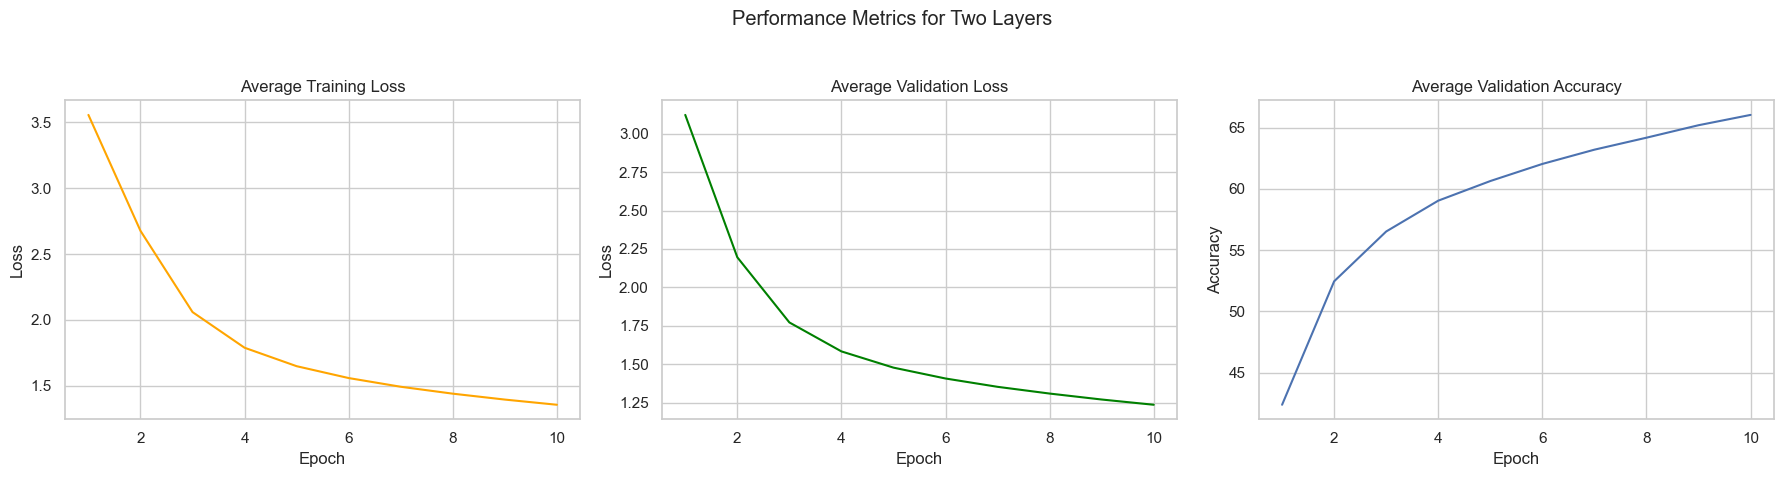

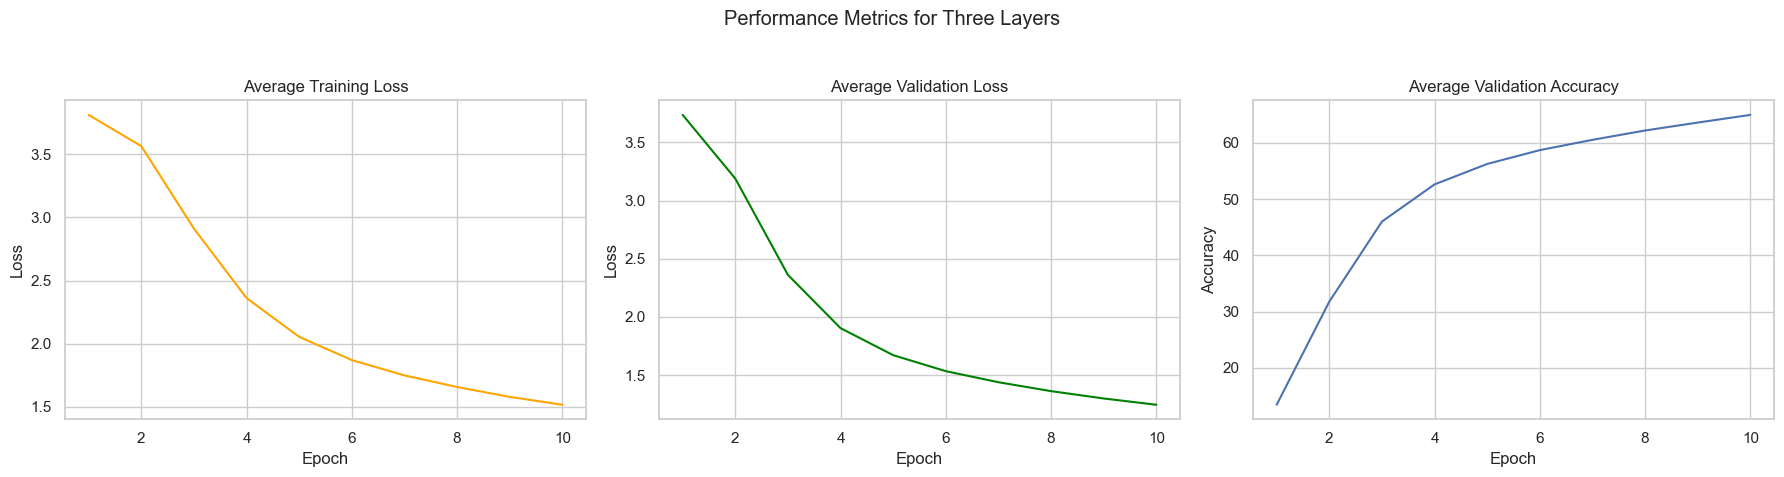

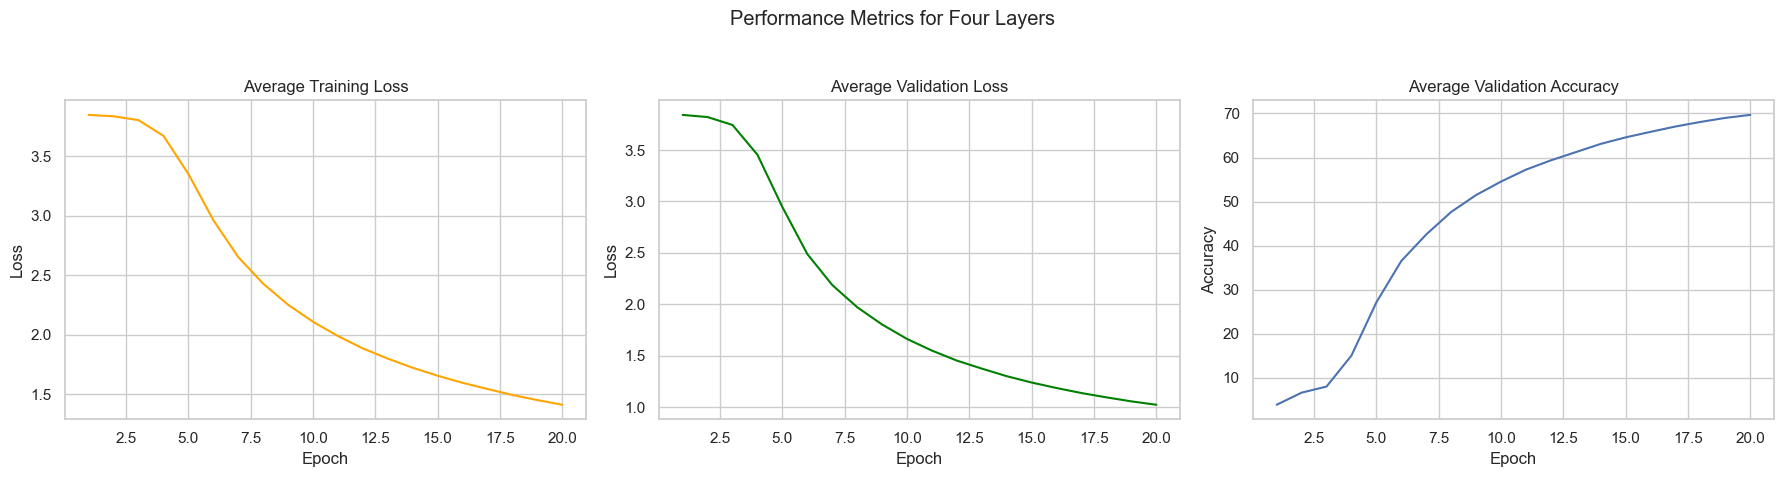

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# List of results for different numbers of layers
fold_results_list = [
    two_layer_fold_results,
    three_layer_fold_results,
    four_layer_fold_results
]

layer_names = ['Two Layers', 'Three Layers', 'Four Layers']

# Loop over each set of fold results
for fold_results, name in zip(fold_results_list, layer_names):
    # Calculating the average metrics
    avg_train_loss = np.mean([results['train_losses'] for results in fold_results], axis=0)
    avg_val_loss = np.mean([results['val_losses'] for results in fold_results], axis=0)
    avg_val_accuracy = np.mean([results['val_accuracies'] for results in fold_results], axis=0)

    epochs = range(1, len(avg_val_accuracy) + 1)

    # Plotting
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Performance Metrics for {name}')

    # Plot Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, avg_train_loss, label='Average Training Loss', color='orange')
    plt.title('Average Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, avg_val_loss, label='Average Validation Loss', color='green')
    plt.title('Average Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, avg_val_accuracy, label='Average Validation Accuracy')
    plt.title('Average Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()


### Cross Fold Plotting Function

To make the plotting process reusable for analyzing the results from your grid search or any set of fold results, you can encapsulate the plotting logic into a function. This function will take fold_results as an argument and plot the averaged metrics across all folds.

In [23]:
def plot_fold_results(fold_results, model_title):
    """
    Plots the average training loss, validation loss, and validation accuracy across all folds,
    and prints and returns the final averages along with the model title.

    Args:
    - fold_results (list): A list where each element is a dictionary containing the metrics
                           'train_losses', 'val_losses', and 'val_accuracies' for each fold.
    - model_title (str): Title of the model to include in prints and plots.

    Returns:
    - A dictionary containing the final 'average_train_loss', 'average_val_loss', and 'average_val_accuracy'
      along with the 'model_title'.
    """

    # Convert lists to DataFrames, handling variable lengths
    train_losses_df = pd.DataFrame([results['train_losses'] for results in fold_results]).T
    val_losses_df = pd.DataFrame([results['val_losses'] for results in fold_results]).T
    val_accuracies_df = pd.DataFrame([results['val_accuracies'] for results in fold_results]).T

    # Calculate the mean across columns (folds) for each metric
    avg_train_loss = train_losses_df.mean(axis=1)
    avg_val_loss = val_losses_df.mean(axis=1)
    avg_val_accuracy = val_accuracies_df.mean(axis=1)

    epochs = range(1, len(avg_val_accuracy) + 1)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(model_title)  # Set the overall figure title

    axs[0].plot(epochs, avg_train_loss, 'orange', label='Average Training Loss')
    axs[1].plot(epochs, avg_val_loss, 'green', label='Average Validation Loss')
    axs[2].plot(epochs, avg_val_accuracy, 'blue', label='Average Validation Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    axs[0].set_ylabel('Loss')
    axs[2].set_ylabel('Accuracy')
    axs[0].set_title('Training Loss')
    axs[1].set_title('Validation Loss')
    axs[2].set_title('Validation Accuracy')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the figure title

    plt.show()

     # After plotting, print or return the final averages
    final_avg_train_loss = avg_train_loss.dropna().iloc[-1]
    final_avg_val_loss = avg_val_loss.dropna().iloc[-1]
    final_avg_val_accuracy = avg_val_accuracy.dropna().iloc[-1]

    # Printing final averages
    print(f"{model_title} - Final Average Training Loss: {final_avg_train_loss:.3f}")
    print(f"{model_title} - Final Average Validation Loss: {final_avg_val_loss:.3f}")
    print(f"{model_title} - Final Average Validation Accuracy: {final_avg_val_accuracy:.2f}%")
    print("\n\n ################################ \n\n")

    # Return the final averages along with the model title
    return {
        'model_title': model_title,
        'final_average_train_loss': final_avg_train_loss,
        'final_average_val_loss': final_avg_val_loss,
        'final_average_val_accuracy': final_avg_val_accuracy
    }


In [34]:
# redefining model constructor as the best performing model
def model_constructor():
    return four_layerMLP(activation_fn = F.relu).to(device)

def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)



### Optimization Techniques - MLP

#### Learning Rates and Optimizers 

In [35]:
#create function to call SGD, adam and RMSprop optimizers
def sgd_optimizer(params, lr=0.01):
    return torch.optim.SGD(params, lr=lr)

def adam_optimizer(params, lr=0.001):
    return torch.optim.Adam(params, lr=lr)

def rmsprop_optimizer(params, lr=0.001):
    return torch.optim.RMSprop(params, lr=lr)


optimizers = {
    'RMSprop': rmsprop_optimizer,
    'SGD': sgd_optimizer,
    'Adam': adam_optimizer
}

In [36]:
# Define a set of learning rates to explore
learning_rates = [0.001, 0.01, 0.1]

In [37]:
def grid_search_optimizers_learning_rates(dataset, n_splits, model_constructor, optimizers, learning_rates, epochs, device):
    """
    Performs grid search over specified learning rates and optimizers, using stratified k-fold cross-validation.

    Parameters:
    - dataset: The dataset to use for training and validation.
    - n_splits: The number of folds for k-fold cross-validation.
    - model_constructor: Function to construct a new instance of the model.
    - optimizers: A dictionary of optimizers to explore.
    - learning_rates: A list of learning rates to explore.
    - epochs: The number of epochs to train for each fold.
    - device: The device to use for training (e.g., 'cuda' or 'cpu').

    Returns:
    - A dictionary with optimizer names and learning rates as keys and fold results as values.
    """
    all_results = {}

    for optimizer_name, optimizer_constructor in optimizers.items():
        for lr in learning_rates:
            print(f"Testing {optimizer_name} with learning rate: {lr}")

            # Define the optimizer constructor with the current learning rate
            def current_optimizer_constructor(params):
                return optimizer_constructor(params, lr=lr)

            # Perform stratified k-fold cross-validation
            fold_results = stratified_k_fold_cross_validation(
                dataset=dataset,
                n_splits=n_splits,
                model_constructor=model_constructor,
                optimizer_constructor=current_optimizer_constructor,
                epochs=epochs,
                device=device
            )

            # Store the results using a combined key
            key_name = f"{optimizer_name}_LR_{lr}"
            all_results[key_name] = fold_results

    return all_results


In [40]:
#call grid_search_optimizers_learning_rates and store results
grid_search_results = grid_search_optimizers_learning_rates(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizers=optimizers,
    learning_rates=learning_rates,
    epochs=20,
    device=device
)

Testing RMSprop with learning rate: 0.001
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:46<00:00,  2.33s/it]


Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:46<00:00,  2.33s/it]


Testing RMSprop with learning rate: 0.01
Starting fold 1/5


Epochs:  45%|████▌     | 9/20 [00:23<00:28,  2.59s/it]


Early stopping triggered after 10 epochs.
Starting fold 2/5


Epochs:  55%|█████▌    | 11/20 [00:27<00:22,  2.53s/it]


Early stopping triggered after 12 epochs.
Starting fold 3/5


Epochs:  45%|████▌     | 9/20 [00:23<00:28,  2.58s/it]


Early stopping triggered after 10 epochs.
Starting fold 4/5


Epochs:  45%|████▌     | 9/20 [00:23<00:28,  2.56s/it]


Early stopping triggered after 10 epochs.
Starting fold 5/5


Epochs:  45%|████▌     | 9/20 [00:22<00:27,  2.54s/it]


Early stopping triggered after 10 epochs.
Testing RMSprop with learning rate: 0.1
Starting fold 1/5


Epochs:  45%|████▌     | 9/20 [00:23<00:28,  2.61s/it]


Early stopping triggered after 10 epochs.
Starting fold 2/5


Epochs:  55%|█████▌    | 11/20 [00:28<00:23,  2.59s/it]


Early stopping triggered after 12 epochs.
Starting fold 3/5


Epochs:  25%|██▌       | 5/20 [00:15<00:47,  3.20s/it]


Early stopping triggered after 6 epochs.
Starting fold 4/5


Epochs:  40%|████      | 8/20 [00:23<00:34,  2.88s/it]


Early stopping triggered after 9 epochs.
Starting fold 5/5


Epochs:  45%|████▌     | 9/20 [00:23<00:29,  2.64s/it]


Early stopping triggered after 10 epochs.
Testing SGD with learning rate: 0.001
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


Testing SGD with learning rate: 0.01
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.45s/it]


Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


Testing SGD with learning rate: 0.1
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.50s/it]


Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Testing Adam with learning rate: 0.001
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:59<00:00,  2.98s/it]


Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


Testing Adam with learning rate: 0.01
Starting fold 1/5


Epochs:  65%|██████▌   | 13/20 [00:40<00:22,  3.15s/it]


Early stopping triggered after 14 epochs.
Starting fold 2/5


Epochs:  40%|████      | 8/20 [00:26<00:39,  3.28s/it]


Early stopping triggered after 9 epochs.
Starting fold 3/5


Epochs:  50%|█████     | 10/20 [00:32<00:32,  3.28s/it]


Early stopping triggered after 11 epochs.
Starting fold 4/5


Epochs:  70%|███████   | 14/20 [00:45<00:19,  3.22s/it]


Early stopping triggered after 15 epochs.
Starting fold 5/5


Epochs:  40%|████      | 8/20 [00:26<00:40,  3.34s/it]


Early stopping triggered after 9 epochs.
Testing Adam with learning rate: 0.1
Starting fold 1/5


Epochs:  30%|███       | 6/20 [00:20<00:48,  3.48s/it]


Early stopping triggered after 7 epochs.
Starting fold 2/5


Epochs:  50%|█████     | 10/20 [00:32<00:32,  3.29s/it]


Early stopping triggered after 11 epochs.
Starting fold 3/5


Epochs:  75%|███████▌  | 15/20 [00:47<00:15,  3.20s/it]


Early stopping triggered after 16 epochs.
Starting fold 4/5


Epochs:  40%|████      | 8/20 [00:27<00:41,  3.42s/it]


Early stopping triggered after 9 epochs.
Starting fold 5/5


Epochs:  40%|████      | 8/20 [00:26<00:40,  3.35s/it]

Early stopping triggered after 9 epochs.


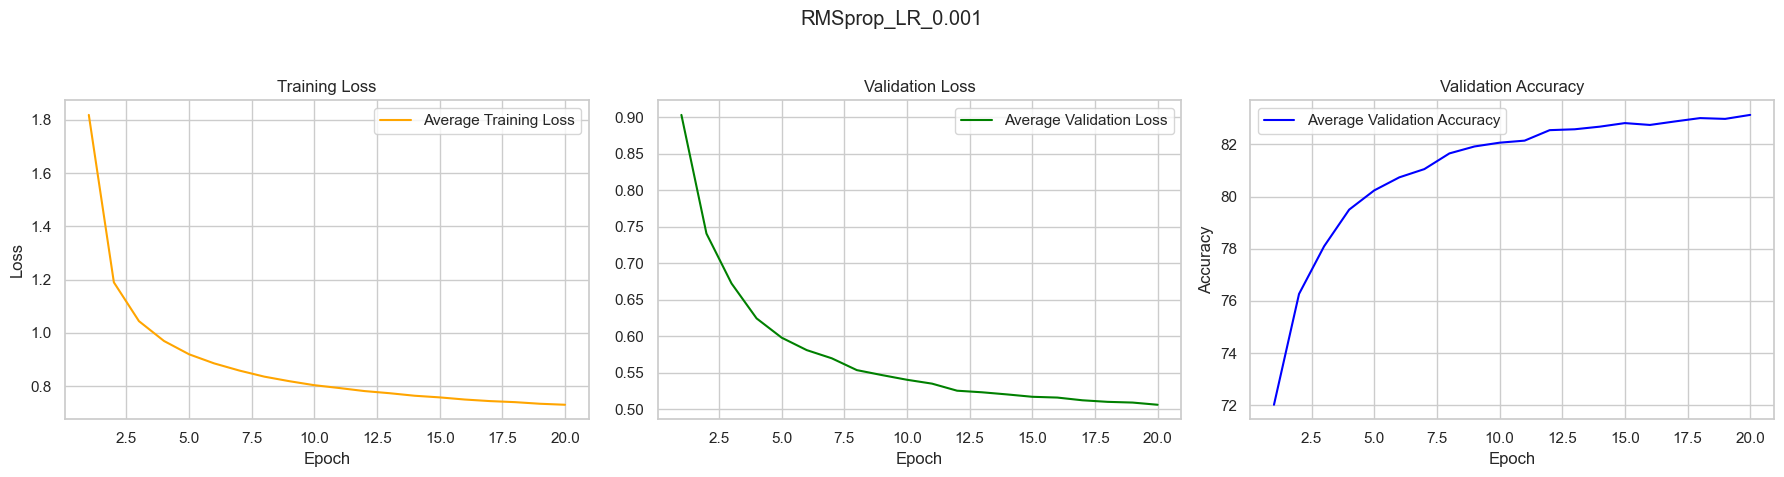

RMSprop_LR_0.001 - Final Average Training Loss: 0.731
RMSprop_LR_0.001 - Final Average Validation Loss: 0.506
RMSprop_LR_0.001 - Final Average Validation Accuracy: 83.13%


 ################################ 




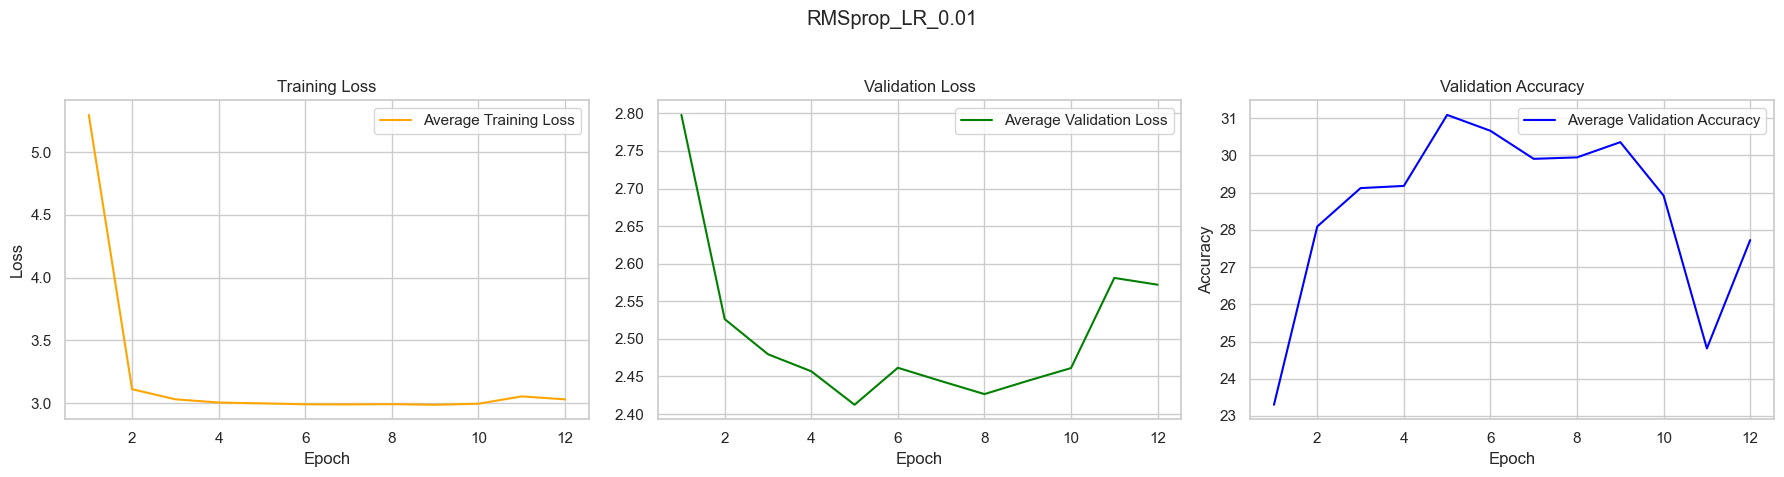

RMSprop_LR_0.01 - Final Average Training Loss: 3.029
RMSprop_LR_0.01 - Final Average Validation Loss: 2.572
RMSprop_LR_0.01 - Final Average Validation Accuracy: 27.73%


 ################################ 




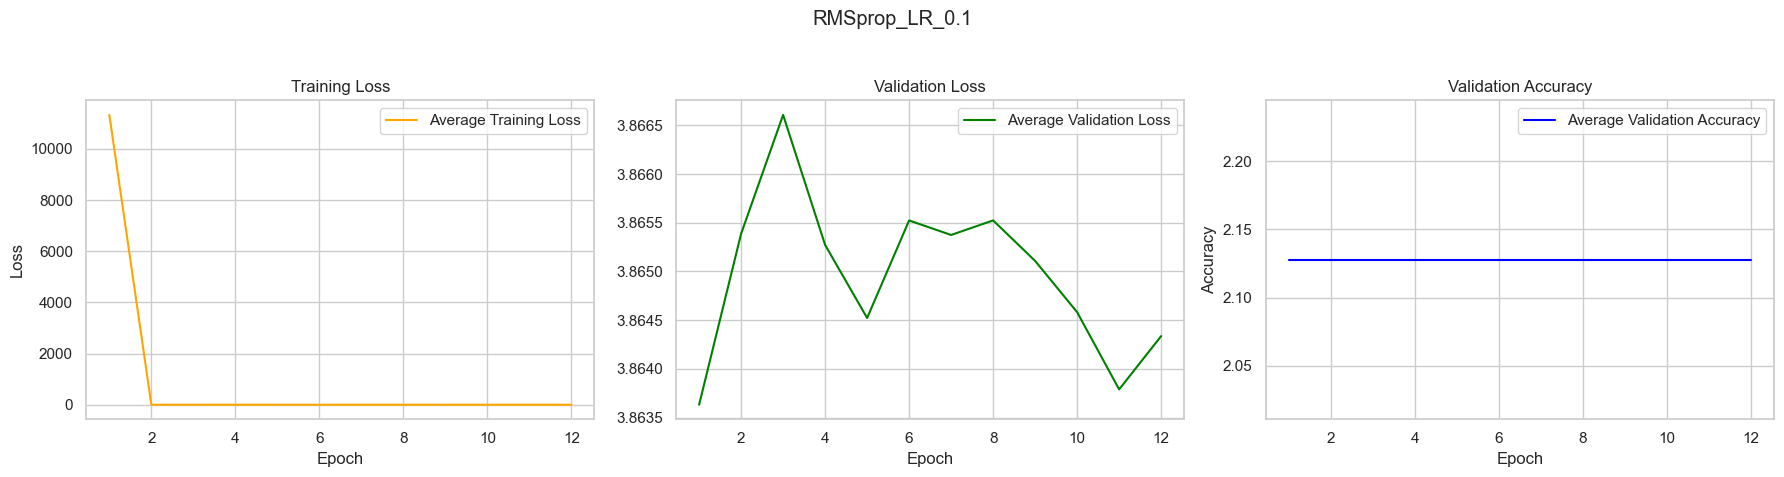

RMSprop_LR_0.1 - Final Average Training Loss: 3.891
RMSprop_LR_0.1 - Final Average Validation Loss: 3.864
RMSprop_LR_0.1 - Final Average Validation Accuracy: 2.13%


 ################################ 




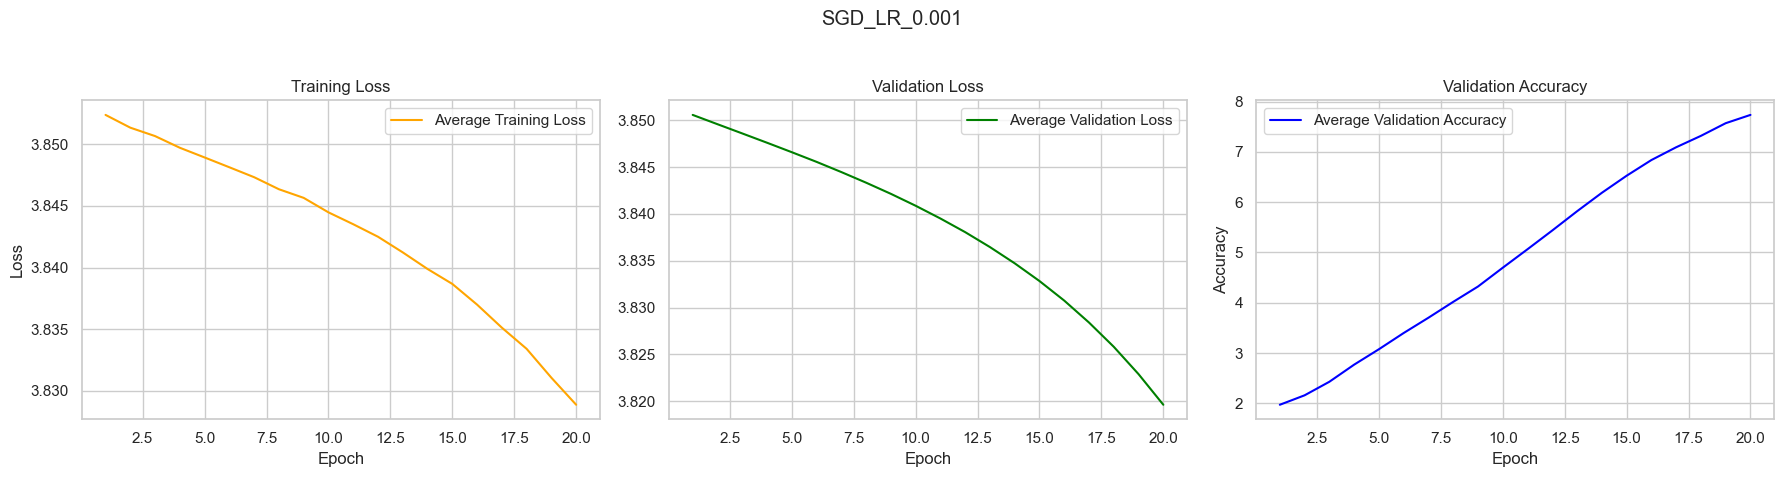

SGD_LR_0.001 - Final Average Training Loss: 3.829
SGD_LR_0.001 - Final Average Validation Loss: 3.820
SGD_LR_0.001 - Final Average Validation Accuracy: 7.74%


 ################################ 




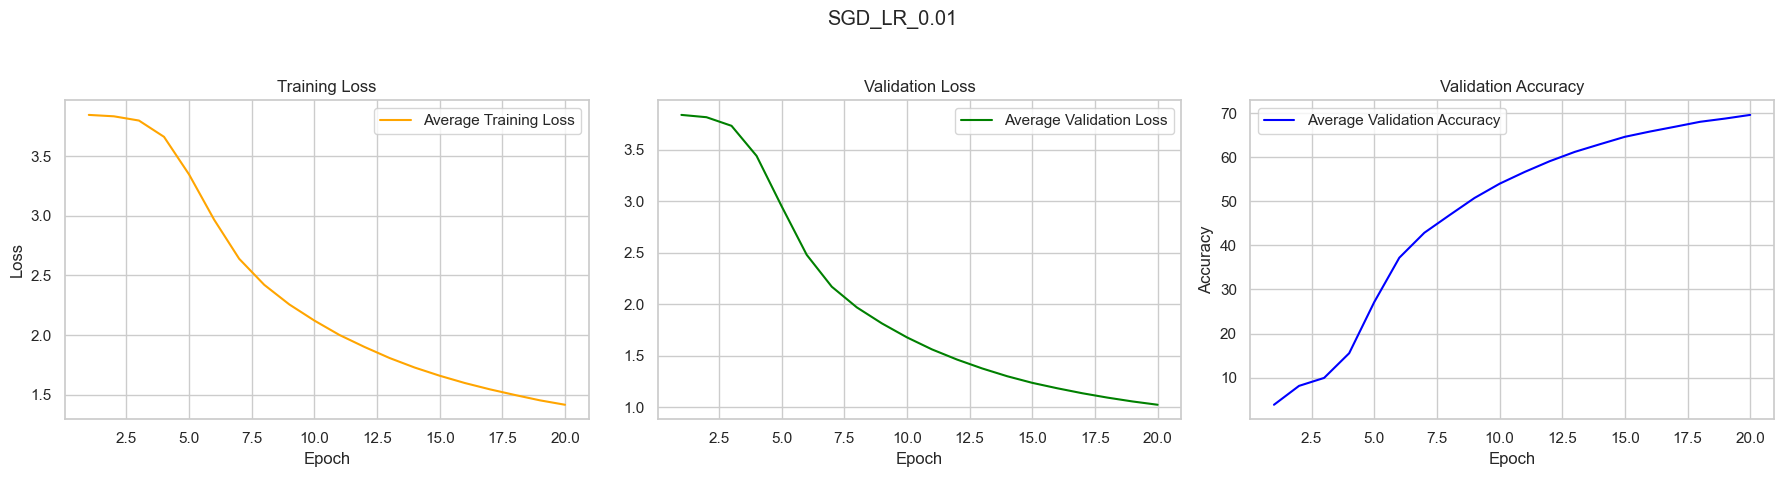

SGD_LR_0.01 - Final Average Training Loss: 1.414
SGD_LR_0.01 - Final Average Validation Loss: 1.024
SGD_LR_0.01 - Final Average Validation Accuracy: 69.63%


 ################################ 




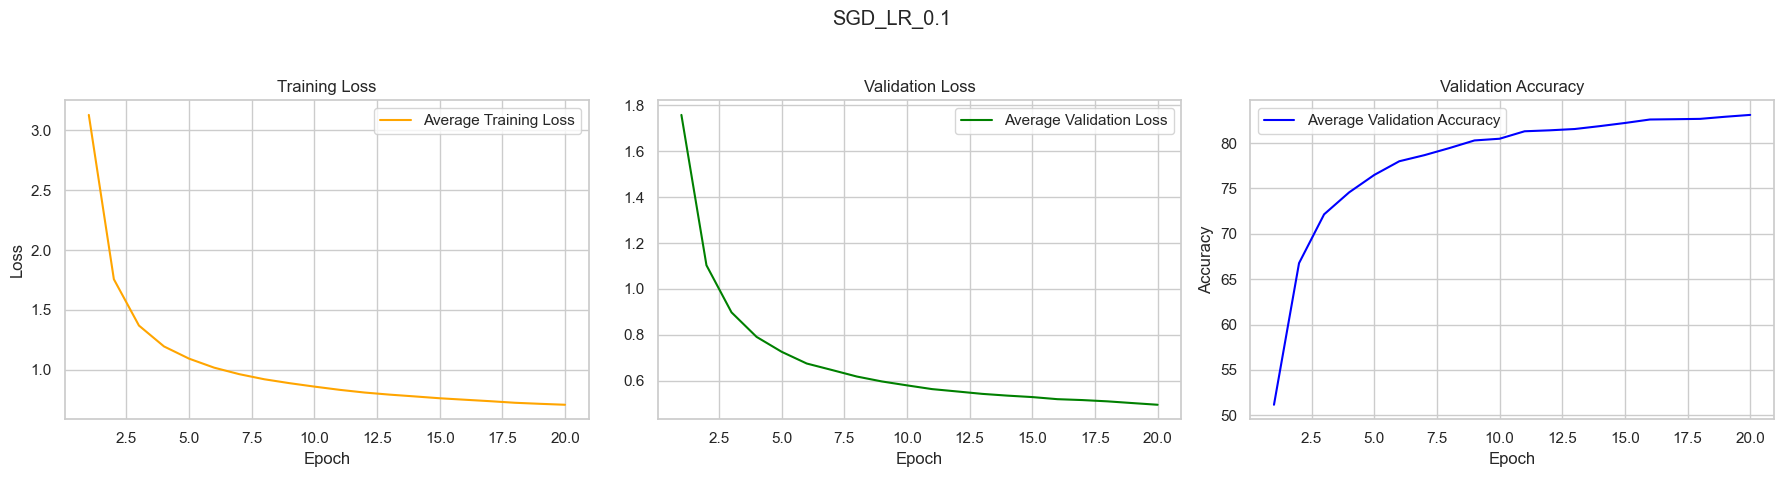

SGD_LR_0.1 - Final Average Training Loss: 0.708
SGD_LR_0.1 - Final Average Validation Loss: 0.496
SGD_LR_0.1 - Final Average Validation Accuracy: 83.10%


 ################################ 




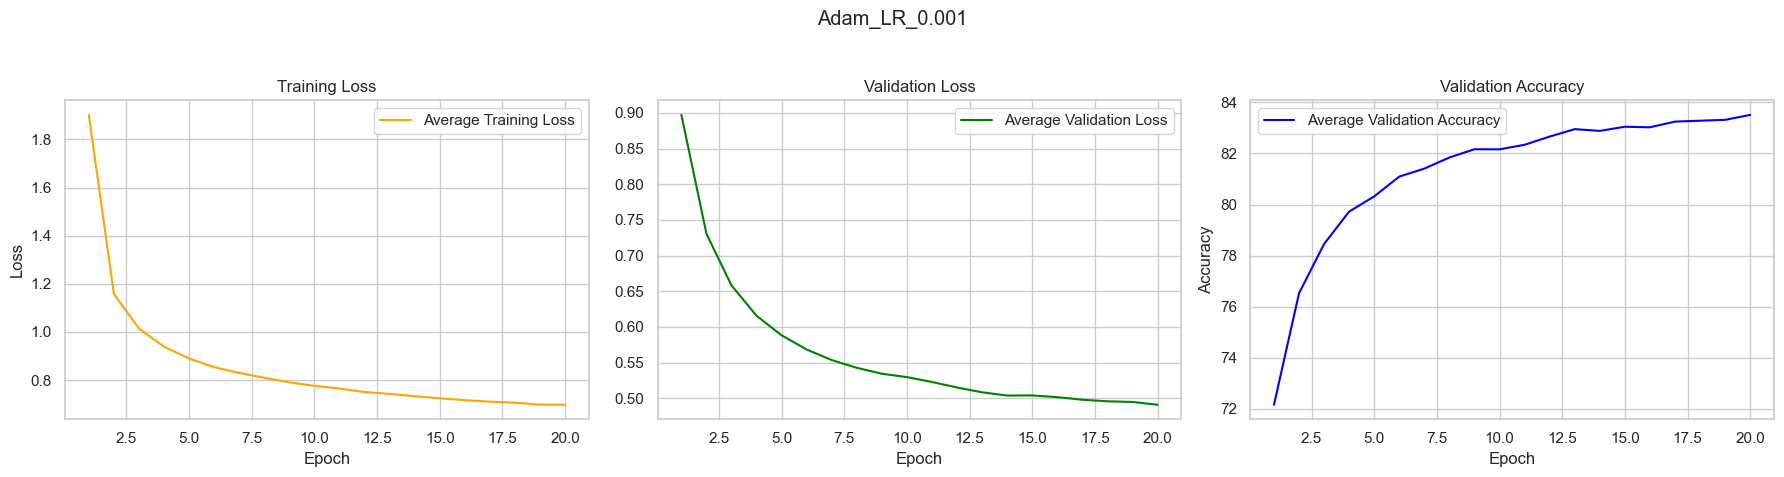

Adam_LR_0.001 - Final Average Training Loss: 0.698
Adam_LR_0.001 - Final Average Validation Loss: 0.491
Adam_LR_0.001 - Final Average Validation Accuracy: 83.51%


 ################################ 




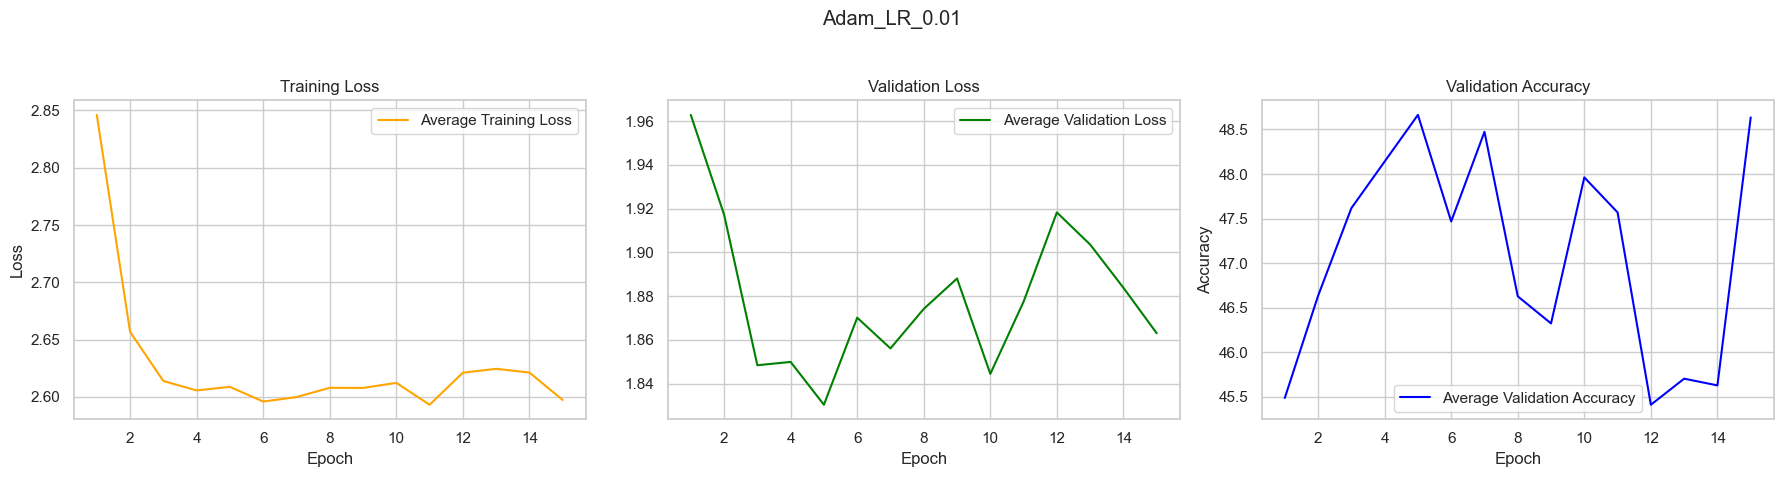

Adam_LR_0.01 - Final Average Training Loss: 2.597
Adam_LR_0.01 - Final Average Validation Loss: 1.863
Adam_LR_0.01 - Final Average Validation Accuracy: 48.63%


 ################################ 




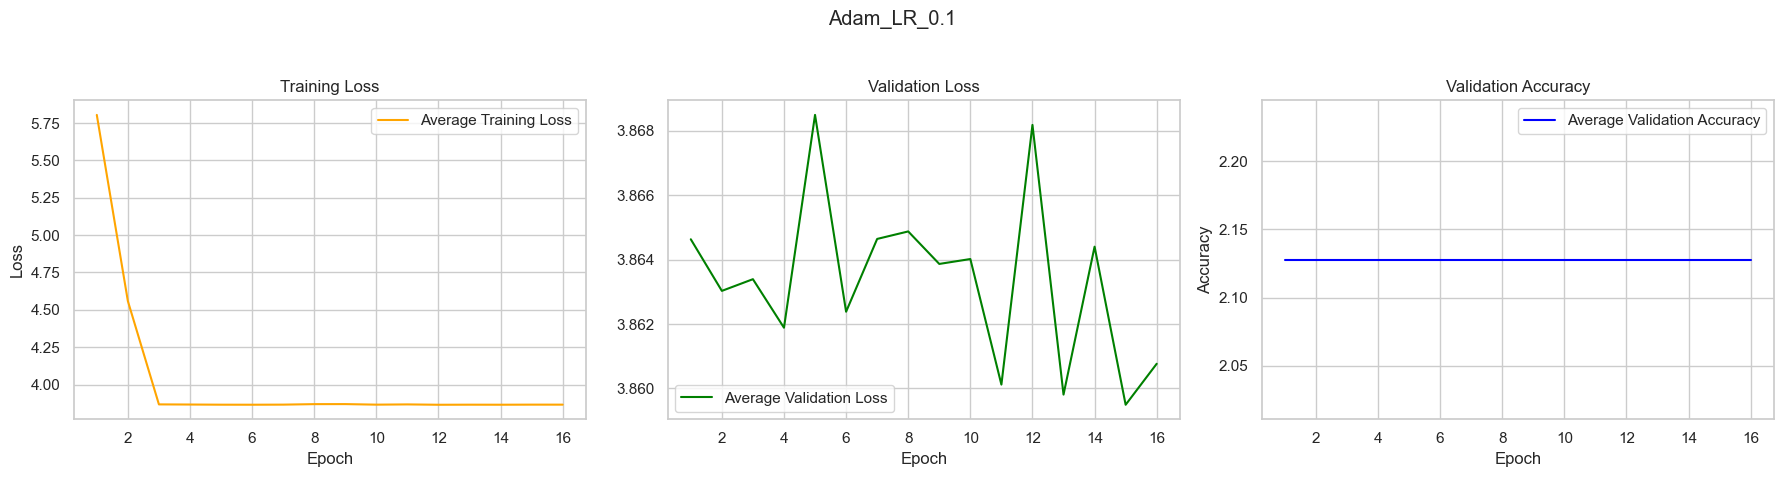

Adam_LR_0.1 - Final Average Training Loss: 3.865
Adam_LR_0.1 - Final Average Validation Loss: 3.861
Adam_LR_0.1 - Final Average Validation Accuracy: 2.13%


 ################################ 




In [41]:
# Let's initialise a list to hold a summary of the training results
results_summary_list = []

# We then loop through all combinations in grid_search_results
for combo_name, fold_results in grid_search_results.items():
    # Plot the results and capture the returned summary
    summary = plot_fold_results(fold_results, combo_name)

    # Add the summary to the list
    results_summary_list.append(summary)

In [42]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results_summary_list)

# Ensure 'final_average_val_accuracy' is numeric (it should be, but this is just in case)
results_df['final_average_val_accuracy'] = pd.to_numeric(results_df['final_average_val_accuracy'])

# Sort the DataFrame by 'final_average_val_accuracy' in ascending order
results_df_sorted = results_df.sort_values('final_average_val_accuracy', ascending=False)

# Display the sorted DataFrame
display(results_df_sorted)

model_title  final_average_train_loss  final_average_val_loss  \
6     Adam_LR_0.001                  0.697620                0.491039   
0  RMSprop_LR_0.001                  0.730508                0.506041   
5        SGD_LR_0.1                  0.708264                0.496271   
4       SGD_LR_0.01                  1.414337                1.023827   
7      Adam_LR_0.01                  2.597309                1.863027   
1   RMSprop_LR_0.01                  3.029303                2.572093   
3      SGD_LR_0.001                  3.828875                3.819607   
2    RMSprop_LR_0.1                  3.890791                3.864337   
8       Adam_LR_0.1                  3.865438                3.860767   

   final_average_val_accuracy  
6                   83.510638  
0                   83.129433  
5                   83.097518  
4                   69.633865  
7                   48.634752  
1                   27.726064  
3                    7.736702  
2                    2.127660  
8                    2.127660

**The 3 best combinations for our MLP model were:**

**Adam Optimizer with a Learning Rate of 0.001,
RMS Prop Optimizer with a Learning Rate of 0.001 and
SGD with a learning rate of 0.01.
Therefore, I will use each of these in my upcoming experiments.**


In [43]:
def adam_optimizer(params, lr=0.001):
    return torch.optim.Adam(params, lr=lr)

def rmsprop_optimizer(params, lr=0.001):
    return torch.optim.RMSprop(params, lr=lr)

# Define lr_scheduler constructors, given a Learning Rate.

def step_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def exponential_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)

# We can then combine optimizers with schedulers in a dictionary, which we can loop over (effectively performing grid search).
optimizer_scheduler_combinations = {
    'SGD_StepLR': (sgd_optimizer, step_lr_scheduler, {'lr': 0.01}),
    'SGD_ExponentialLR': (sgd_optimizer, exponential_lr_scheduler, {'lr': 0.01}),
    'Adam_StepLR': (adam_optimizer, step_lr_scheduler, {'lr': 0.001}),
    'Adam_ExponentialLR': (adam_optimizer, exponential_lr_scheduler, {'lr': 0.001}),
    'RMSprop_StepLR': (rmsprop_optimizer, step_lr_scheduler, {'lr': 0.001}),
    'RMSprop_ExponentialLR': (rmsprop_optimizer, exponential_lr_scheduler, {'lr': 0.001}),
}


In [174]:
def train_and_validate_model(train_loader, val_loader, model, optimizer, scheduler, epochs, device):
    from torch import no_grad
    from torch.nn import functional as F

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Update the learning rate after each epoch
        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

In [175]:
# We also need to modify our k-fold cross validation function:
def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - setup_optimizer_scheduler:
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device
        )

         # End timing here
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results


In [176]:
def grid_search_optimizers_schedulers(dataset, n_splits, model_constructor, optimizer_scheduler_combinations, epochs, device):
    all_results = {}

    for name, (optimizer_constructor, scheduler_constructor, optimizer_args) in optimizer_scheduler_combinations.items():
        print(f"Testing optimizer and scheduler combination: {name}\n")

        # Adjust the function to construct both optimizer and scheduler
        def optimizer_and_scheduler_constructor(params):
            optimizer = optimizer_constructor(params, **optimizer_args)
            scheduler = scheduler_constructor(optimizer)
            return optimizer, scheduler

        fold_results = stratified_k_fold_cross_validation(
            dataset=dataset,
            n_splits=n_splits,
            model_constructor=model_constructor,
            setup_optimizer_scheduler=optimizer_and_scheduler_constructor,
            epochs=epochs,
            device=device
        )

        all_results[name] = fold_results

    return all_results

In [49]:
print(device)

cuda


In [50]:
# call grid_search_optimizers_schedulers function and store results
optim_schedule_grid_search = grid_search_optimizers_schedulers(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizer_scheduler_combinations=optimizer_scheduler_combinations,
    epochs=20,
    device=device
)

Testing optimizer and scheduler combination: SGD_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


Fold 1 completed. Validation accuracy: 57.28%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.50s/it]


Fold 2 completed. Validation accuracy: 58.07%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


Fold 3 completed. Validation accuracy: 57.34%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]


Fold 4 completed. Validation accuracy: 56.88%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


Fold 5 completed. Validation accuracy: 55.33%

Testing optimizer and scheduler combination: SGD_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


Fold 1 completed. Validation accuracy: 6.03%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


Fold 2 completed. Validation accuracy: 6.77%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


Fold 3 completed. Validation accuracy: 3.98%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


Fold 4 completed. Validation accuracy: 5.68%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


Fold 5 completed. Validation accuracy: 6.75%

Testing optimizer and scheduler combination: Adam_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Fold 1 completed. Validation accuracy: 83.95%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


Fold 2 completed. Validation accuracy: 83.13%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


Fold 3 completed. Validation accuracy: 83.88%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


Fold 4 completed. Validation accuracy: 83.88%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


Fold 5 completed. Validation accuracy: 83.67%

Testing optimizer and scheduler combination: Adam_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:56<00:00,  2.84s/it]


Fold 1 completed. Validation accuracy: 76.17%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Fold 2 completed. Validation accuracy: 75.77%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Fold 3 completed. Validation accuracy: 74.93%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Fold 4 completed. Validation accuracy: 75.83%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Fold 5 completed. Validation accuracy: 76.24%

Testing optimizer and scheduler combination: RMSprop_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Fold 1 completed. Validation accuracy: 83.60%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


Fold 2 completed. Validation accuracy: 83.09%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Fold 3 completed. Validation accuracy: 83.38%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


Fold 4 completed. Validation accuracy: 83.44%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Fold 5 completed. Validation accuracy: 83.67%

Testing optimizer and scheduler combination: RMSprop_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Fold 1 completed. Validation accuracy: 75.48%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


Fold 2 completed. Validation accuracy: 75.66%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Fold 3 completed. Validation accuracy: 74.91%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Fold 4 completed. Validation accuracy: 75.32%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:47<00:00,  2.39s/it]

Fold 5 completed. Validation accuracy: 75.64%



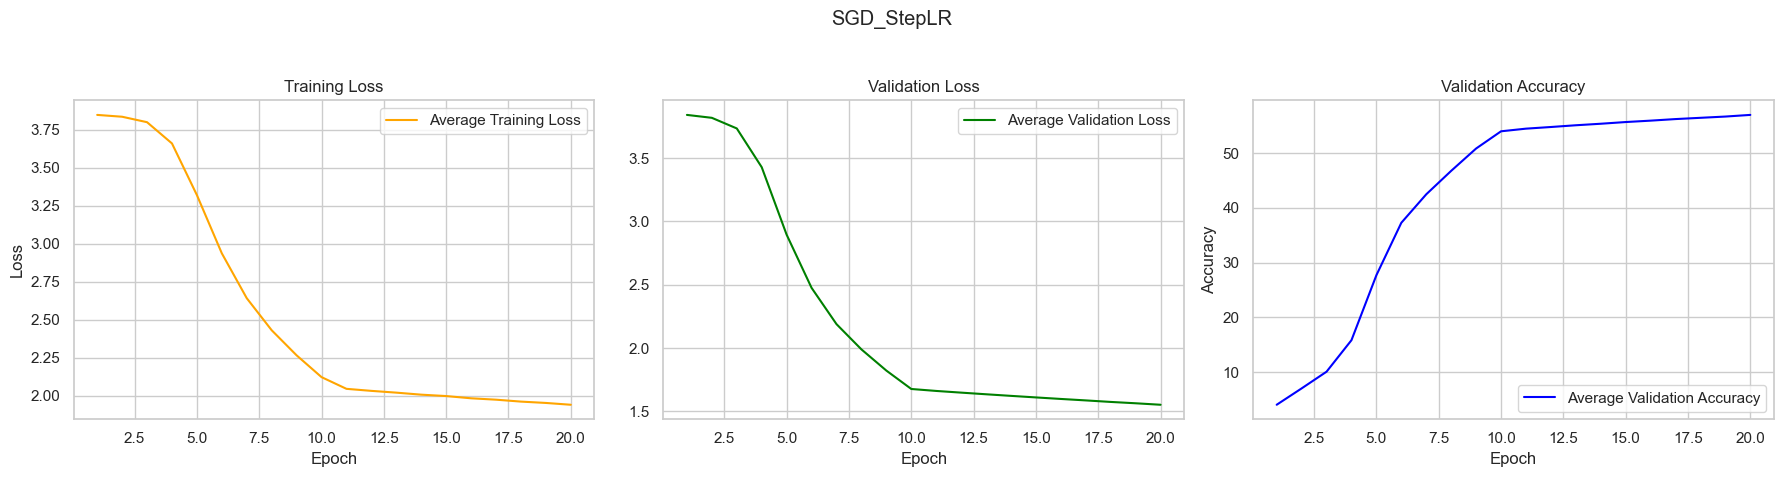

SGD_StepLR - Final Average Training Loss: 1.942
SGD_StepLR - Final Average Validation Loss: 1.552
SGD_StepLR - Final Average Validation Accuracy: 56.98%


 ################################ 




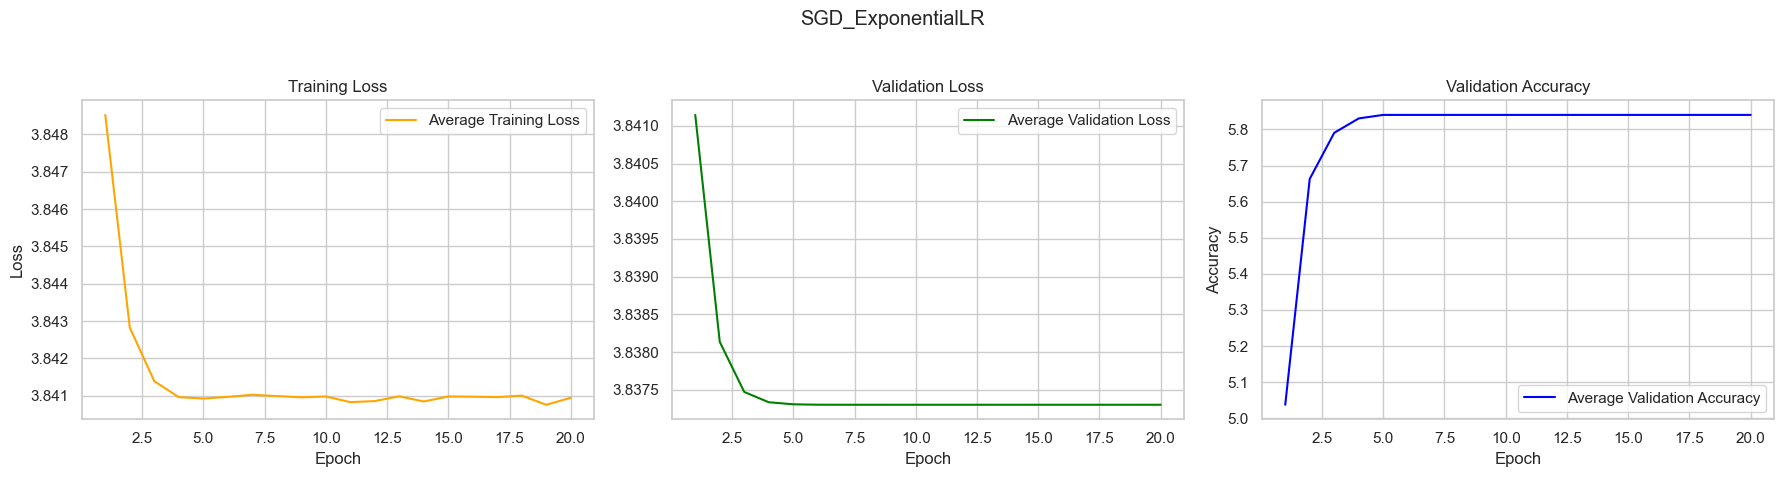

SGD_ExponentialLR - Final Average Training Loss: 3.841
SGD_ExponentialLR - Final Average Validation Loss: 3.837
SGD_ExponentialLR - Final Average Validation Accuracy: 5.84%


 ################################ 




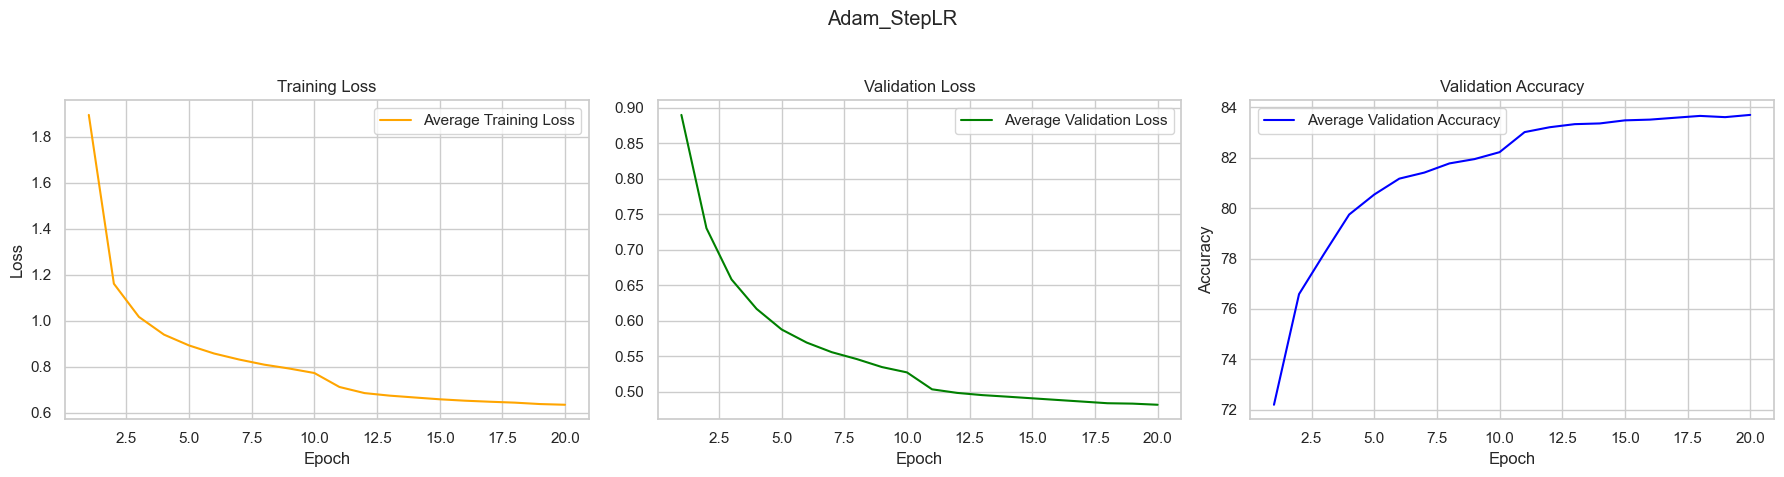

Adam_StepLR - Final Average Training Loss: 0.634
Adam_StepLR - Final Average Validation Loss: 0.482
Adam_StepLR - Final Average Validation Accuracy: 83.70%


 ################################ 




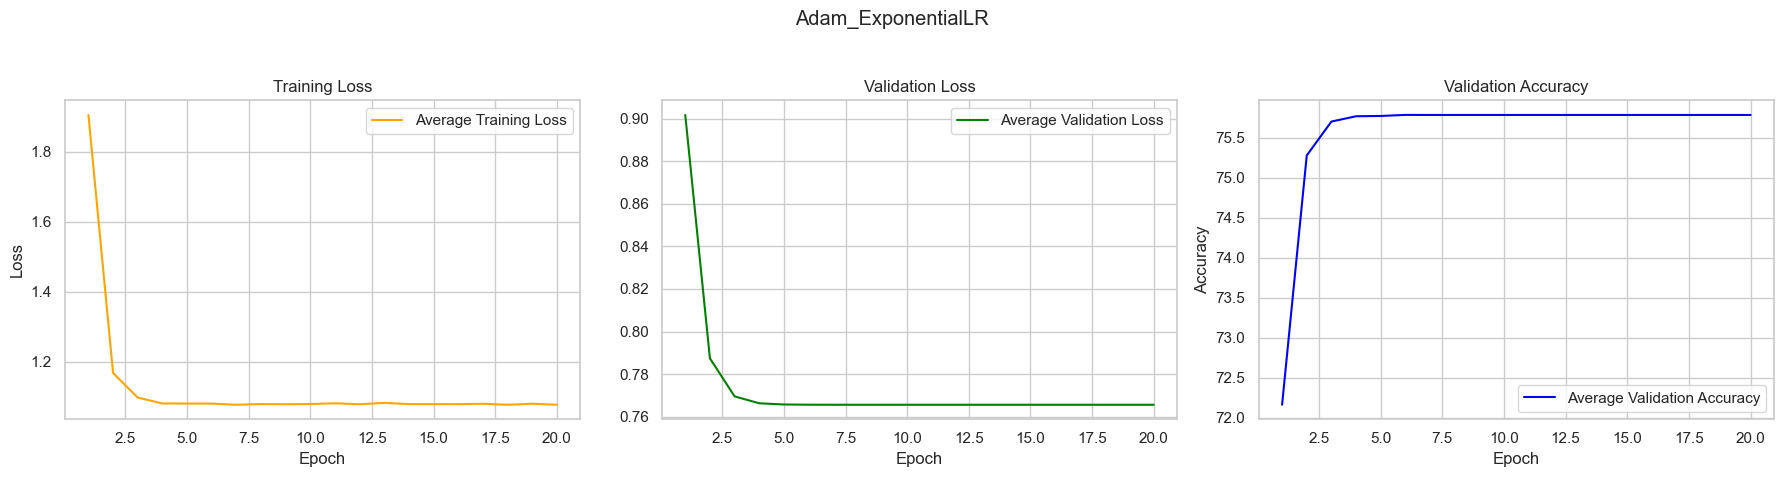

Adam_ExponentialLR - Final Average Training Loss: 1.076
Adam_ExponentialLR - Final Average Validation Loss: 0.766
Adam_ExponentialLR - Final Average Validation Accuracy: 75.79%


 ################################ 




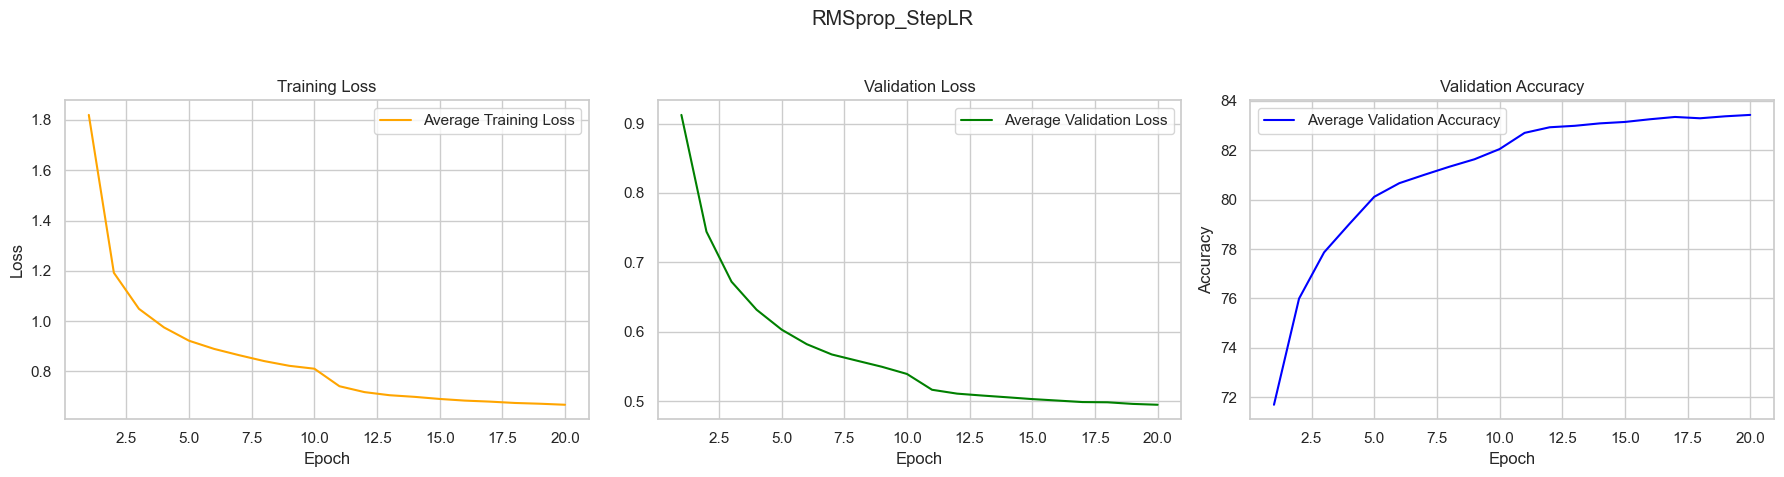

RMSprop_StepLR - Final Average Training Loss: 0.667
RMSprop_StepLR - Final Average Validation Loss: 0.495
RMSprop_StepLR - Final Average Validation Accuracy: 83.43%


 ################################ 




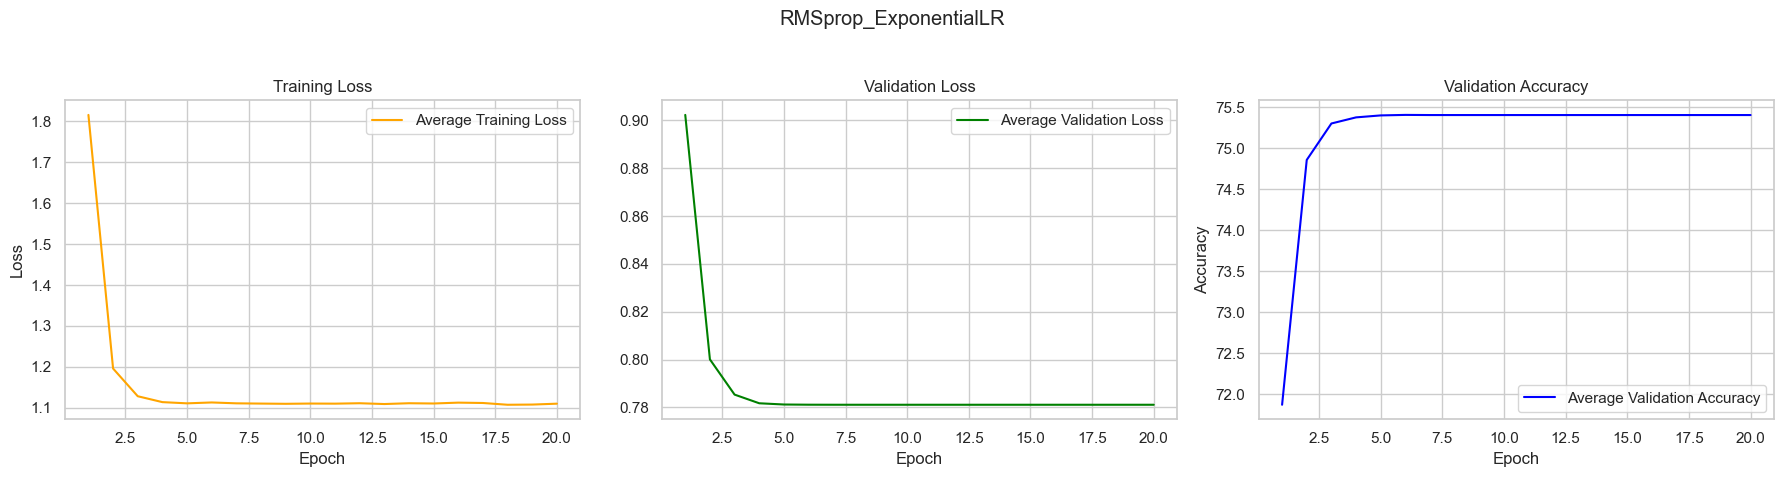

RMSprop_ExponentialLR - Final Average Training Loss: 1.110
RMSprop_ExponentialLR - Final Average Validation Loss: 0.781
RMSprop_ExponentialLR - Final Average Validation Accuracy: 75.40%


 ################################ 




In [51]:
# Let's initialise a new list to hold a summary of the training results
scheduler_results_summary_list = []

# We then loop through all combinations in grid_search_results
for combo_name, fold_results in optim_schedule_grid_search.items():
    # Plot the results and capture the returned summary
    summary = plot_fold_results(fold_results, combo_name)

    # Add the summary to the list
    scheduler_results_summary_list.append(summary)


In [52]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
scheduler_results_df = pd.DataFrame(scheduler_results_summary_list)

# Ensure 'final_average_val_accuracy' is numeric (it should be, but this is just in case)
scheduler_results_df['final_average_val_accuracy'] = pd.to_numeric(scheduler_results_df['final_average_val_accuracy'])

# Sort the DataFrame by 'final_average_val_accuracy' in ascending order
scheduler_results_df_sorted = scheduler_results_df.sort_values('final_average_val_accuracy', ascending=False)

# Display the sorted DataFrame
display(scheduler_results_df_sorted)

model_title  final_average_train_loss  final_average_val_loss  \
2            Adam_StepLR                  0.634029                0.481529   
4         RMSprop_StepLR                  0.666819                0.495036   
3     Adam_ExponentialLR                  1.076470                0.765616   
5  RMSprop_ExponentialLR                  1.109828                0.781100   
0             SGD_StepLR                  1.941746                1.552361   
1      SGD_ExponentialLR                  3.840945                3.837300   

   final_average_val_accuracy  
2                   83.703901  
4                   83.434397  
3                   75.788121  
5                   75.403369  
0                   56.977837  
1                    5.840426

as shown, the ADAM optimizer, using the stepLR scheduler returns the highest validation accuracy, and will therefore be considered our current best model and will be to test other hyperparameters

### activation functions 

In [177]:
import torch.nn.functional as F
# define activation functions
activation_functions = {
    'ReLU': F.relu,
    'LeakyReLU': F.leaky_relu,
    'ELU': F.elu
}

In [54]:
# model constructor returns the four_layer mlp model, but leaves activation function equal to itself so all activation functions 
#can be tested
def get_model_constructor(activation_fn):
    def model_constructor():
        return four_layerMLP(activation_fn=activation_fn)
    return model_constructor


Running cross-validation with ReLU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:51<00:00,  2.60s/it]


Fold 1 completed. Validation accuracy: 83.98%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


Fold 2 completed. Validation accuracy: 83.14%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


Fold 3 completed. Validation accuracy: 83.70%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


Fold 4 completed. Validation accuracy: 83.89%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


Fold 5 completed. Validation accuracy: 83.75%



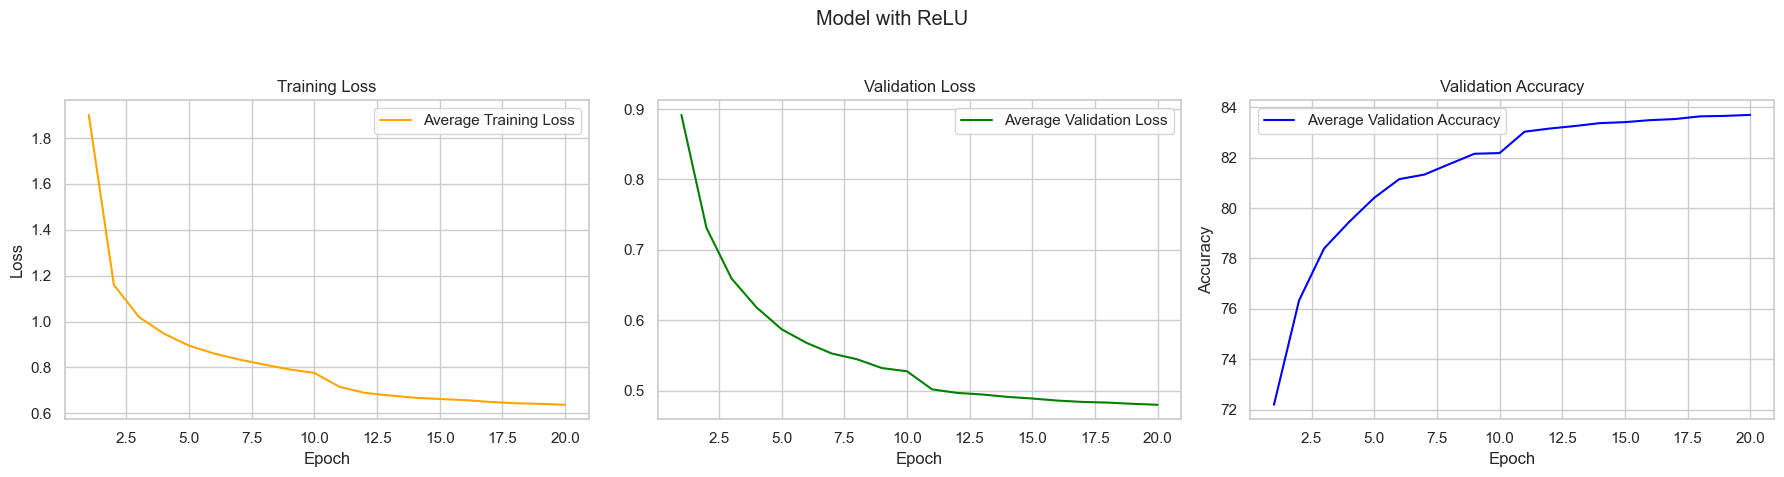

Model with ReLU - Final Average Training Loss: 0.638
Model with ReLU - Final Average Validation Loss: 0.480
Model with ReLU - Final Average Validation Accuracy: 83.69%


 ################################ 


Running cross-validation with LeakyReLU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


Fold 1 completed. Validation accuracy: 84.22%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


Fold 2 completed. Validation accuracy: 83.42%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Fold 3 completed. Validation accuracy: 83.92%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Fold 4 completed. Validation accuracy: 83.89%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Fold 5 completed. Validation accuracy: 83.98%



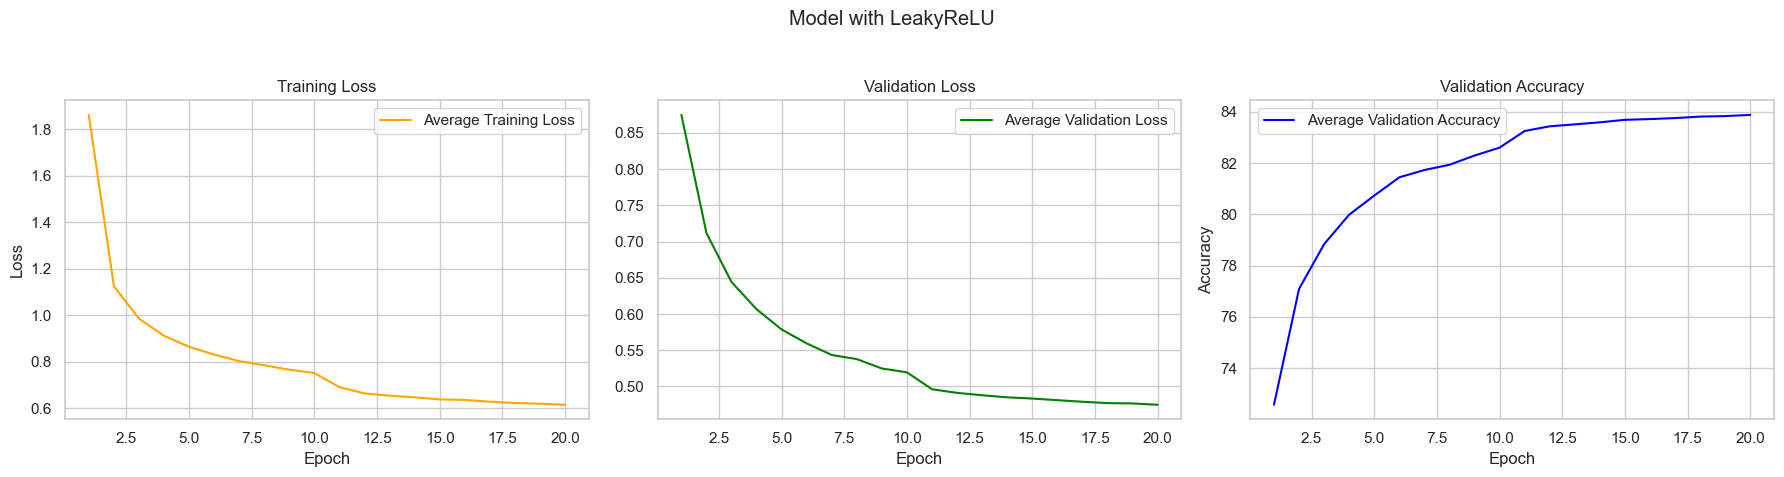

Model with LeakyReLU - Final Average Training Loss: 0.615
Model with LeakyReLU - Final Average Validation Loss: 0.475
Model with LeakyReLU - Final Average Validation Accuracy: 83.88%


 ################################ 


Running cross-validation with ELU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


Fold 1 completed. Validation accuracy: 83.90%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


Fold 2 completed. Validation accuracy: 83.23%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Fold 3 completed. Validation accuracy: 83.68%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.55s/it]


Fold 4 completed. Validation accuracy: 84.12%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


Fold 5 completed. Validation accuracy: 84.11%



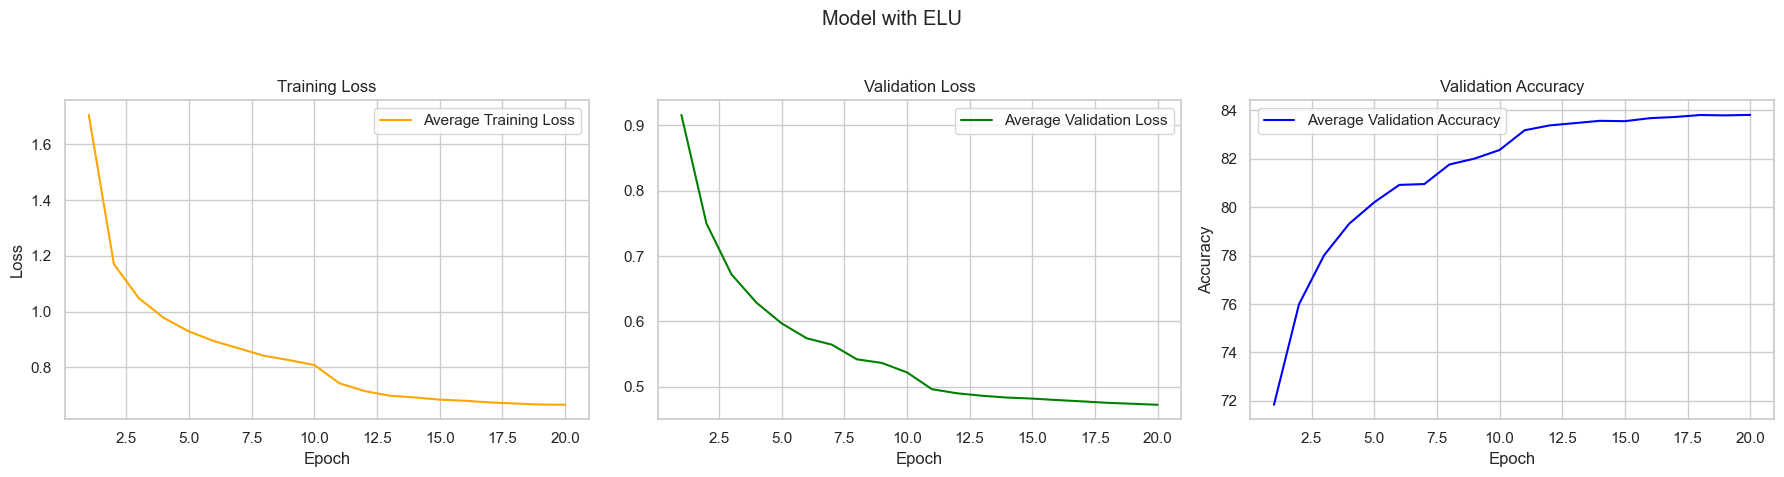

Model with ELU - Final Average Training Loss: 0.666
Model with ELU - Final Average Validation Loss: 0.473
Model with ELU - Final Average Validation Accuracy: 83.81%


 ################################ 




In [56]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001)  # Best optimizer from previous experiment.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

activation_metrics_list = []

for activation_name, activation_fn in activation_functions.items():
    print(f"Running cross-validation with {activation_name} activation function.")

    # Get a model constructor for the current activation function
    model_constructor = get_model_constructor(activation_fn)

    # Perform stratified k-fold cross-validation
    fold_results = stratified_k_fold_cross_validation(
        dataset=train_dataset,
        n_splits=5,
        model_constructor=model_constructor,
        setup_optimizer_scheduler=setup_optimizer_scheduler,
        epochs=20,
        device=device
    )

    # Plot the results
    plot_fold_results(fold_results, f"Model with {activation_name}")

    # Calculate summary statistics
    avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
    avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
    avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

    # Append metrics to metrics list
    activation_metrics_list.append({
        'Activation Function': activation_name,
        'Average Final Training Loss': avg_final_train_loss,
        'Average Final Validation Loss': avg_final_val_loss,
        'Average Final Validation Accuracy': avg_final_val_accuracy
    })


In [57]:
# Convert the list of dictionaries to a DataFrame
activation_metrics_df = pd.DataFrame(activation_metrics_list)

# Sort the DataFrame by 'Average Final Validation Accuracy'
sorted_activation_metrics_df = activation_metrics_df.sort_values('Average Final Validation Accuracy', ascending=False)

# Display the sorted DataFrame
display(sorted_activation_metrics_df)

Activation Function  Average Final Training Loss  \
1           LeakyReLU                     0.614579   
2                 ELU                     0.665510   
0                ReLU                     0.637594   

   Average Final Validation Loss  Average Final Validation Accuracy  
1                       0.474728                          83.883865  
2                       0.472651                          83.806738  
0                       0.479736                          83.693262

The results show that the LeakyReLU activation function performs the best, and is incorporated into our model

### batch normalisation 

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class four_layer_BN_MLP(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, use_dropout=True, activation_fn=F.relu):
        super(four_layer_BN_MLP, self).__init__()
        # Save the activation function as an instance variable
        self.activation_fn = activation_fn
        
        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # Optional Batch Normalization layer after the first hidden layer
        if use_bn:
            self.bn1 = nn.BatchNorm1d(512)
        
        # Define the second hidden layer
        self.hidden2 = nn.Linear(512, 256)
        # Optional Batch Normalization layer after the second hidden layer
        if use_bn:
            self.bn2 = nn.BatchNorm1d(256)
        
        # Define the third hidden layer
        self.hidden3 = nn.Linear(256, 128)
        # Optional Batch Normalization layer after the third hidden layer
        if use_bn:
            self.bn3 = nn.BatchNorm1d(128)
        
        # Output layer (output size 47)
        self.output = nn.Linear(128, num_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()

    def forward(self, x):
        # Flatten the input data (if it's multidimensional)
        x = x.view(x.size(0), -1)
        
        # Pass the input data through the first hidden layer, optionally apply BN, followed by the activation function
        x = self.hidden1(x)
        if hasattr(self, 'bn1'):
            x = self.bn1(x)
        x = self.activation_fn(x)
        # Optionally apply dropout
        x = self.dropout(x)
        
        # Pass the data through the second hidden layer, optionally apply BN, followed by the activation function
        x = self.hidden2(x)
        if hasattr(self, 'bn2'):
            x = self.bn2(x)
        x = self.activation_fn(x)
        # Optionally apply dropout
        x = self.dropout(x)
        
        # Pass the data through the third hidden layer, optionally apply BN, followed by the activation function
        x = self.hidden3(x)
        if hasattr(self, 'bn3'):
            x = self.bn3(x)
        x = self.activation_fn(x)
        # Optionally apply dropout
        x = self.dropout(x)
        
        # Pass the data through the output layer
        x = self.output(x)
        return x

In [68]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return four_layer_BN_MLP(use_bn = True,activation_fn= F.leaky_relu) #best performing activation function
    return model_constructor

Running cross-validation with Batch normalisation on current best model
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


Fold 1 completed. Validation accuracy: 84.56%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


Fold 2 completed. Validation accuracy: 84.27%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.95s/it]


Fold 3 completed. Validation accuracy: 84.22%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


Fold 4 completed. Validation accuracy: 84.53%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


Fold 5 completed. Validation accuracy: 84.64%



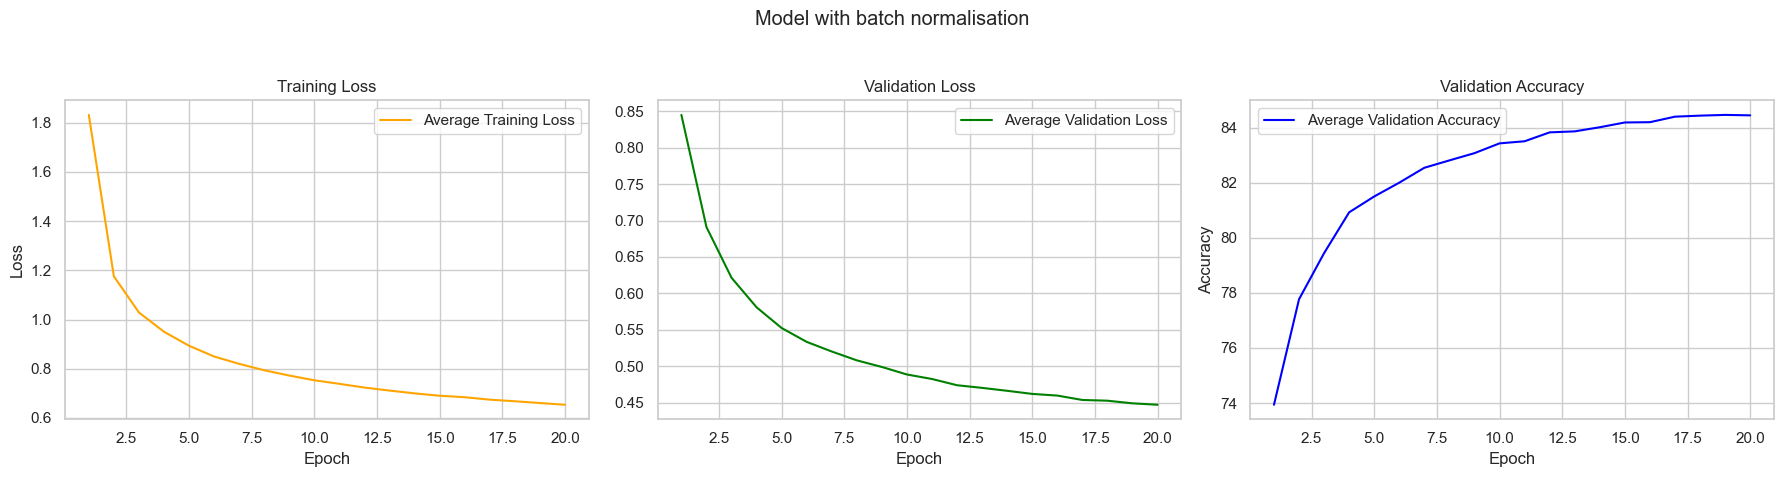

Model with batch normalisation - Final Average Training Loss: 0.654
Model with batch normalisation - Final Average Validation Loss: 0.447
Model with batch normalisation - Final Average Validation Accuracy: 84.44%


 ################################ 




In [69]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001)  # Best optimizer from previous experiment.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

BN_metrics_list = []


print(f"Running cross-validation with Batch normalisation on current best model")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with batch normalisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
BN_metrics_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

In [ ]:
#we find good results with batch norm

In [ ]:
#L1 & L2 regularisation 

In [ ]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return four_layer_BN_MLP(use_bn = True,activation_fn= F.leaky_relu) #best performing activation function
    return model_constructor

Running cross-validation with best model using L2 regularisation
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


Fold 1 completed. Validation accuracy: 84.95%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


Fold 2 completed. Validation accuracy: 83.95%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:00<00:00,  3.05s/it]


Fold 3 completed. Validation accuracy: 84.68%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.15s/it]


Fold 4 completed. Validation accuracy: 84.38%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


Fold 5 completed. Validation accuracy: 84.90%



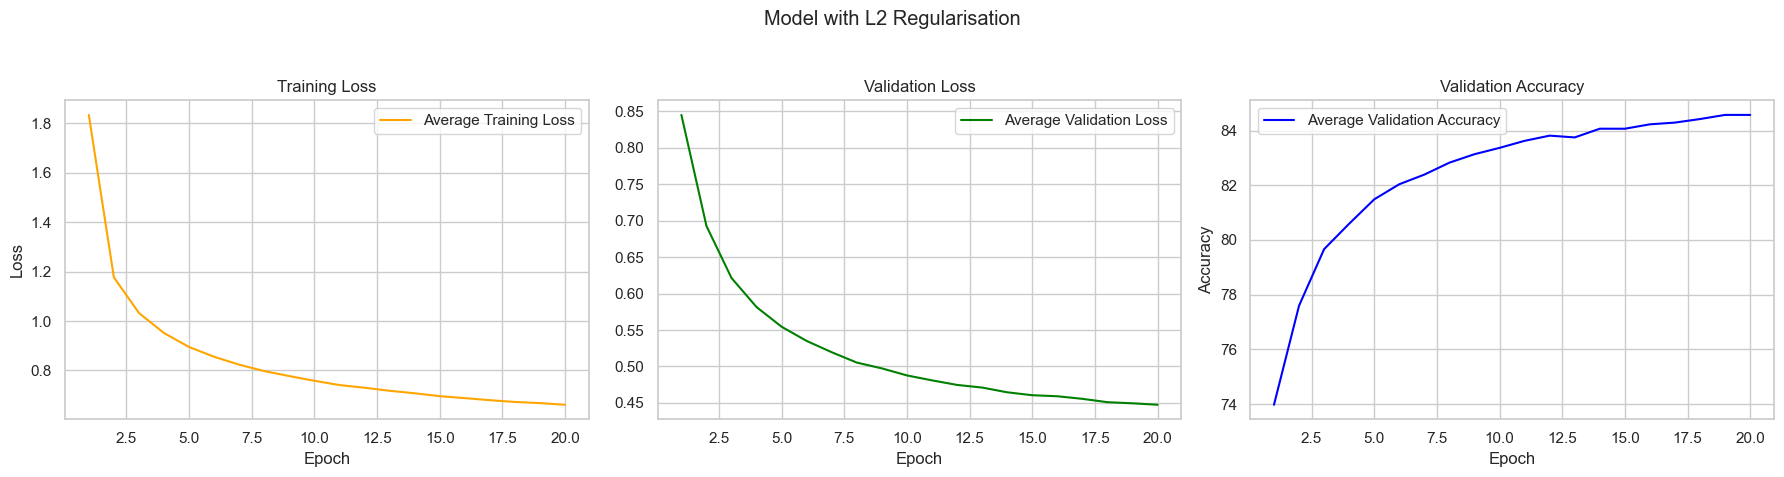

Model with L2 Regularisation - Final Average Training Loss: 0.661
Model with L2 Regularisation - Final Average Validation Loss: 0.447
Model with L2 Regularisation - Final Average Validation Accuracy: 84.57%


 ################################ 




In [71]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=1e-5)  # implementing l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []


print(f"Running cross-validation with best model using L2 regularisation")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with L2 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

In [ ]:
#slightly better results with L2 Regularisation

In [ ]:
#L1 Regularisation

In [83]:
from tqdm import tqdm
import torch
from torch import no_grad
from torch.nn import functional as F

def train_and_validate_model_with_l1(train_loader, val_loader, model, optimizer, scheduler, epochs, device, lambda_l1):
    """
    Trains and validates the model using the given data loaders, optimizer, scheduler, and number of epochs, including L1 regularization.
    
    Parameters:
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - model: The neural network model to train.
    - optimizer: The optimizer to use for training.
    - scheduler: The scheduler to use for training.
    - epochs: Number of epochs to train for.
    - device: The device (CPU or GPU) to use for training and evaluation.
    - lambda_l1: L1 regularization strength.
    
    Returns:
    - A tuple containing the average training loss, average validation loss, and average validation accuracy.
    """
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)

            # Compute the L1 loss (regularization) term
            l1_norm = sum(p.abs().sum() for p in model.parameters())

            # Combine the cross-entropy loss and L1 regularization
            loss += lambda_l1 * l1_norm

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = F.cross_entropy(y_pred, y)

                val_loss += loss.item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

In [84]:
def stratified_k_fold_cross_validation_with_l1(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device, l1):
    """
    Performs stratified k-fold cross-validation for the given dataset, model, and includes L1 regularization.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - setup_optimizer_scheduler: Function that takes a model's parameters and returns a tuple of optimizer and scheduler.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    - l1: L1 regularization strength.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Timer start
        fold_start_time = timer()

        # Splitting the dataset into training and validation subsets for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer, and scheduler for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model)

        # Training and validating the model with L1 regularization
        train_losses, val_losses, val_accuracies = train_and_validate_model_with_l1(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device, l1
        )

        # Timer end
        fold_end_time = timer()

        # Calculating fold training time
        fold_train_time = fold_end_time - fold_start_time

        # Collecting results for this fold
        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results

Running cross-validation with best model using L1 regularisation
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Fold 1 completed. Validation accuracy: 2.13

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Fold 2 completed. Validation accuracy: 3.87

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


Fold 3 completed. Validation accuracy: 3.93

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Fold 4 completed. Validation accuracy: 3.55

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Fold 5 completed. Validation accuracy: 3.97



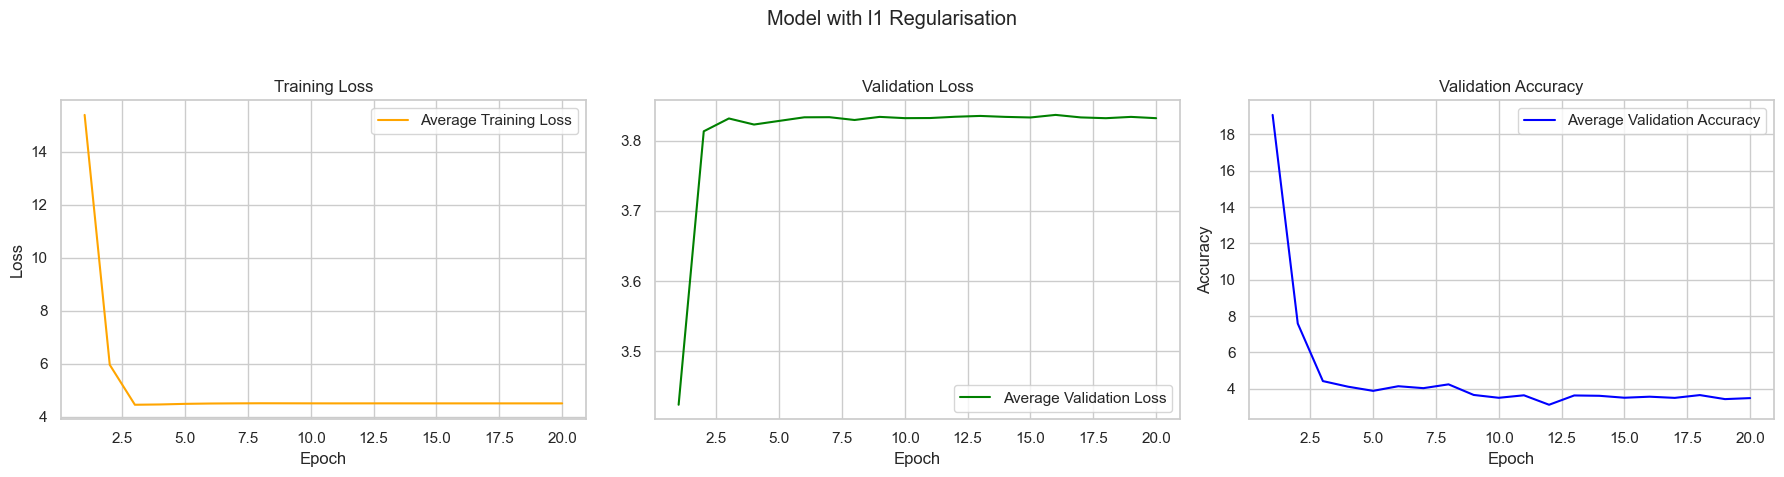

Model with l1 Regularisation - Final Average Training Loss: 4.508
Model with l1 Regularisation - Final Average Validation Loss: 3.832
Model with l1 Regularisation - Final Average Validation Accuracy: 3.49%


 ################################ 




In [86]:
def setup_optimizer_scheduler(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []


print(f"Running cross-validation with best model using L1 regularisation")

model_constructor = get_model_constructor(activation_fn)

# Assuming all other functions (cross-validation, plotting, etc.) are defined correctly
fold_results = stratified_k_fold_cross_validation_with_l1(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device,
    l1 = 0.01
)

    # Plot the results
plot_fold_results(fold_results, f"Model with l1 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

In [ ]:
# we will use with l2 reg

In [ ]:
# as the baseline has dropout = true, we will test if dropout is false : 

In [89]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return four_layer_BN_MLP(use_bn = True,activation_fn= F.leaky_relu,use_dropout=False) #best performing activation function
    return model_constructor

Running cross-validation with best model using without dropout
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:00<00:00,  3.02s/it]


Fold 1 completed. Validation accuracy: 85.06%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


Fold 2 completed. Validation accuracy: 84.73%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


Fold 3 completed. Validation accuracy: 84.69%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.15s/it]


Fold 4 completed. Validation accuracy: 84.97%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


Fold 5 completed. Validation accuracy: 85.04%



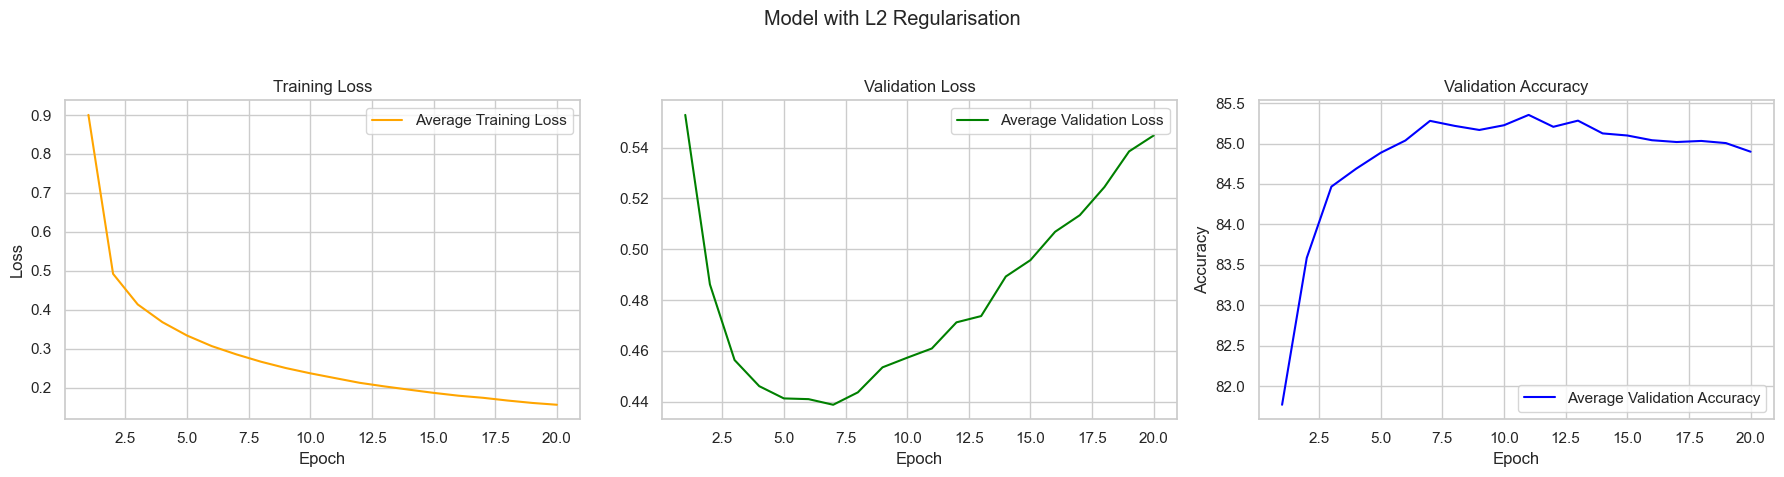

Model with L2 Regularisation - Final Average Training Loss: 0.156
Model with L2 Regularisation - Final Average Validation Loss: 0.545
Model with L2 Regularisation - Final Average Validation Accuracy: 84.90%


 ################################ 




In [91]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=1e-5)  # implementing l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []


print(f"Running cross-validation with best model using without dropout")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with L2 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

In [ ]:
#without dropout is slightly better

In [ ]:
#best performing model on test dataset

In [108]:
def train_and_validate_model(train_loader, val_loader, model, optimizer, scheduler, epochs, device):
    import torch
    from torch import no_grad
    from torch.nn import functional as F
    from tqdm import tqdm
    import numpy as np

    train_losses = []
    val_losses = []
    val_accuracies = []
    all_preds = []
    all_labels = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        preds = []
        labels = []
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
                preds.extend(y_pred.argmax(1).tolist())
                labels.extend(y.tolist())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)
        all_preds.extend(preds)
        all_labels.extend(labels)

    return train_losses, val_losses, val_accuracies, all_preds, all_labels

In [134]:
import torch
from torch import no_grad
from torch.nn import functional as F
from tqdm import tqdm

def train_and_validate_model(train_loader, val_loader, model, optimizer, scheduler, epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Variables for storing sample predictions
    sample_preds = []
    sample_labels = []
    sample_images = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
                
                # Optionally collect data for visualization
                if epoch == epochs - 1:  # Collect on last epoch
                    predictions = y_pred.argmax(1)
                    sample_preds.extend(predictions.cpu().numpy())
                    sample_labels.extend(y.cpu().numpy())
                    sample_images.extend(X.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    # Return the usual metrics and the samples for visualization
    return train_losses, val_losses, val_accuracies, sample_images, sample_preds, sample_labels

In [135]:
def plot_confusion_matrix(labels, preds, num_classes, label_char_mapping):
    """
    Plot confusion matrix using matplotlib and seaborn with custom labels from EMNIST.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(labels, preds, labels=range(num_classes))
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[label_char_mapping[i] for i in range(num_classes)],
                yticklabels=[label_char_mapping[i] for i in range(num_classes)])
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [143]:

def plot_sample_predictions(images, true_labels, preds, label_char_mapping):
    """
    Plots a selection of images with their predicted and true labels,
    converting label indices to characters using a provided mapping.
    
    Parameters:
    - images: Array of image data.
    - true_labels: Array of true labels.
    - preds: Array of predicted labels.
    - label_char_mapping: Dictionary mapping label indices to characters.
    """
    plt.figure(figsize=(10, 2))
    for i, (image, true_label, pred) in enumerate(zip(images[:6], true_labels[:6], preds[:6]), start=1):
        plt.subplot(1, 6, i)
        plt.imshow(image.squeeze(), cmap='gray')  # Assuming grayscale images
        # Use label_char_mapping to convert indices to characters
        true_char = label_char_mapping[true_label]
        pred_char = label_char_mapping[pred]
        plt.title(f'T:{true_char}\nP:{pred_char}')
        plt.axis('off')
    plt.show()

In [154]:
# We also need to modify our k-fold cross validation function:
def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - setup_optimizer_scheduler:
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies, sample_images, sample_preds, sample_labels = train_and_validate_model(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device
        )

        # Plot the confusion matrix for the last fold or adjust to accumulate across folds
       # plot_confusion_matrix(all_labels, all_preds, num_classes=47)  # Adjust num_classes as needed
         # End timing here
        if fold == 5:
            # Load the mapping
            mapping_file_path = 'emnist-balanced-mapping.txt'
            label_char_mapping = load_label_mapping(mapping_file_path)
            plot_confusion_matrix(sample_labels, sample_preds, num_classes=47, label_char_mapping=label_char_mapping)
            # Display top six sample predictions
            print("Top six sample predictions:")
            #for i in range(6):
                #print(f"Image {i+1} - True label: {sample_labels[i]}, Predicted: {sample_preds[i]}")
            plot_sample_predictions(sample_images, sample_labels, sample_preds, label_char_mapping)

# Assume you have labels and preds from your validation phase
            #plot_confusion_matrix(all_labels, all_preds, num_classes=47, label_char_mapping=label_char_mapping)
    
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results

In [155]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=1e-5)  # implementing l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []


print(f"Running cross-validation with best model")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=test_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)



    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

Running cross-validation with best model
Starting fold 1/5


TypeError: train_and_validate_model() takes from 5 to 6 positional arguments but 7 were given

In [ ]:
#re-initialising train and validate model and stratified k-fold validation

In [158]:
from tqdm import tqdm


def train_and_validate_model(train_loader, val_loader, model, optimizer, epochs, device=device):
    """
    Trains and validates the model for a given train/val set, implements early stopping (default trigger - no improvement after 5 epochs).

    Parameters:
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - model: The neural network model to train.
    - optimizer: The optimizer to use for training.
    - epochs: Number of epochs to train for.
    - device: The device (CPU or GPU) to use for training and evaluation.

    Returns:
    - A tuple containing the average training loss, average validation loss, and average validation accuracy.
    """
    from torch import no_grad
    from torch.nn import functional as F
    
    model.to(device)
    # Track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Early stopping setup
    estop_tolerance = 5
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        # Training loop
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= estop_tolerance:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

    return train_losses, val_losses, val_accuracies


In [159]:
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np

def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, optimizer_constructor, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer = optimizer_constructor(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, epochs, device
        )

         # End timing here
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)
        print(f"Using device: {device}")
        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}%\n")

    return fold_results


In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FourLayerCNN(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, use_dropout=True, activation_fn=F.relu):
        super(FourLayerCNN, self).__init__()
        self.activation_fn = activation_fn

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # Assuming input size (1, 28, 28)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (32, 14, 14)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (64, 7, 7)

        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_bn else nn.Identity()

        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128) if use_bn else nn.Identity()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (128, 3, 3)

        # Define the output layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc = nn.Linear(128 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.pool1(self.activation_fn(self.bn1(self.conv1(x))))
        x = self.pool2(self.activation_fn(self.bn2(self.conv2(x))))
        x = self.activation_fn(self.bn3(self.conv3(x)))
        x = self.pool4(self.activation_fn(self.bn4(self.conv4(x))))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [153]:
# Let's train out first neural network on the training dataset using k-fold cross val:

def model_constructor():
    return FourLayerCNN(activation_fn = F.relu)

def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

four_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Your dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:20<00:00,  4.05s/it]


Train time on cuda: 80.938 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 87.17%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


Train time on cuda: 76.593 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 86.36%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:17<00:00,  3.85s/it]


Train time on cuda: 77.065 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 87.12%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:18<00:00,  3.92s/it]


Train time on cuda: 78.331 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 86.91%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:17<00:00,  3.87s/it]

Train time on cuda: 77.345 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 86.95%



In [160]:
class ThreeLayerCNN(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, use_dropout=True, activation_fn=F.relu):
        super(ThreeLayerCNN, self).__init__()
        self.activation_fn = activation_fn

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # Input channels, output channels, kernel size
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (32, 14, 14)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (64, 7, 7)

        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_bn else nn.Identity()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (128, 3, 3)

        # Define the output layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc = nn.Linear(128 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.pool1(self.activation_fn(self.bn1(self.conv1(x))))
        x = self.pool2(self.activation_fn(self.bn2(self.conv2(x))))
        x = self.pool3(self.activation_fn(self.bn3(self.conv3(x))))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [161]:
# Let's train out first neural network on the training dataset using k-fold cross val:

def model_constructor():
    return ThreeLayerCNN(activation_fn = F.relu)

def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

four_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Your dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:09<00:00,  3.50s/it]


Train time on cuda: 69.995 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 86.84%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Train time on cuda: 68.493 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 86.33%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:07<00:00,  3.35s/it]


Train time on cuda: 67.101 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 86.32%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Train time on cuda: 68.327 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 86.96%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]

Train time on cuda: 67.376 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 86.81%



In [162]:
class TwoLayerCNN(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, use_dropout=True, activation_fn=F.relu):
        super(TwoLayerCNN, self).__init__()
        self.activation_fn = activation_fn

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # Input channels, output channels, kernel size
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (32, 14, 14)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (64, 7, 7)

        # Define the output layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool1(self.activation_fn(self.bn1(self.conv1(x))))
        x = self.pool2(self.activation_fn(self.bn2(self.conv2(x))))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [163]:
def model_constructor():
    return ThreeLayerCNN(activation_fn = F.relu)

def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

four_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  
    n_splits=5,  
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


Train time on cuda: 66.783 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 86.76%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


Train time on cuda: 66.676 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 86.45%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:06<00:00,  3.35s/it]


Train time on cuda: 66.948 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 86.28%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:10<00:00,  3.53s/it]


Train time on cuda: 70.508 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 86.84%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]

Train time on cuda: 70.810 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 86.76%



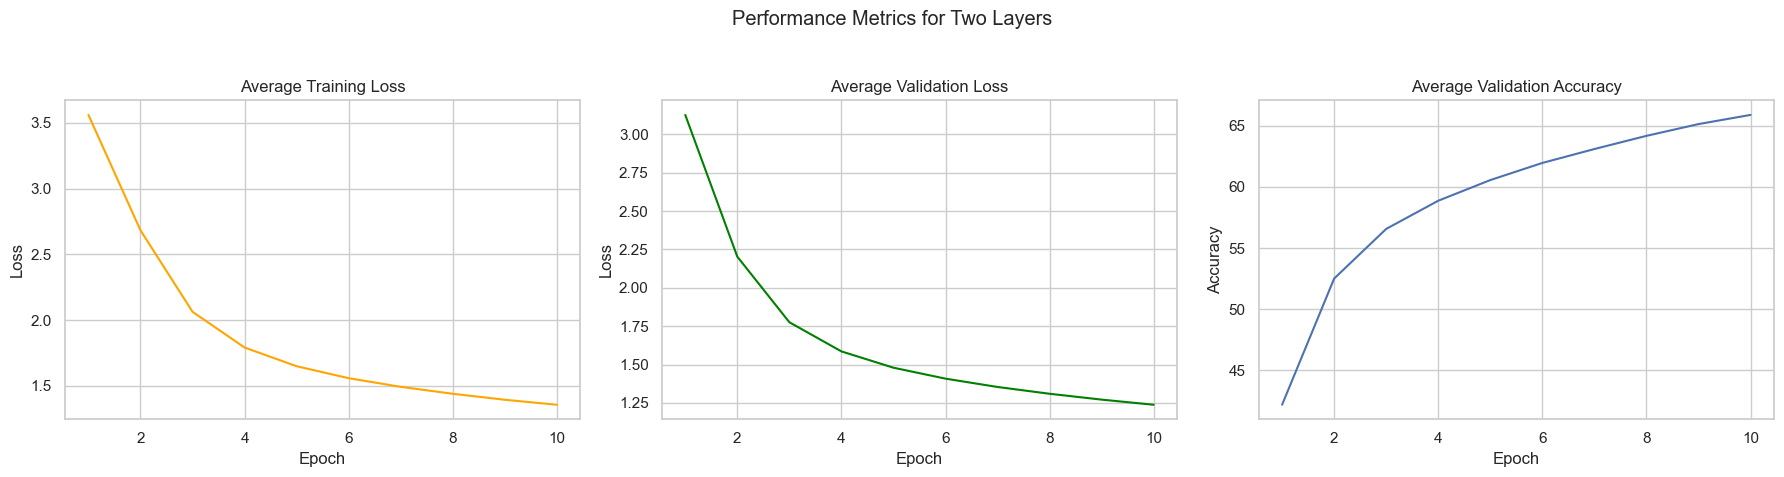

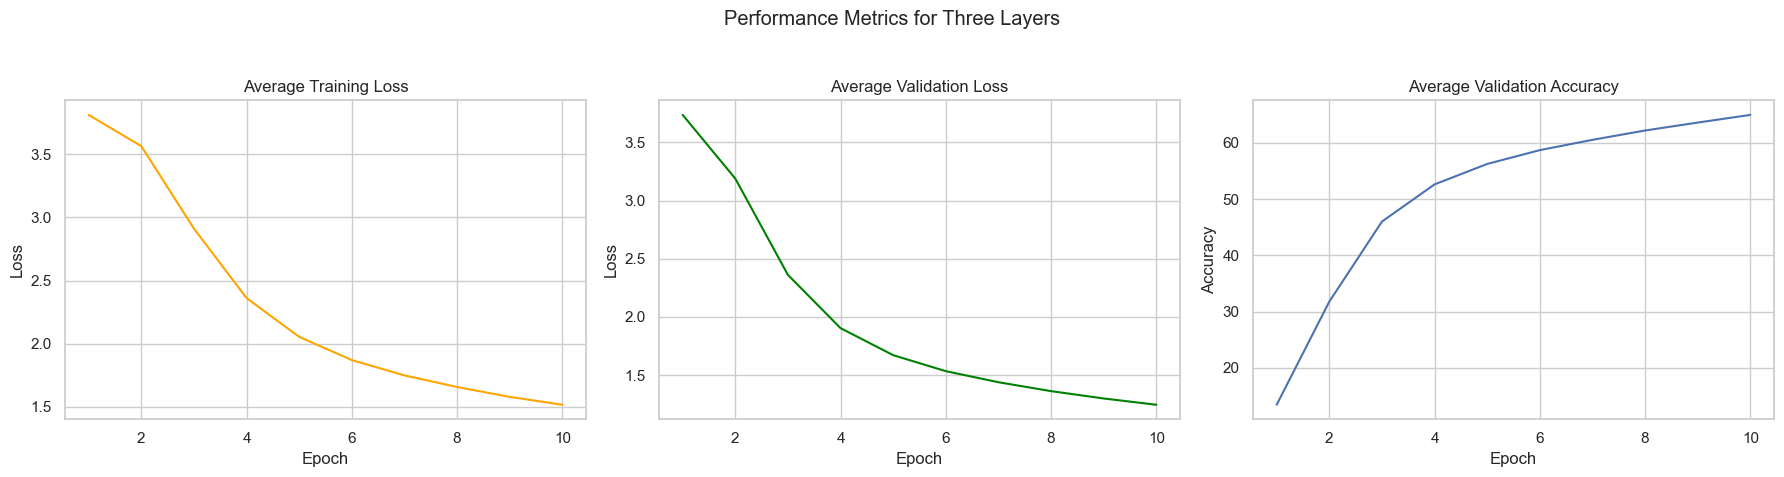

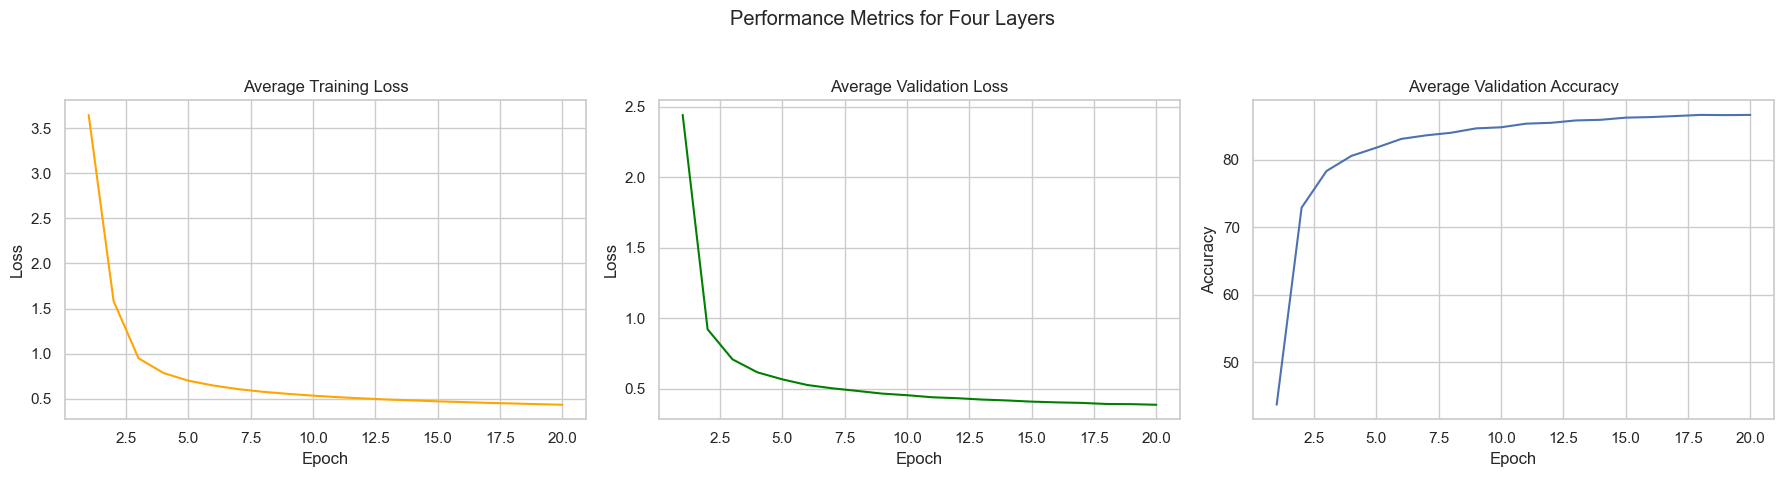

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# List of results for different numbers of layers
fold_results_list = [
    two_layer_fold_results,
    three_layer_fold_results,
    four_layer_fold_results
]

layer_names = ['Two Layers', 'Three Layers', 'Four Layers']

# Loop over each set of fold results
for fold_results, name in zip(fold_results_list, layer_names):
    # Calculating the average metrics
    avg_train_loss = np.mean([results['train_losses'] for results in fold_results], axis=0)
    avg_val_loss = np.mean([results['val_losses'] for results in fold_results], axis=0)
    avg_val_accuracy = np.mean([results['val_accuracies'] for results in fold_results], axis=0)

    epochs = range(1, len(avg_val_accuracy) + 1)

    # Plotting
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Performance Metrics for {name}')

    # Plot Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, avg_train_loss, label='Average Training Loss', color='orange')
    plt.title('Average Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, avg_val_loss, label='Average Validation Loss', color='green')
    plt.title('Average Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, avg_val_accuracy, label='Average Validation Accuracy')
    plt.title('Average Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

In [165]:
# redefining model constructor as the best performing model
def model_constructor():
    return FourLayerCNN(activation_fn = F.relu).to(device)

def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)


In [166]:
grid_search_results = grid_search_optimizers_learning_rates(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizers=optimizers,
    learning_rates=learning_rates,
    epochs=20,
    device=device
)

Testing RMSprop with learning rate: 0.001
Starting fold 1/5


Epochs:  75%|███████▌  | 15/20 [01:05<00:21,  4.35s/it]


Early stopping triggered after 16 epochs.
Train time on cuda: 65.300 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 88.96%

Starting fold 2/5


Epochs:  55%|█████▌    | 11/20 [00:47<00:39,  4.34s/it]


Early stopping triggered after 12 epochs.
Train time on cuda: 47.778 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 88.57%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


Train time on cuda: 80.692 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 89.34%

Starting fold 4/5


Epochs:  75%|███████▌  | 15/20 [01:05<00:21,  4.37s/it]


Early stopping triggered after 16 epochs.
Train time on cuda: 65.544 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 89.24%

Starting fold 5/5


Epochs:  70%|███████   | 14/20 [01:01<00:26,  4.40s/it]


Early stopping triggered after 15 epochs.
Train time on cuda: 61.615 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 89.35%

Testing RMSprop with learning rate: 0.01
Starting fold 1/5


Epochs:  80%|████████  | 16/20 [01:12<00:18,  4.53s/it]


Early stopping triggered after 17 epochs.
Train time on cuda: 72.467 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 82.78%

Starting fold 2/5


Epochs:  60%|██████    | 12/20 [00:56<00:37,  4.74s/it]


Early stopping triggered after 13 epochs.
Train time on cuda: 56.932 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 83.39%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:28<00:00,  4.41s/it]


Train time on cuda: 88.291 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 2.13%

Starting fold 4/5


Epochs:  65%|██████▌   | 13/20 [00:55<00:29,  4.28s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 55.608 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.13%

Starting fold 5/5


Epochs:  30%|███       | 6/20 [00:27<01:04,  4.60s/it]


Early stopping triggered after 7 epochs.
Train time on cuda: 27.604 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 2.13%

Testing RMSprop with learning rate: 0.1
Starting fold 1/5


Epochs:  40%|████      | 8/20 [00:34<00:52,  4.35s/it]


Early stopping triggered after 9 epochs.
Train time on cuda: 34.777 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.13%

Starting fold 2/5


Epochs:  45%|████▌     | 9/20 [00:38<00:47,  4.29s/it]


Early stopping triggered after 10 epochs.
Train time on cuda: 38.604 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 2.13%

Starting fold 3/5


Epochs:  35%|███▌      | 7/20 [00:30<00:57,  4.40s/it]


Early stopping triggered after 8 epochs.
Train time on cuda: 30.812 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 2.13%

Starting fold 4/5


Epochs:  25%|██▌       | 5/20 [00:23<01:09,  4.63s/it]


Early stopping triggered after 6 epochs.
Train time on cuda: 23.158 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.13%

Starting fold 5/5


Epochs:  40%|████      | 8/20 [00:34<00:52,  4.34s/it]


Early stopping triggered after 9 epochs.
Train time on cuda: 34.685 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 2.13%

Testing SGD with learning rate: 0.001
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


Train time on cuda: 76.137 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 66.01%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


Train time on cuda: 79.490 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 69.16%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.767 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 66.19%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.876 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 66.28%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.773 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 68.50%

Testing SGD with learning rate: 0.01
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.745 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 87.07%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.707 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 86.62%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.745 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 86.99%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.08s/it]


Train time on cuda: 81.617 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 87.26%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.751 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 87.15%

Testing SGD with learning rate: 0.1
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.10s/it]


Train time on cuda: 81.995 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 89.34%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:24<00:00,  4.21s/it]


Train time on cuda: 84.164 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 89.01%

Starting fold 3/5


Epochs:  90%|█████████ | 18/20 [01:13<00:08,  4.10s/it]


Early stopping triggered after 19 epochs.
Train time on cuda: 73.797 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 89.36%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.07s/it]


Train time on cuda: 81.477 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 89.40%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


Train time on cuda: 80.633 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 89.04%

Testing Adam with learning rate: 0.001
Starting fold 1/5


Epochs:  75%|███████▌  | 15/20 [01:05<00:21,  4.39s/it]


Early stopping triggered after 16 epochs.
Train time on cuda: 65.851 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 89.30%

Starting fold 2/5


Epochs:  75%|███████▌  | 15/20 [01:04<00:21,  4.32s/it]


Early stopping triggered after 16 epochs.
Train time on cuda: 64.795 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 88.67%

Starting fold 3/5


Epochs:  75%|███████▌  | 15/20 [01:05<00:21,  4.36s/it]


Early stopping triggered after 16 epochs.
Train time on cuda: 65.460 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 89.09%

Starting fold 4/5


Epochs:  60%|██████    | 12/20 [00:52<00:35,  4.39s/it]


Early stopping triggered after 13 epochs.
Train time on cuda: 52.650 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 89.20%

Starting fold 5/5


Epochs:  75%|███████▌  | 15/20 [01:04<00:21,  4.29s/it]


Early stopping triggered after 16 epochs.
Train time on cuda: 64.326 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 89.54%

Testing Adam with learning rate: 0.01
Starting fold 1/5


Epochs:  65%|██████▌   | 13/20 [00:56<00:30,  4.35s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 56.569 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.13%

Starting fold 2/5


Epochs:  30%|███       | 6/20 [00:28<01:07,  4.81s/it]


Early stopping triggered after 7 epochs.
Train time on cuda: 28.874 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 83.94%

Starting fold 3/5


Epochs:  30%|███       | 6/20 [00:27<01:04,  4.62s/it]


Early stopping triggered after 7 epochs.
Train time on cuda: 27.722 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 2.13%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


Train time on cuda: 81.240 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 81.89%

Starting fold 5/5


Epochs:  35%|███▌      | 7/20 [00:32<00:59,  4.59s/it]


Early stopping triggered after 8 epochs.
Train time on cuda: 32.160 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 2.13%

Testing Adam with learning rate: 0.1
Starting fold 1/5


Epochs:  45%|████▌     | 9/20 [00:39<00:48,  4.42s/it]


Early stopping triggered after 10 epochs.
Train time on cuda: 39.747 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.13%

Starting fold 2/5


Epochs:  35%|███▌      | 7/20 [00:31<00:58,  4.52s/it]


Early stopping triggered after 8 epochs.
Train time on cuda: 31.634 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 2.13%

Starting fold 3/5


Epochs:  50%|█████     | 10/20 [00:44<00:44,  4.46s/it]


Early stopping triggered after 11 epochs.
Train time on cuda: 44.614 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 2.13%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:20<00:00,  4.02s/it]


Train time on cuda: 80.445 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.13%

Starting fold 5/5


Epochs:  25%|██▌       | 5/20 [00:24<01:13,  4.87s/it]

Early stopping triggered after 6 epochs.
Train time on cuda: 24.369 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 2.13%



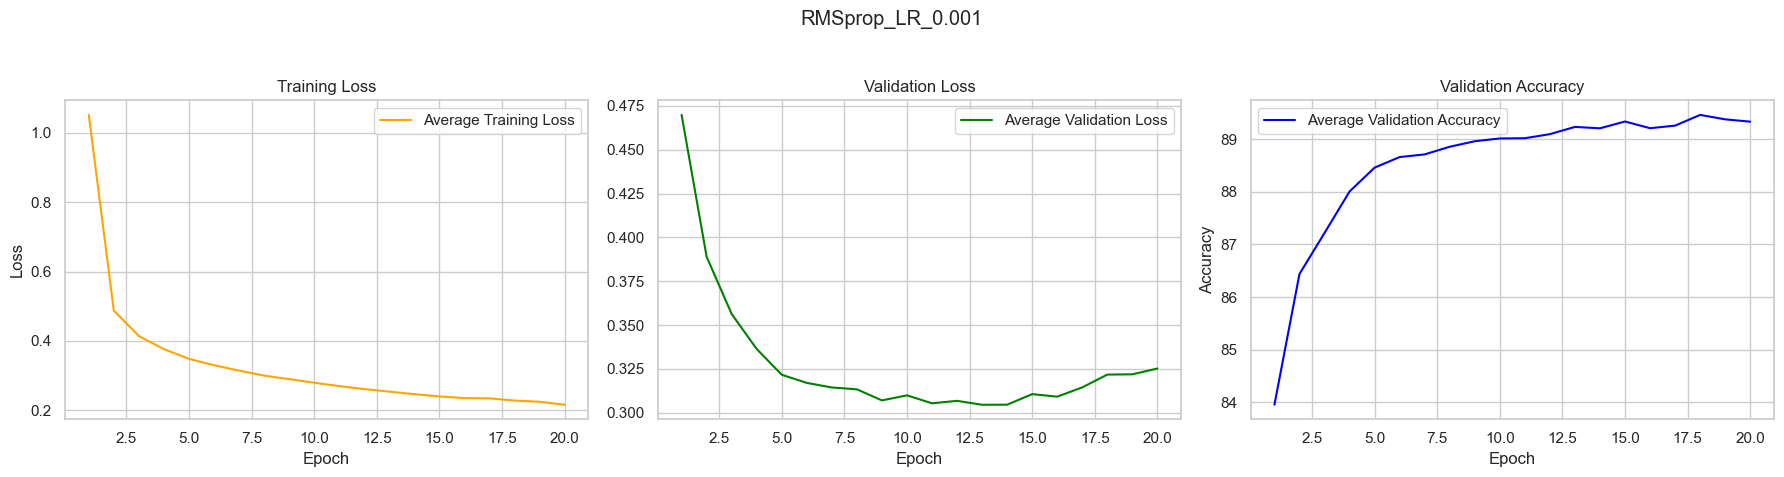

RMSprop_LR_0.001 - Final Average Training Loss: 0.216
RMSprop_LR_0.001 - Final Average Validation Loss: 0.325
RMSprop_LR_0.001 - Final Average Validation Accuracy: 89.34%


 ################################ 




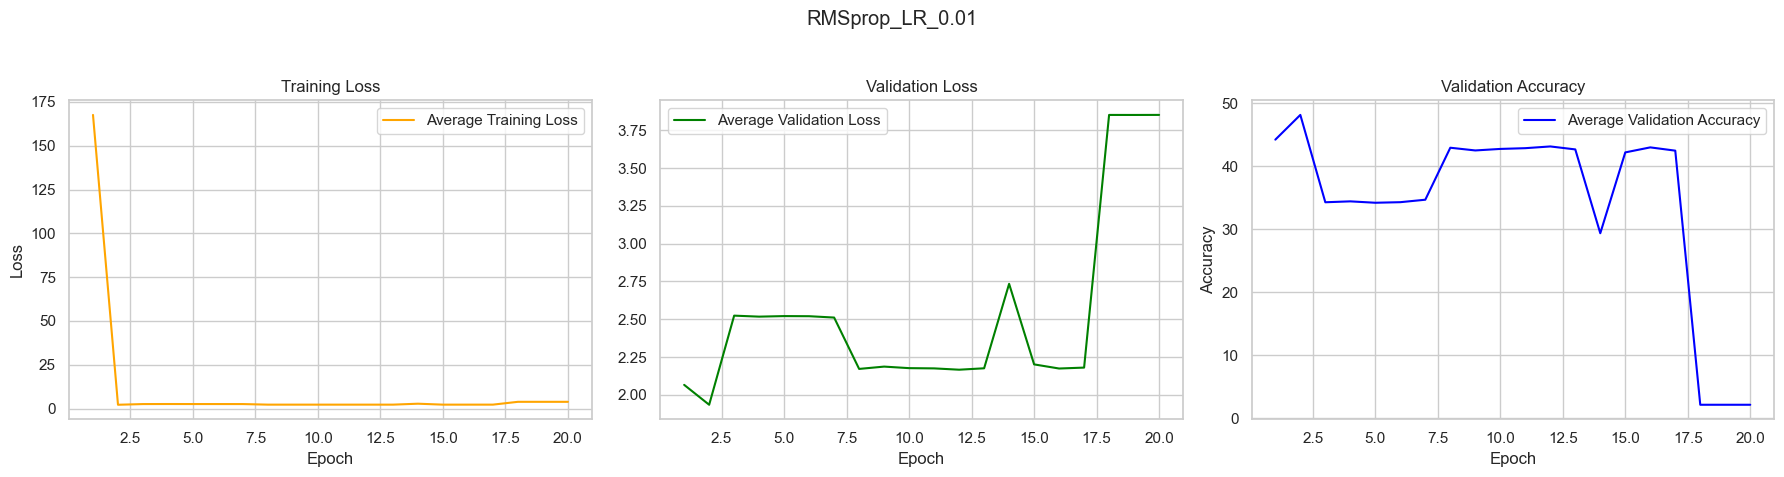

RMSprop_LR_0.01 - Final Average Training Loss: 3.852
RMSprop_LR_0.01 - Final Average Validation Loss: 3.852
RMSprop_LR_0.01 - Final Average Validation Accuracy: 2.13%


 ################################ 




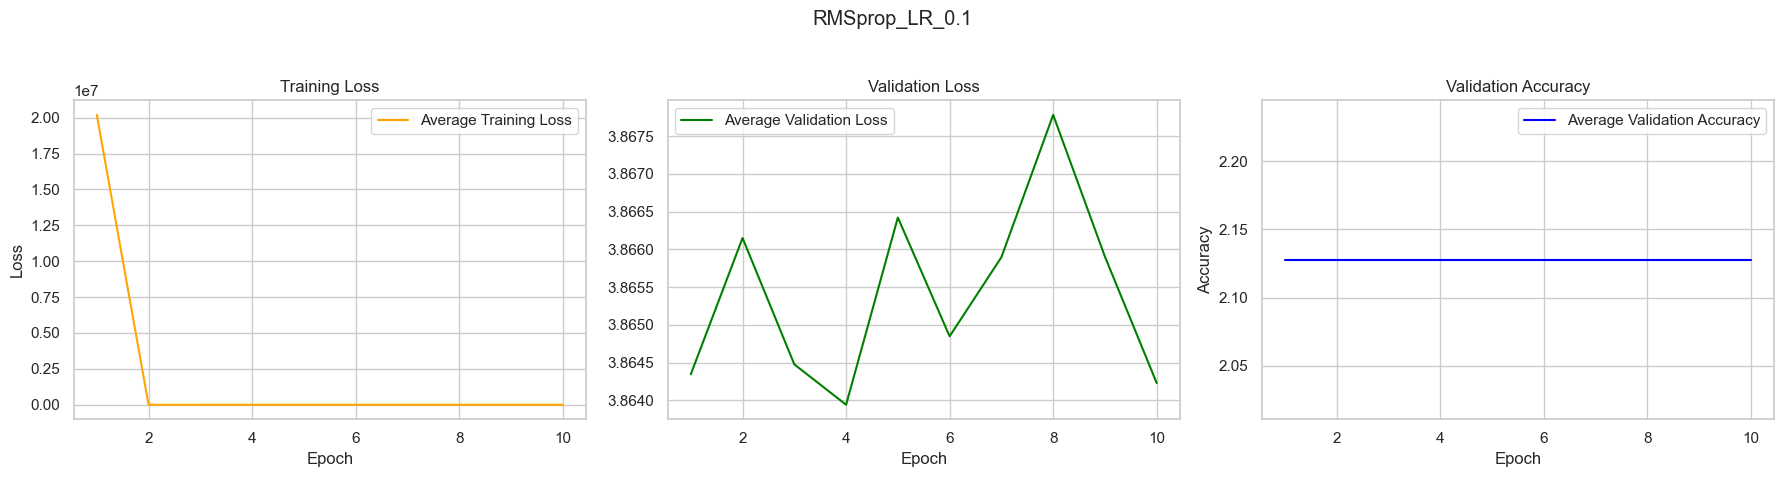

RMSprop_LR_0.1 - Final Average Training Loss: 3.866
RMSprop_LR_0.1 - Final Average Validation Loss: 3.864
RMSprop_LR_0.1 - Final Average Validation Accuracy: 2.13%


 ################################ 




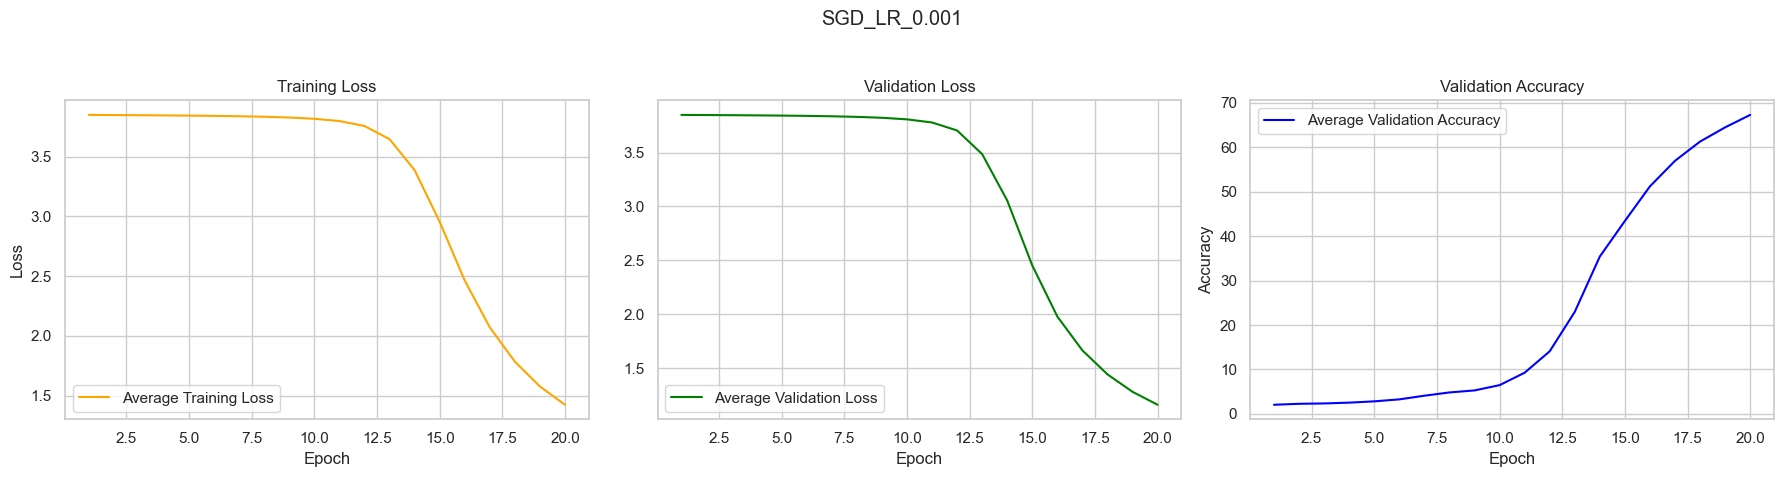

SGD_LR_0.001 - Final Average Training Loss: 1.423
SGD_LR_0.001 - Final Average Validation Loss: 1.161
SGD_LR_0.001 - Final Average Validation Accuracy: 67.23%


 ################################ 




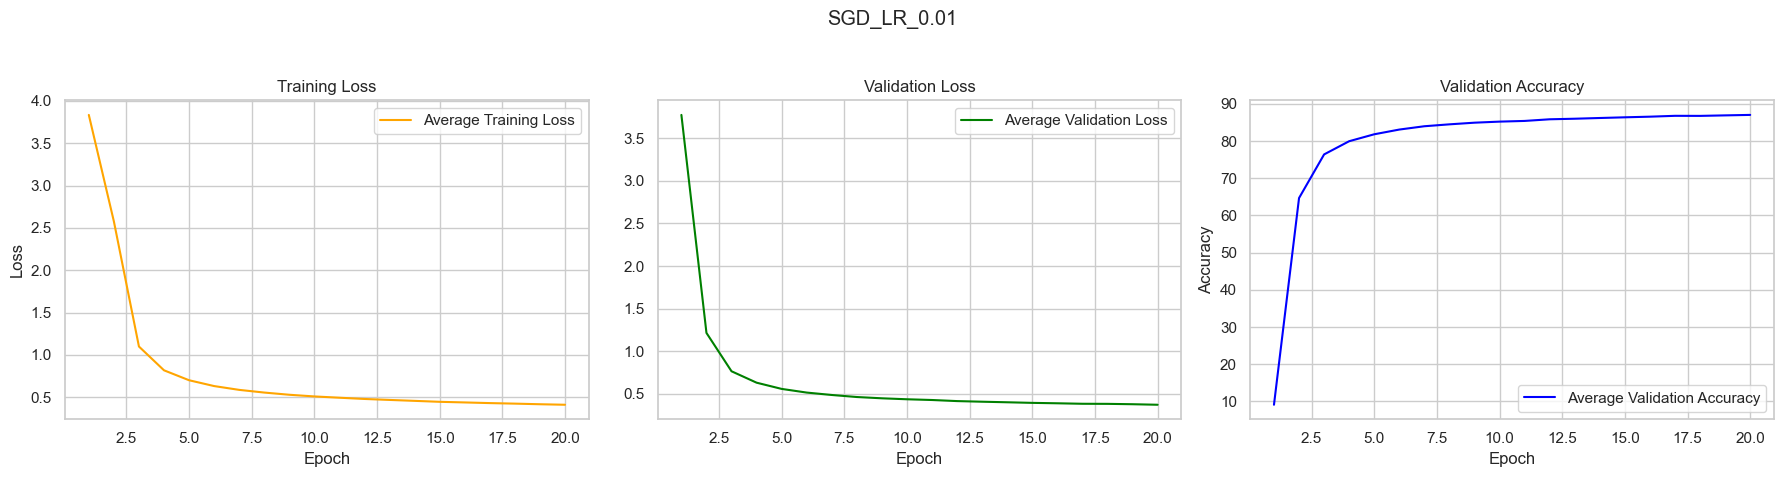

SGD_LR_0.01 - Final Average Training Loss: 0.410
SGD_LR_0.01 - Final Average Validation Loss: 0.373
SGD_LR_0.01 - Final Average Validation Accuracy: 87.02%


 ################################ 




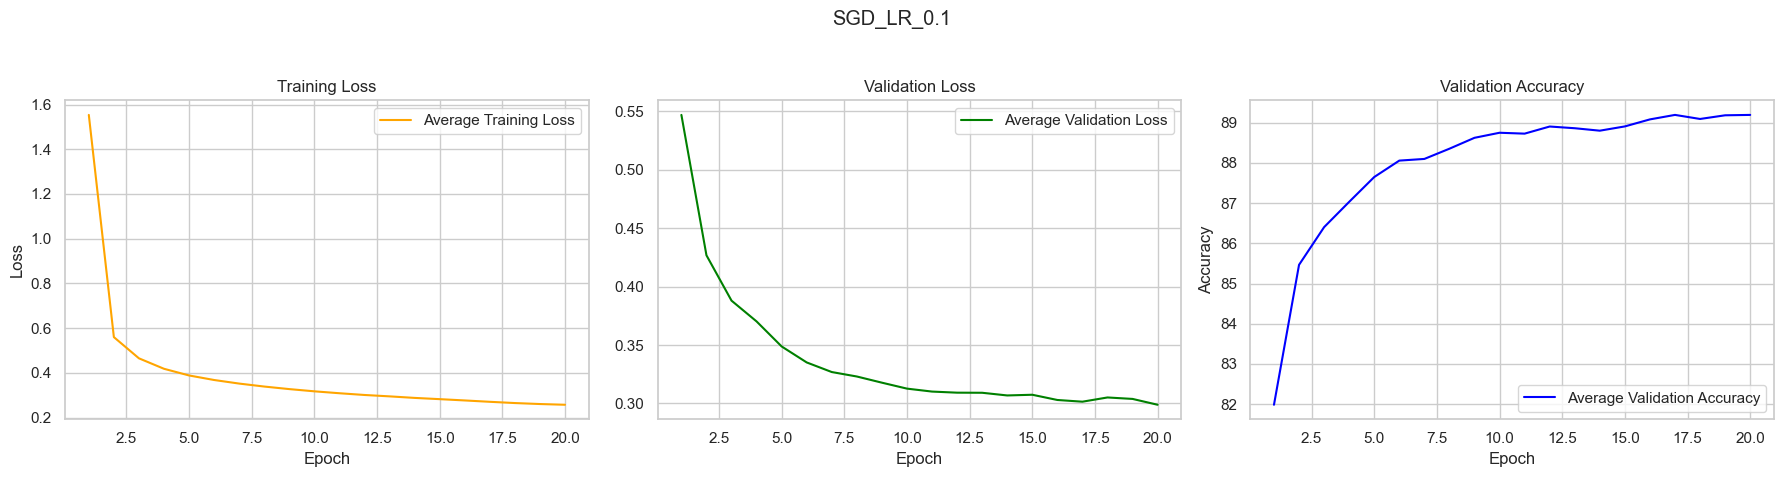

SGD_LR_0.1 - Final Average Training Loss: 0.257
SGD_LR_0.1 - Final Average Validation Loss: 0.299
SGD_LR_0.1 - Final Average Validation Accuracy: 89.20%


 ################################ 




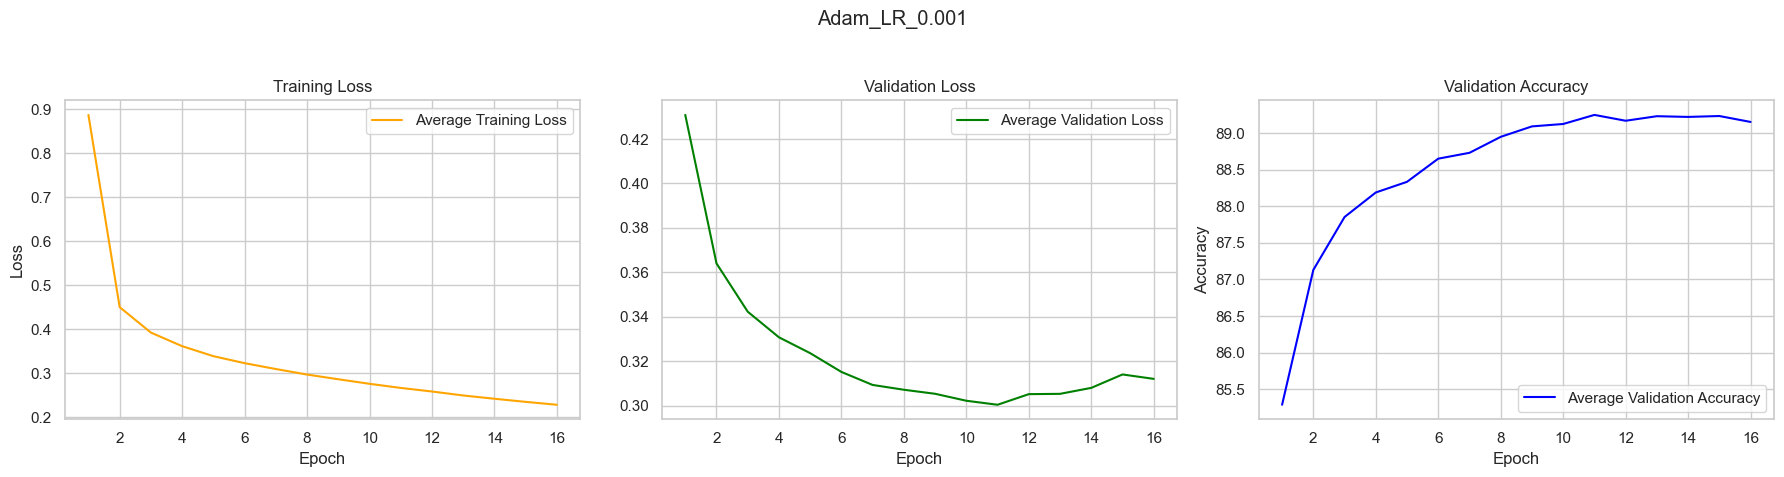

Adam_LR_0.001 - Final Average Training Loss: 0.228
Adam_LR_0.001 - Final Average Validation Loss: 0.312
Adam_LR_0.001 - Final Average Validation Accuracy: 89.15%


 ################################ 




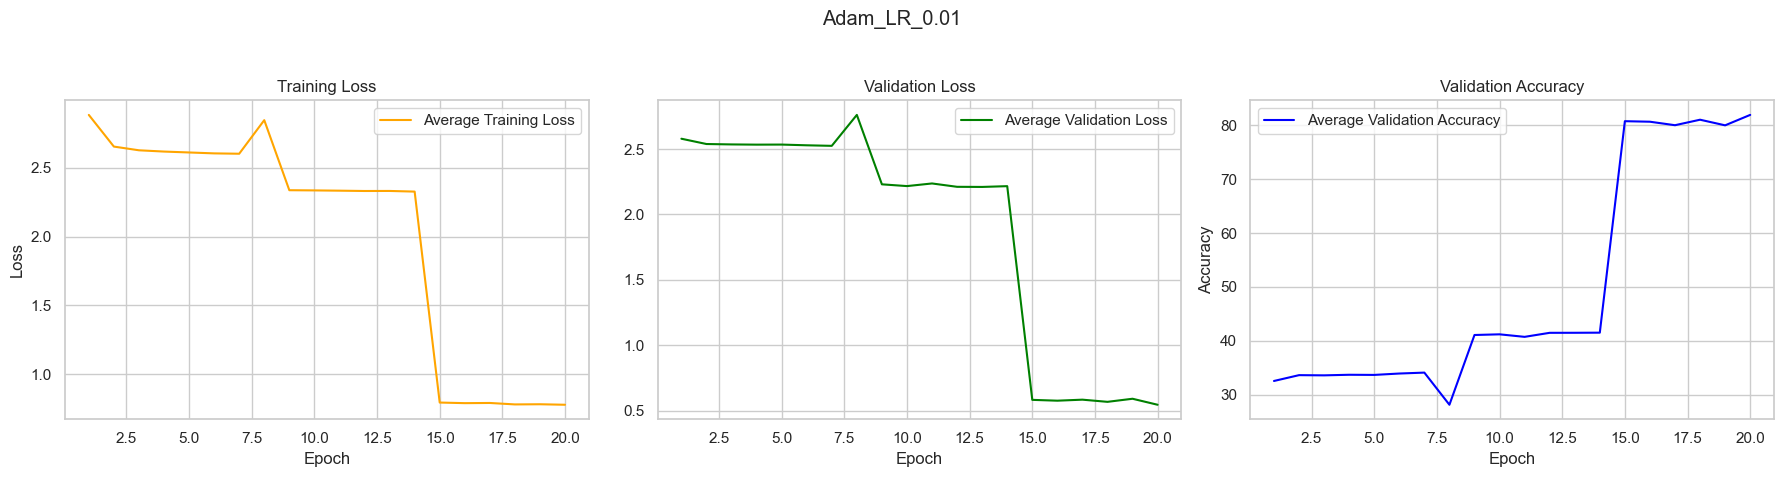

Adam_LR_0.01 - Final Average Training Loss: 0.779
Adam_LR_0.01 - Final Average Validation Loss: 0.545
Adam_LR_0.01 - Final Average Validation Accuracy: 81.89%


 ################################ 




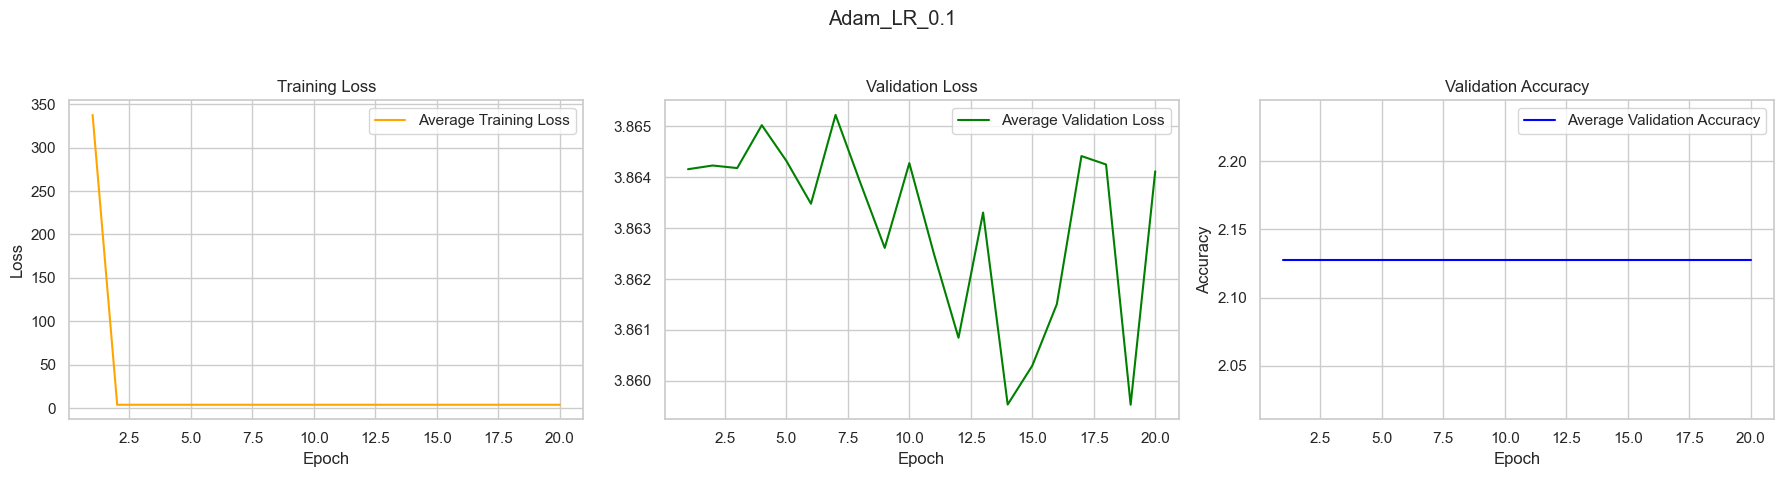

Adam_LR_0.1 - Final Average Training Loss: 3.865
Adam_LR_0.1 - Final Average Validation Loss: 3.864
Adam_LR_0.1 - Final Average Validation Accuracy: 2.13%


 ################################ 




In [167]:
# Let's initialise a list to hold a summary of the training results
results_summary_list = []

# We then loop through all combinations in grid_search_results
for combo_name, fold_results in grid_search_results.items():
    # Plot the results and capture the returned summary
    summary = plot_fold_results(fold_results, combo_name)

    # Add the summary to the list
    results_summary_list.append(summary)

In [168]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results_summary_list)

# Ensure 'final_average_val_accuracy' is numeric (it should be, but this is just in case)
results_df['final_average_val_accuracy'] = pd.to_numeric(results_df['final_average_val_accuracy'])

# Sort the DataFrame by 'final_average_val_accuracy' in ascending order
results_df_sorted = results_df.sort_values('final_average_val_accuracy', ascending=False)

# Display the sorted DataFrame
display(results_df_sorted)

model_title  final_average_train_loss  final_average_val_loss  \
0  RMSprop_LR_0.001                  0.216313                0.325217   
5        SGD_LR_0.1                  0.257269                0.298890   
6     Adam_LR_0.001                  0.227954                0.312057   
4       SGD_LR_0.01                  0.409675                0.372579   
7      Adam_LR_0.01                  0.779498                0.544595   
3      SGD_LR_0.001                  1.423005                1.160735   
1   RMSprop_LR_0.01                  3.851908                3.851595   
2    RMSprop_LR_0.1                  3.866337                3.864229   
8       Adam_LR_0.1                  3.865004                3.864115   

   final_average_val_accuracy  
0                   89.335106  
5                   89.196587  
6                   89.151152  
4                   87.018617  
7                   81.888298  
3                   67.227837  
1                    2.127660  
2                    2.127660  
8                    2.127660

In [169]:
def adam_optimizer(params, lr=0.001):
    return torch.optim.Adam(params, lr=lr)

def rmsprop_optimizer(params, lr=0.001):
    return torch.optim.RMSprop(params, lr=lr)

# Define lr_scheduler constructors, given a Learning Rate.

def step_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def exponential_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)

# We can then combine optimizers with schedulers in a dictionary, which we can loop over (effectively performing grid search).
optimizer_scheduler_combinations = {
    'SGD_StepLR': (sgd_optimizer, step_lr_scheduler, {'lr': 0.1}),
    'SGD_ExponentialLR': (sgd_optimizer, exponential_lr_scheduler, {'lr': 0.1}),
    'Adam_StepLR': (adam_optimizer, step_lr_scheduler, {'lr': 0.001}),
    'Adam_ExponentialLR': (adam_optimizer, exponential_lr_scheduler, {'lr': 0.001}),
    'RMSprop_StepLR': (rmsprop_optimizer, step_lr_scheduler, {'lr': 0.001}),
    'RMSprop_ExponentialLR': (rmsprop_optimizer, exponential_lr_scheduler, {'lr': 0.001}),
}

In [170]:
def train_and_validate_model(train_loader, val_loader, model, optimizer, scheduler, epochs, device):
    from torch import no_grad
    from torch.nn import functional as F

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Update the learning rate after each epoch
        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

In [171]:
# We also need to modify our k-fold cross validation function:
def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - setup_optimizer_scheduler:
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device
        )

         # End timing here
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results


In [172]:
def grid_search_optimizers_schedulers(dataset, n_splits, model_constructor, optimizer_scheduler_combinations, epochs, device):
    all_results = {}

    for name, (optimizer_constructor, scheduler_constructor, optimizer_args) in optimizer_scheduler_combinations.items():
        print(f"Testing optimizer and scheduler combination: {name}\n")

        # Adjust the function to construct both optimizer and scheduler
        def optimizer_and_scheduler_constructor(params):
            optimizer = optimizer_constructor(params, **optimizer_args)
            scheduler = scheduler_constructor(optimizer)
            return optimizer, scheduler

        fold_results = stratified_k_fold_cross_validation(
            dataset=dataset,
            n_splits=n_splits,
            model_constructor=model_constructor,
            setup_optimizer_scheduler=optimizer_and_scheduler_constructor,
            epochs=epochs,
            device=device
        )

        all_results[name] = fold_results

    return all_results

In [173]:
optim_schedule_grid_search = grid_search_optimizers_schedulers(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizer_scheduler_combinations=optimizer_scheduler_combinations,
    epochs=20,
    device=device
)

Testing optimizer and scheduler combination: SGD_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:06<00:00,  3.32s/it]


Train time on cuda: 66.480 seconds
Fold 1 completed. Validation accuracy: 89.69

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]


Train time on cuda: 69.262 seconds
Fold 2 completed. Validation accuracy: 89.11

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:10<00:00,  3.50s/it]


Train time on cuda: 70.070 seconds
Fold 3 completed. Validation accuracy: 89.58

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:07<00:00,  3.40s/it]


Train time on cuda: 67.920 seconds
Fold 4 completed. Validation accuracy: 89.57

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.42s/it]


Train time on cuda: 68.431 seconds
Fold 5 completed. Validation accuracy: 89.63

Testing optimizer and scheduler combination: SGD_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:07<00:00,  3.39s/it]


Train time on cuda: 67.883 seconds
Fold 1 completed. Validation accuracy: 86.15

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it]


Train time on cuda: 66.861 seconds
Fold 2 completed. Validation accuracy: 85.34

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:10<00:00,  3.54s/it]


Train time on cuda: 70.869 seconds
Fold 3 completed. Validation accuracy: 86.16

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


Train time on cuda: 68.632 seconds
Fold 4 completed. Validation accuracy: 85.67

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


Train time on cuda: 68.542 seconds
Fold 5 completed. Validation accuracy: 85.86

Testing optimizer and scheduler combination: Adam_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


Train time on cuda: 75.513 seconds
Fold 1 completed. Validation accuracy: 89.87

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


Train time on cuda: 75.127 seconds
Fold 2 completed. Validation accuracy: 89.45

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:14<00:00,  3.75s/it]


Train time on cuda: 74.960 seconds
Fold 3 completed. Validation accuracy: 89.80

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


Train time on cuda: 74.767 seconds
Fold 4 completed. Validation accuracy: 89.70

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


Train time on cuda: 74.210 seconds
Fold 5 completed. Validation accuracy: 89.93

Testing optimizer and scheduler combination: Adam_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


Train time on cuda: 74.250 seconds
Fold 1 completed. Validation accuracy: 88.26

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:15<00:00,  3.75s/it]


Train time on cuda: 75.073 seconds
Fold 2 completed. Validation accuracy: 87.71

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:16<00:00,  3.84s/it]


Train time on cuda: 76.841 seconds
Fold 3 completed. Validation accuracy: 87.98

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:16<00:00,  3.82s/it]


Train time on cuda: 76.328 seconds
Fold 4 completed. Validation accuracy: 88.11

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:17<00:00,  3.85s/it]


Train time on cuda: 77.086 seconds
Fold 5 completed. Validation accuracy: 87.90

Testing optimizer and scheduler combination: RMSprop_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Train time on cuda: 72.463 seconds
Fold 1 completed. Validation accuracy: 89.84

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


Train time on cuda: 71.136 seconds
Fold 2 completed. Validation accuracy: 89.37

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:11<00:00,  3.56s/it]


Train time on cuda: 71.227 seconds
Fold 3 completed. Validation accuracy: 89.80

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:10<00:00,  3.53s/it]


Train time on cuda: 70.590 seconds
Fold 4 completed. Validation accuracy: 89.74

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]


Train time on cuda: 69.186 seconds
Fold 5 completed. Validation accuracy: 90.00

Testing optimizer and scheduler combination: RMSprop_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:09<00:00,  3.46s/it]


Train time on cuda: 69.134 seconds
Fold 1 completed. Validation accuracy: 87.17

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.45s/it]


Train time on cuda: 69.001 seconds
Fold 2 completed. Validation accuracy: 86.42

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train time on cuda: 68.877 seconds
Fold 3 completed. Validation accuracy: 87.70

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


Train time on cuda: 73.599 seconds
Fold 4 completed. Validation accuracy: 86.97

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:14<00:00,  3.73s/it]

Train time on cuda: 74.584 seconds
Fold 5 completed. Validation accuracy: 87.11



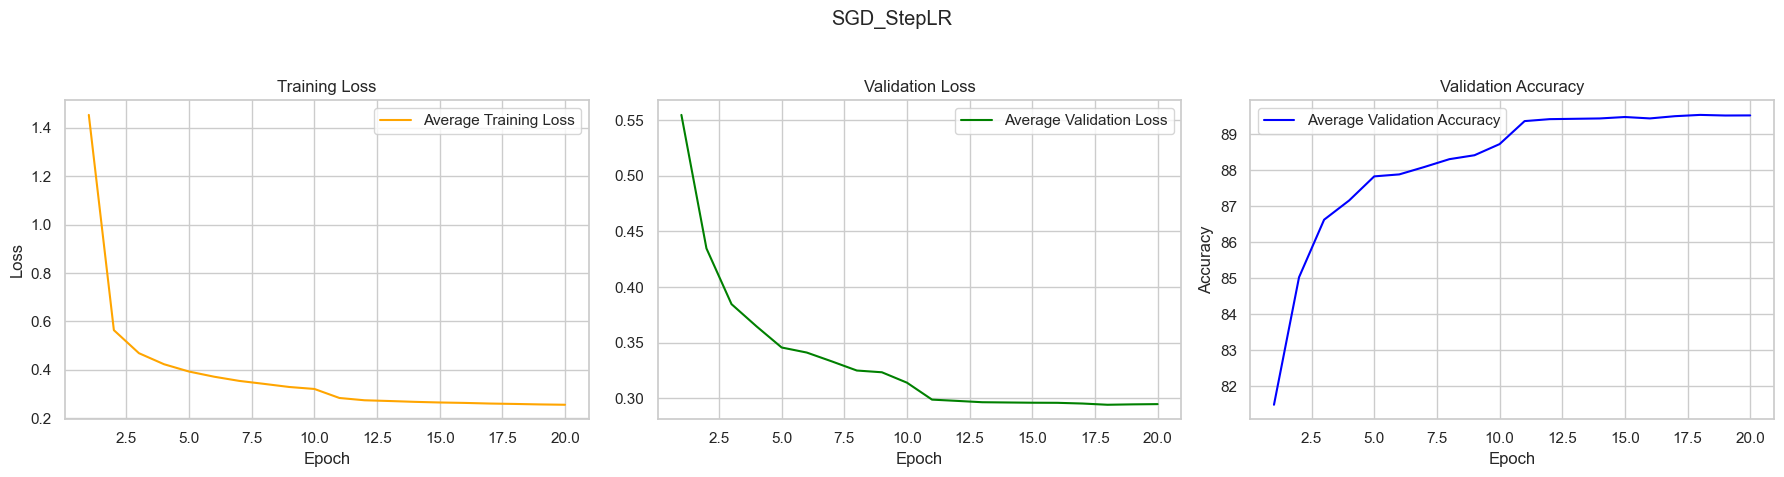

SGD_StepLR - Final Average Training Loss: 0.255
SGD_StepLR - Final Average Validation Loss: 0.295
SGD_StepLR - Final Average Validation Accuracy: 89.52%


 ################################ 




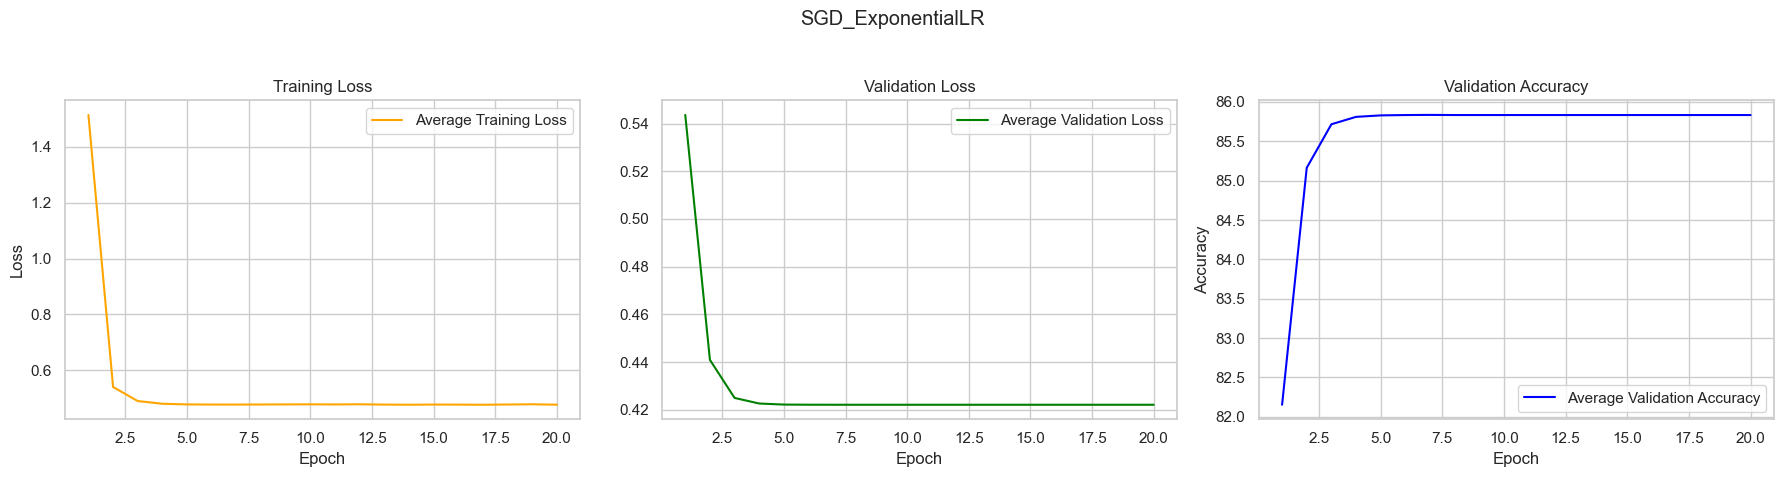

SGD_ExponentialLR - Final Average Training Loss: 0.477
SGD_ExponentialLR - Final Average Validation Loss: 0.422
SGD_ExponentialLR - Final Average Validation Accuracy: 85.83%


 ################################ 




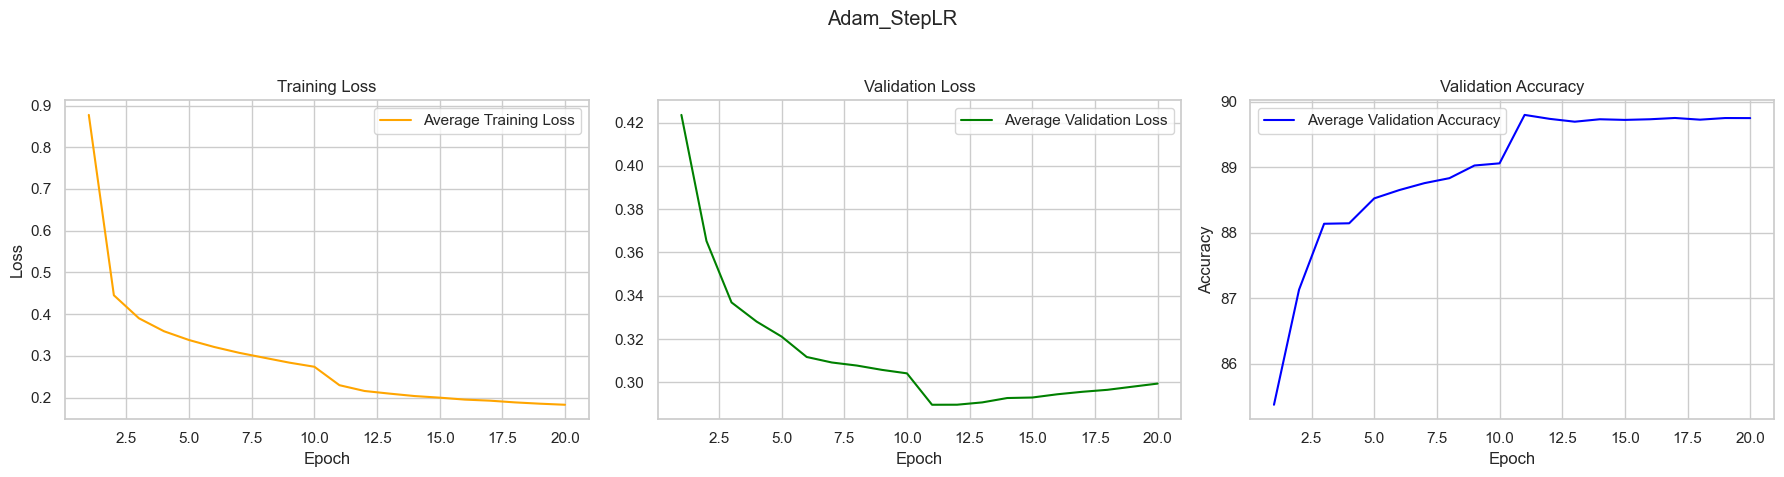

Adam_StepLR - Final Average Training Loss: 0.183
Adam_StepLR - Final Average Validation Loss: 0.299
Adam_StepLR - Final Average Validation Accuracy: 89.75%


 ################################ 




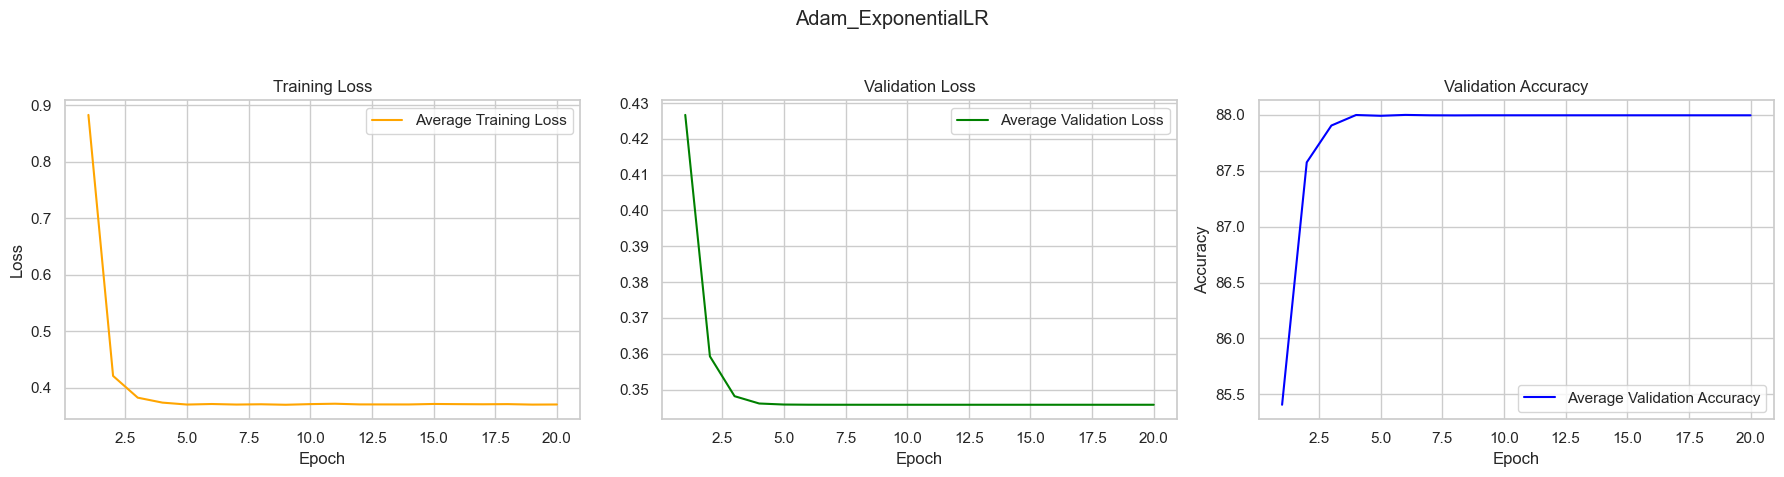

Adam_ExponentialLR - Final Average Training Loss: 0.371
Adam_ExponentialLR - Final Average Validation Loss: 0.346
Adam_ExponentialLR - Final Average Validation Accuracy: 87.99%


 ################################ 




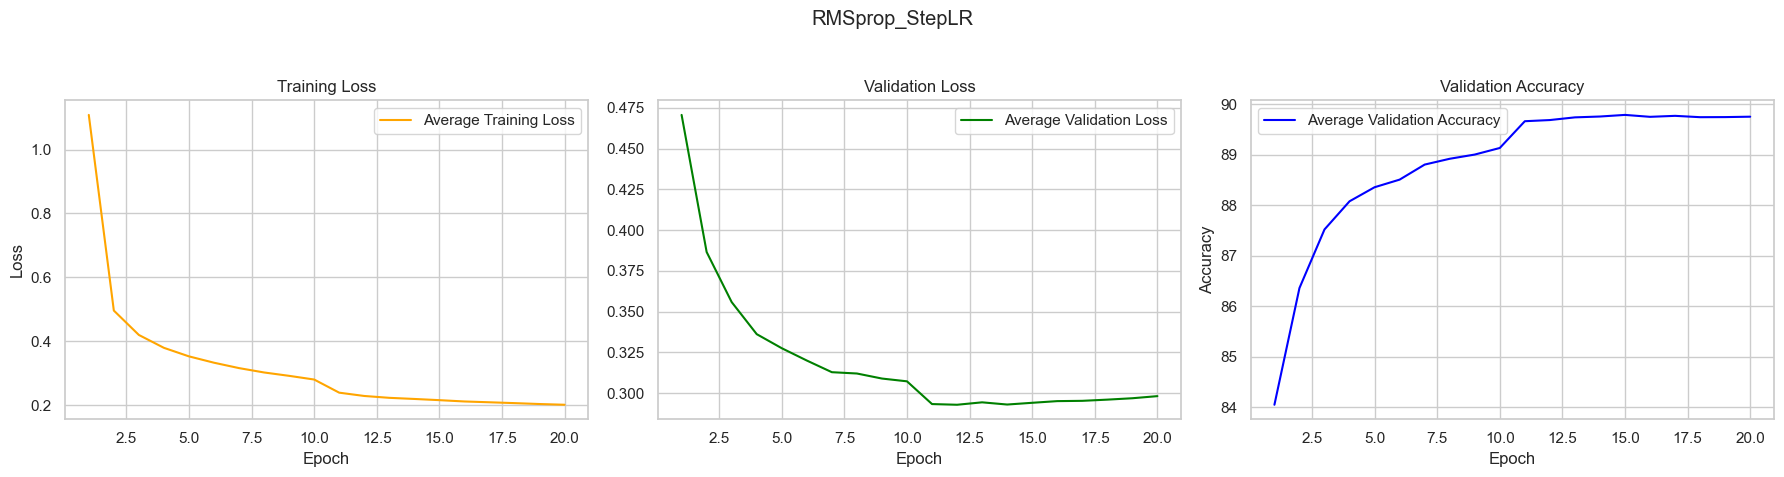

RMSprop_StepLR - Final Average Training Loss: 0.201
RMSprop_StepLR - Final Average Validation Loss: 0.298
RMSprop_StepLR - Final Average Validation Accuracy: 89.75%


 ################################ 




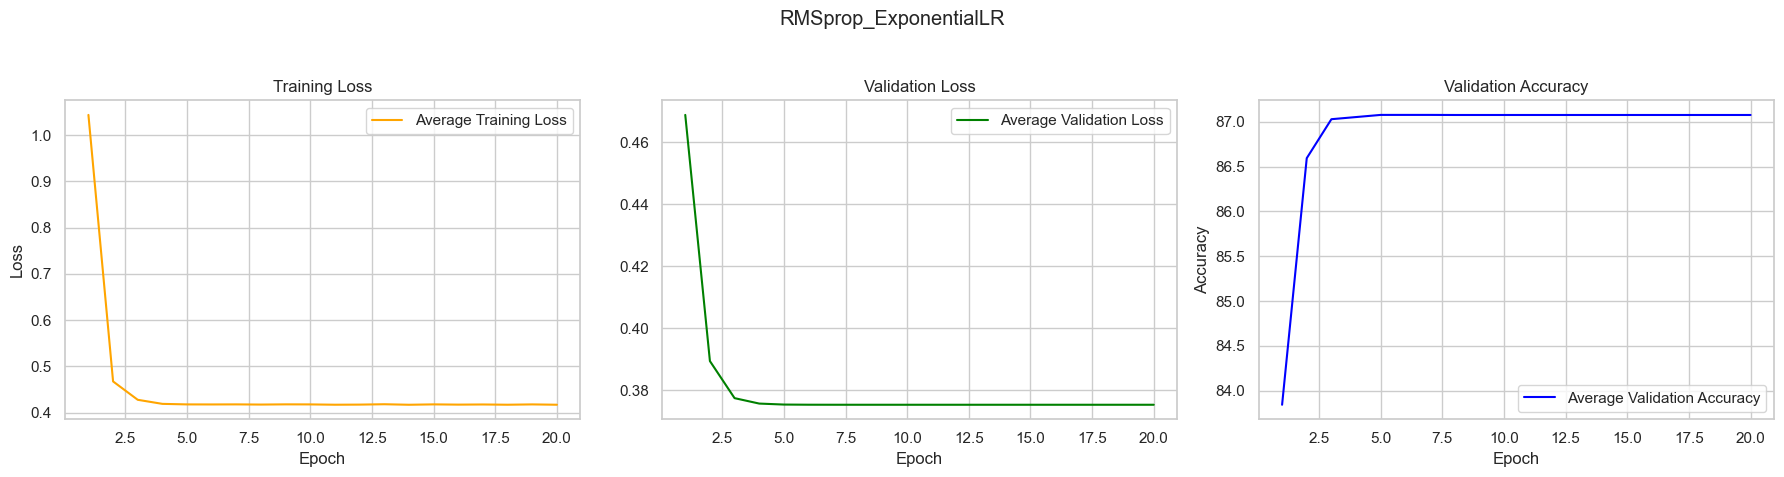

RMSprop_ExponentialLR - Final Average Training Loss: 0.417
RMSprop_ExponentialLR - Final Average Validation Loss: 0.375
RMSprop_ExponentialLR - Final Average Validation Accuracy: 87.07%


 ################################ 




In [178]:
# Let's initialise a new list to hold a summary of the training results
scheduler_results_summary_list = []

# We then loop through all combinations in grid_search_results
for combo_name, fold_results in optim_schedule_grid_search.items():
    # Plot the results and capture the returned summary
    summary = plot_fold_results(fold_results, combo_name)

    # Add the summary to the list
    scheduler_results_summary_list.append(summary)

In [179]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
scheduler_results_df = pd.DataFrame(scheduler_results_summary_list)

# Ensure 'final_average_val_accuracy' is numeric (it should be, but this is just in case)
scheduler_results_df['final_average_val_accuracy'] = pd.to_numeric(scheduler_results_df['final_average_val_accuracy'])

# Sort the DataFrame by 'final_average_val_accuracy' in ascending order
scheduler_results_df_sorted = scheduler_results_df.sort_values('final_average_val_accuracy', ascending=False)

# Display the sorted DataFrame
display(scheduler_results_df_sorted)

model_title  final_average_train_loss  final_average_val_loss  \
4         RMSprop_StepLR                  0.201064                0.298224   
2            Adam_StepLR                  0.182838                0.299396   
0             SGD_StepLR                  0.255389                0.294870   
3     Adam_ExponentialLR                  0.370626                0.345745   
5  RMSprop_ExponentialLR                  0.417267                0.375236   
1      SGD_ExponentialLR                  0.476617                0.422100   

   final_average_val_accuracy  
4                   89.752660  
2                   89.751773  
0                   89.516844  
3                   87.993794  
5                   87.074468  
1                   85.834220

In [ ]:
#RMSprop_StepLR	performs the best

In [180]:
import torch.nn.functional as F

activation_functions = {
    'ReLU': F.relu,
    'LeakyReLU': F.leaky_relu,
    'ELU': F.elu
}

In [181]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return FourLayerCNN(activation_fn=activation_fn)
    return model_constructor


Running cross-validation with ReLU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


Train time on cuda: 74.383 seconds
Fold 1 completed. Validation accuracy: 89.69

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Train time on cuda: 73.446 seconds
Fold 2 completed. Validation accuracy: 89.61

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Train time on cuda: 72.781 seconds
Fold 3 completed. Validation accuracy: 89.69

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Train time on cuda: 72.269 seconds
Fold 4 completed. Validation accuracy: 89.59

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.45s/it]


Train time on cuda: 68.914 seconds
Fold 5 completed. Validation accuracy: 89.75



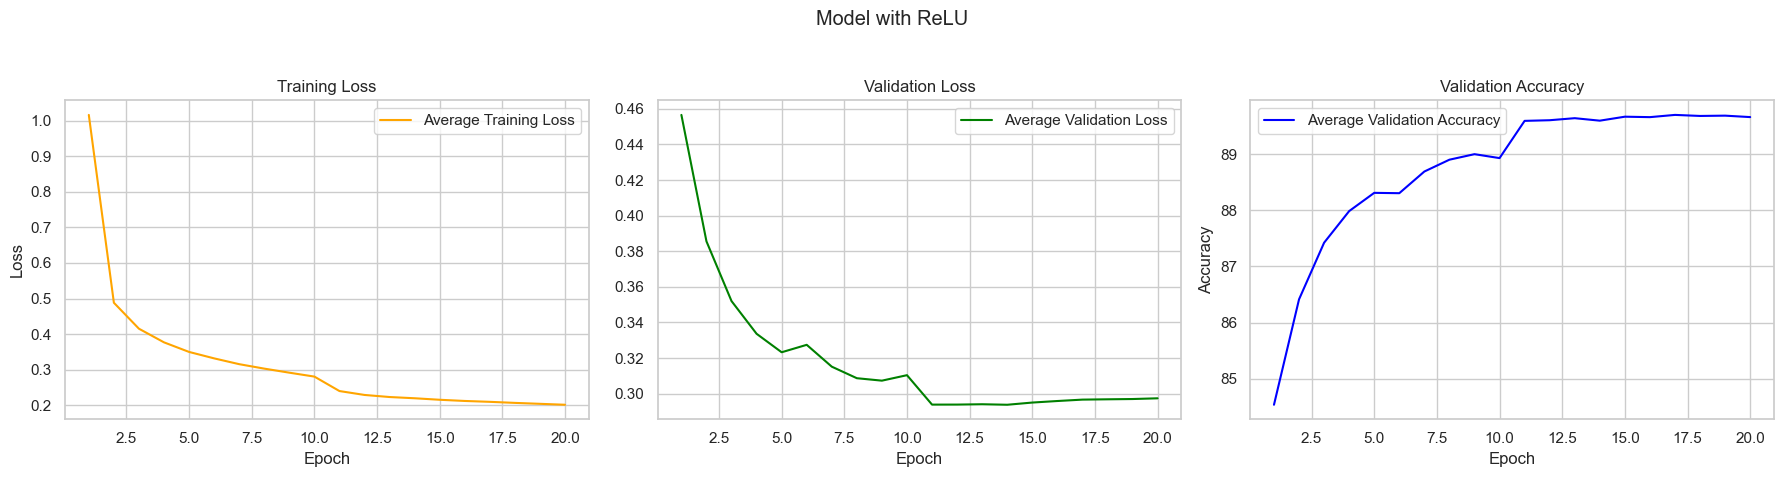

Model with ReLU - Final Average Training Loss: 0.201
Model with ReLU - Final Average Validation Loss: 0.297
Model with ReLU - Final Average Validation Accuracy: 89.66%


 ################################ 


Running cross-validation with LeakyReLU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


Train time on cuda: 68.704 seconds
Fold 1 completed. Validation accuracy: 89.87

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.45s/it]


Train time on cuda: 69.003 seconds
Fold 2 completed. Validation accuracy: 89.66

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train time on cuda: 68.815 seconds
Fold 3 completed. Validation accuracy: 89.83

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train time on cuda: 68.792 seconds
Fold 4 completed. Validation accuracy: 89.86

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train time on cuda: 68.854 seconds
Fold 5 completed. Validation accuracy: 89.75



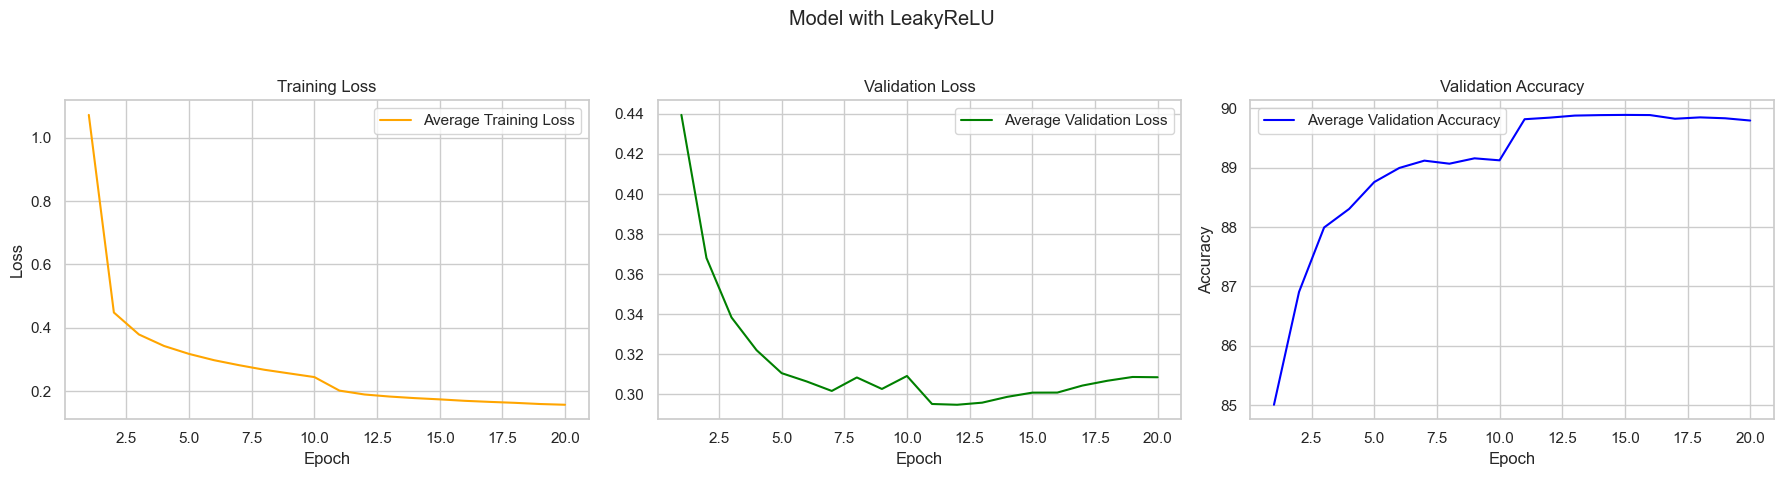

Model with LeakyReLU - Final Average Training Loss: 0.157
Model with LeakyReLU - Final Average Validation Loss: 0.309
Model with LeakyReLU - Final Average Validation Accuracy: 89.79%


 ################################ 


Running cross-validation with ELU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train time on cuda: 68.801 seconds
Fold 1 completed. Validation accuracy: 89.45

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train time on cuda: 68.768 seconds
Fold 2 completed. Validation accuracy: 88.99

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.43s/it]


Train time on cuda: 68.691 seconds
Fold 3 completed. Validation accuracy: 88.98

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train time on cuda: 68.768 seconds
Fold 4 completed. Validation accuracy: 89.19

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


Train time on cuda: 68.821 seconds
Fold 5 completed. Validation accuracy: 89.06



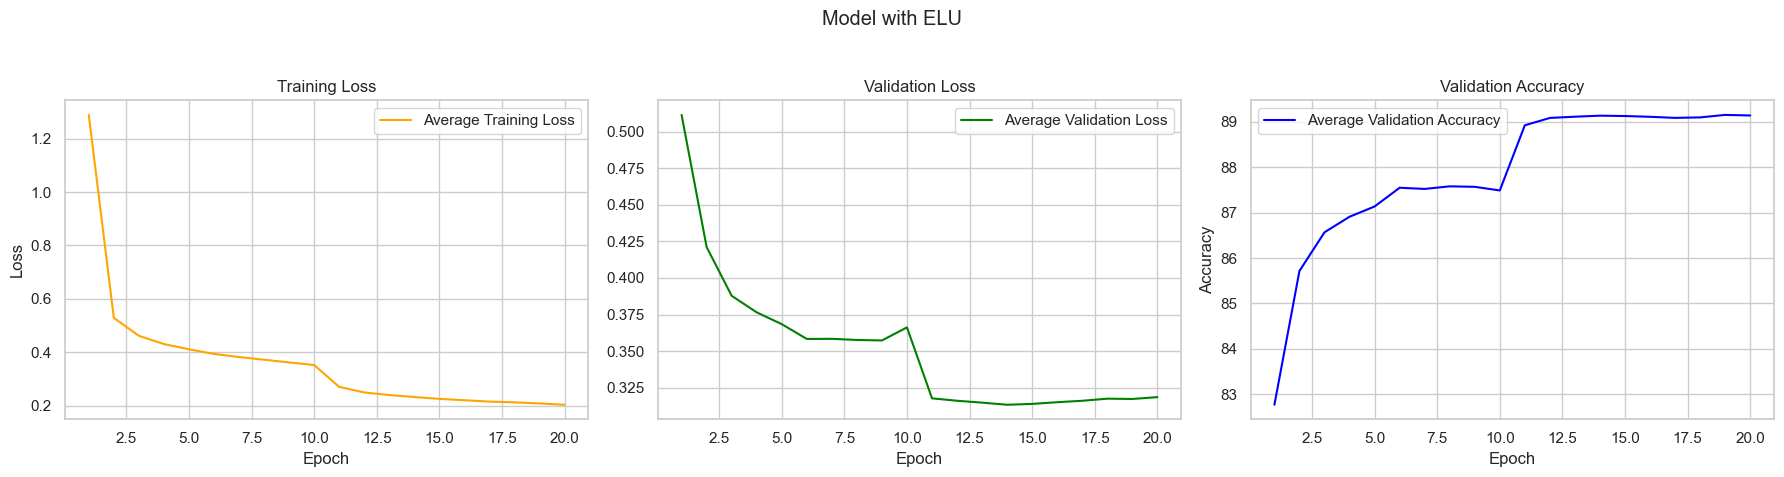

Model with ELU - Final Average Training Loss: 0.203
Model with ELU - Final Average Validation Loss: 0.318
Model with ELU - Final Average Validation Accuracy: 89.13%


 ################################ 




In [182]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.RMSprop(params, lr=0.001)  # Best optimizer from previous experiment.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

activation_metrics_list = []

for activation_name, activation_fn in activation_functions.items():
    print(f"Running cross-validation with {activation_name} activation function.")

    # Get a model constructor for the current activation function
    model_constructor = get_model_constructor(activation_fn)

    # Perform stratified k-fold cross-validation
    fold_results = stratified_k_fold_cross_validation(
        dataset=train_dataset,
        n_splits=5,
        model_constructor=model_constructor,
        setup_optimizer_scheduler=setup_optimizer_scheduler,
        epochs=20,
        device=device
    )

    # Plot the results
    plot_fold_results(fold_results, f"Model with {activation_name}")

    # Calculate summary statistics
    avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
    avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
    avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

    # Append metrics to metrics list
    activation_metrics_list.append({
        'Activation Function': activation_name,
        'Average Final Training Loss': avg_final_train_loss,
        'Average Final Validation Loss': avg_final_val_loss,
        'Average Final Validation Accuracy': avg_final_val_accuracy
    })


In [183]:
# Convert the list of dictionaries to a DataFrame
activation_metrics_df = pd.DataFrame(activation_metrics_list)

# Sort the DataFrame by 'Average Final Validation Accuracy'
sorted_activation_metrics_df = activation_metrics_df.sort_values('Average Final Validation Accuracy', ascending=False)

# Display the sorted DataFrame
display(sorted_activation_metrics_df)

Activation Function  Average Final Training Loss  \
1           LeakyReLU                     0.157415   
0                ReLU                     0.201497   
2                 ELU                     0.202783   

   Average Final Validation Loss  Average Final Validation Accuracy  
1                       0.308605                          89.794326  
0                       0.297377                          89.664007  
2                       0.318483                          89.134752

In [ ]:
#leaky relu performs best

In [184]:
#BATCH NORMALISATION

In [185]:
class FourLayerCNN(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, use_dropout=True, activation_fn=F.relu):
        super(FourLayerCNN, self).__init__()
        self.activation_fn = activation_fn

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # Input size (1, 28, 28)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (32, 14, 14)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (64, 7, 7)

        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) if use_bn else nn.Identity()

        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128) if use_bn else nn.Identity()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (128, 3, 3)

        # Define the output layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc = nn.Linear(128 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.pool1(self.activation_fn(self.bn1(self.conv1(x))))
        x = self.pool2(self.activation_fn(self.bn2(self.conv2(x))))
        x = self.activation_fn(self.bn3(self.conv3(x)))
        x = self.pool4(self.activation_fn(self.bn4(self.conv4(x))))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [186]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return FourLayerCNN(use_bn = True,activation_fn= F.leaky_relu) #best performing activation function
    return model_constructor

Running cross-validation with Batch normalisation on current best model
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.40s/it]


Train time on cuda: 87.942 seconds
Fold 1 completed. Validation accuracy: 89.43

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


Train time on cuda: 87.585 seconds
Fold 2 completed. Validation accuracy: 89.10

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


Train time on cuda: 87.720 seconds
Fold 3 completed. Validation accuracy: 89.32

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


Train time on cuda: 87.836 seconds
Fold 4 completed. Validation accuracy: 89.40

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


Train time on cuda: 87.779 seconds
Fold 5 completed. Validation accuracy: 89.34



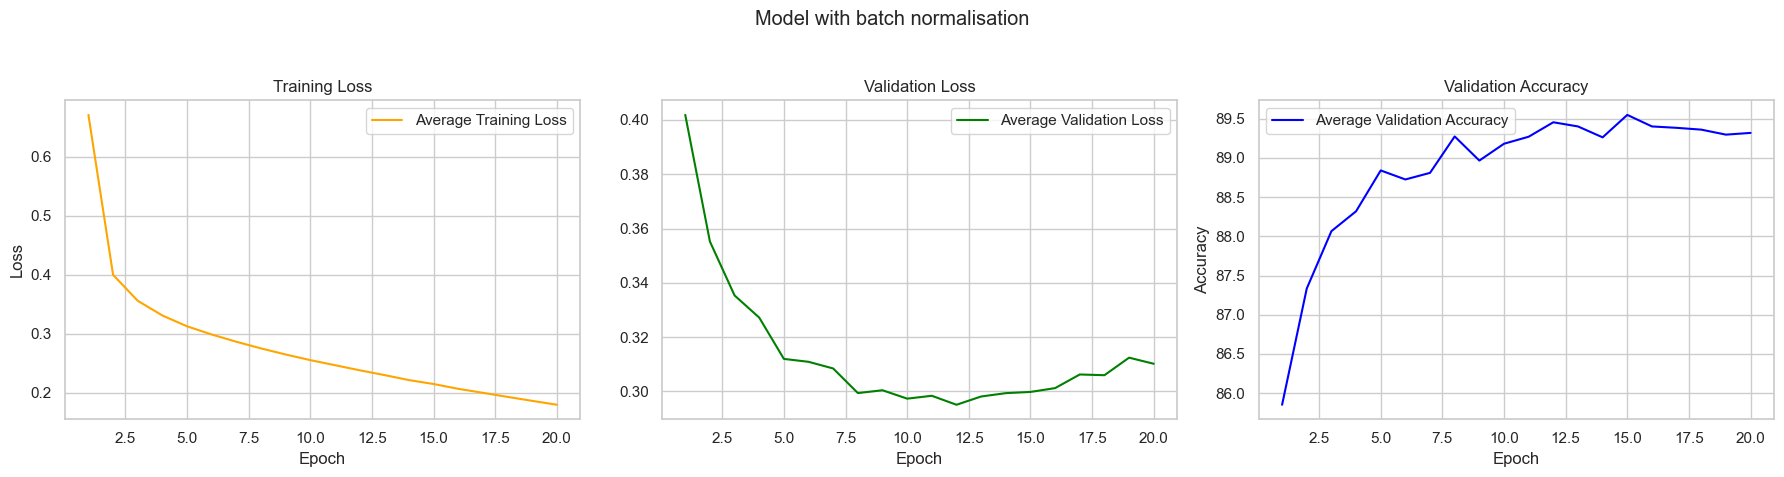

Model with batch normalisation - Final Average Training Loss: 0.180
Model with batch normalisation - Final Average Validation Loss: 0.310
Model with batch normalisation - Final Average Validation Accuracy: 89.32%


 ################################ 




In [187]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001)  # Best optimizer from previous experiment.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

BN_metrics_list = []


print(f"Running cross-validation with Batch normalisation on current best model")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with batch normalisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
BN_metrics_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

In [ ]:
#with BN performs slightly better

In [ ]:
#L1 & L2 regularisation 

In [188]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return FourLayerCNN(use_bn = True,activation_fn= F.leaky_relu) #best performing activation function
    return model_constructor

Running cross-validation with best model using L2 regularisation
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:29<00:00,  4.49s/it]


Train time on cuda: 89.816 seconds
Fold 1 completed. Validation accuracy: 89.86

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:29<00:00,  4.49s/it]


Train time on cuda: 89.805 seconds
Fold 2 completed. Validation accuracy: 89.04

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:29<00:00,  4.50s/it]


Train time on cuda: 89.916 seconds
Fold 3 completed. Validation accuracy: 89.36

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:30<00:00,  4.52s/it]


Train time on cuda: 90.395 seconds
Fold 4 completed. Validation accuracy: 89.35

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:30<00:00,  4.52s/it]


Train time on cuda: 90.438 seconds
Fold 5 completed. Validation accuracy: 89.59



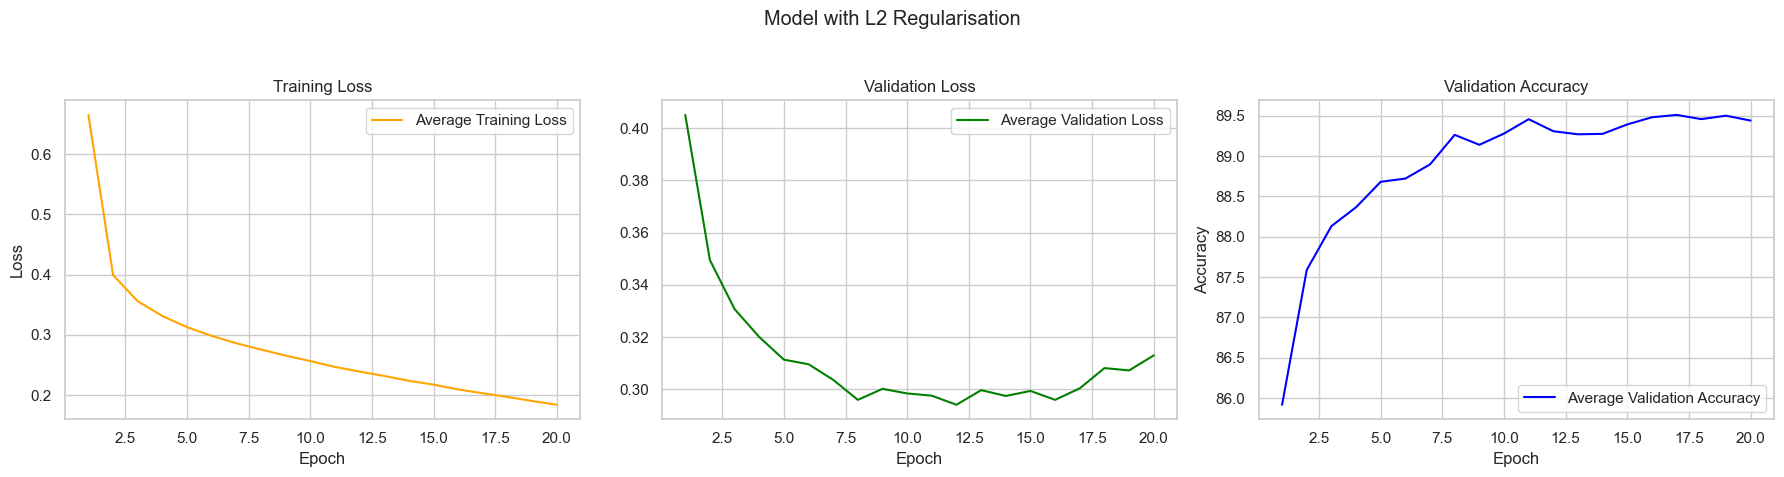

Model with L2 Regularisation - Final Average Training Loss: 0.184
Model with L2 Regularisation - Final Average Validation Loss: 0.313
Model with L2 Regularisation - Final Average Validation Accuracy: 89.44%


 ################################ 




In [189]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=1e-5)  # implementing l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []


print(f"Running cross-validation with best model using L2 regularisation")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with L2 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

In [ ]:
#L1 Regularisation

In [190]:
from tqdm import tqdm
import torch
from torch import no_grad
from torch.nn import functional as F

def train_and_validate_model_with_l1(train_loader, val_loader, model, optimizer, scheduler, epochs, device, lambda_l1):
    """
    Trains and validates the model using the given data loaders, optimizer, scheduler, and number of epochs, including L1 regularization.
    
    Parameters:
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - model: The neural network model to train.
    - optimizer: The optimizer to use for training.
    - scheduler: The scheduler to use for training.
    - epochs: Number of epochs to train for.
    - device: The device (CPU or GPU) to use for training and evaluation.
    - lambda_l1: L1 regularization strength.
    
    Returns:
    - A tuple containing the average training loss, average validation loss, and average validation accuracy.
    """
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)

            # Compute the L1 loss (regularization) term
            l1_norm = sum(p.abs().sum() for p in model.parameters())

            # Combine the cross-entropy loss and L1 regularization
            loss += lambda_l1 * l1_norm

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = F.cross_entropy(y_pred, y)

                val_loss += loss.item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

In [191]:
def stratified_k_fold_cross_validation_with_l1(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device, l1):
    """
    Performs stratified k-fold cross-validation for the given dataset, model, and includes L1 regularization.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - setup_optimizer_scheduler: Function that takes a model's parameters and returns a tuple of optimizer and scheduler.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    - l1: L1 regularization strength.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Timer start
        fold_start_time = timer()

        # Splitting the dataset into training and validation subsets for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer, and scheduler for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model)

        # Training and validating the model with L1 regularization
        train_losses, val_losses, val_accuracies = train_and_validate_model_with_l1(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device, l1
        )

        # Timer end
        fold_end_time = timer()

        # Calculating fold training time
        fold_train_time = fold_end_time - fold_start_time

        # Collecting results for this fold
        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results

Running cross-validation with best model using L1 regularisation
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:38<00:00,  4.92s/it]


Fold 1 completed. Validation accuracy: 79.17

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:37<00:00,  4.90s/it]


Fold 2 completed. Validation accuracy: 77.19

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


Fold 3 completed. Validation accuracy: 77.86

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:38<00:00,  4.93s/it]


Fold 4 completed. Validation accuracy: 79.18

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:38<00:00,  4.92s/it]


Fold 5 completed. Validation accuracy: 78.24



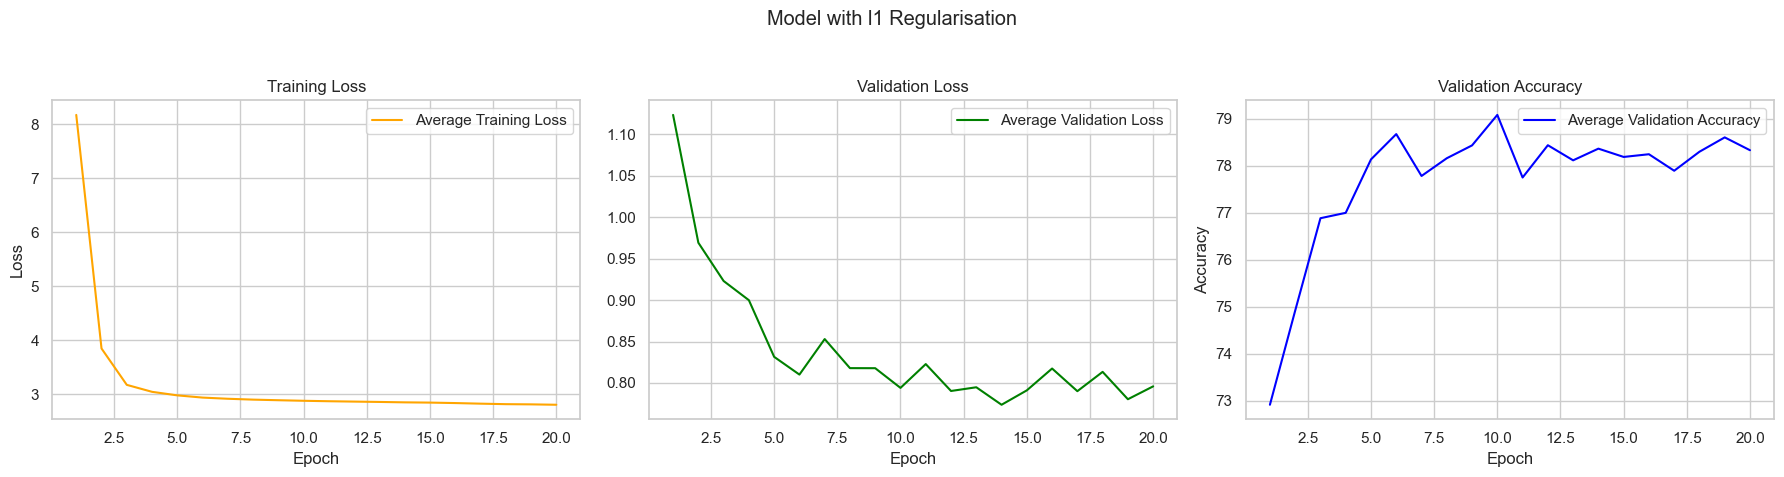

Model with l1 Regularisation - Final Average Training Loss: 2.808
Model with l1 Regularisation - Final Average Validation Loss: 0.796
Model with l1 Regularisation - Final Average Validation Accuracy: 78.33%


 ################################ 




In [192]:
def setup_optimizer_scheduler(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []


print(f"Running cross-validation with best model using L1 regularisation")

model_constructor = get_model_constructor(activation_fn)

# Assuming all other functions (cross-validation, plotting, etc.) are defined correctly
fold_results = stratified_k_fold_cross_validation_with_l1(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device,
    l1 = 0.01
)

    # Plot the results
plot_fold_results(fold_results, f"Model with l1 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

In [ ]:
# we will use with l2 reg

In [ ]:
# as the baseline has dropout = true, we will test if dropout is false : 

In [193]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return FourLayerCNN(use_bn = True,activation_fn= F.leaky_relu,use_dropout=False) #best performing activation function
    return model_constructor

Running cross-validation with best model using without dropout
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


Train time on cuda: 90.283 seconds
Fold 1 completed. Validation accuracy: 87.95

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:29<00:00,  4.49s/it]


Train time on cuda: 89.857 seconds
Fold 2 completed. Validation accuracy: 87.03

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


Train time on cuda: 90.122 seconds
Fold 3 completed. Validation accuracy: 87.95

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:30<00:00,  4.50s/it]


Train time on cuda: 90.027 seconds
Fold 4 completed. Validation accuracy: 87.74

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


Train time on cuda: 90.270 seconds
Fold 5 completed. Validation accuracy: 87.74



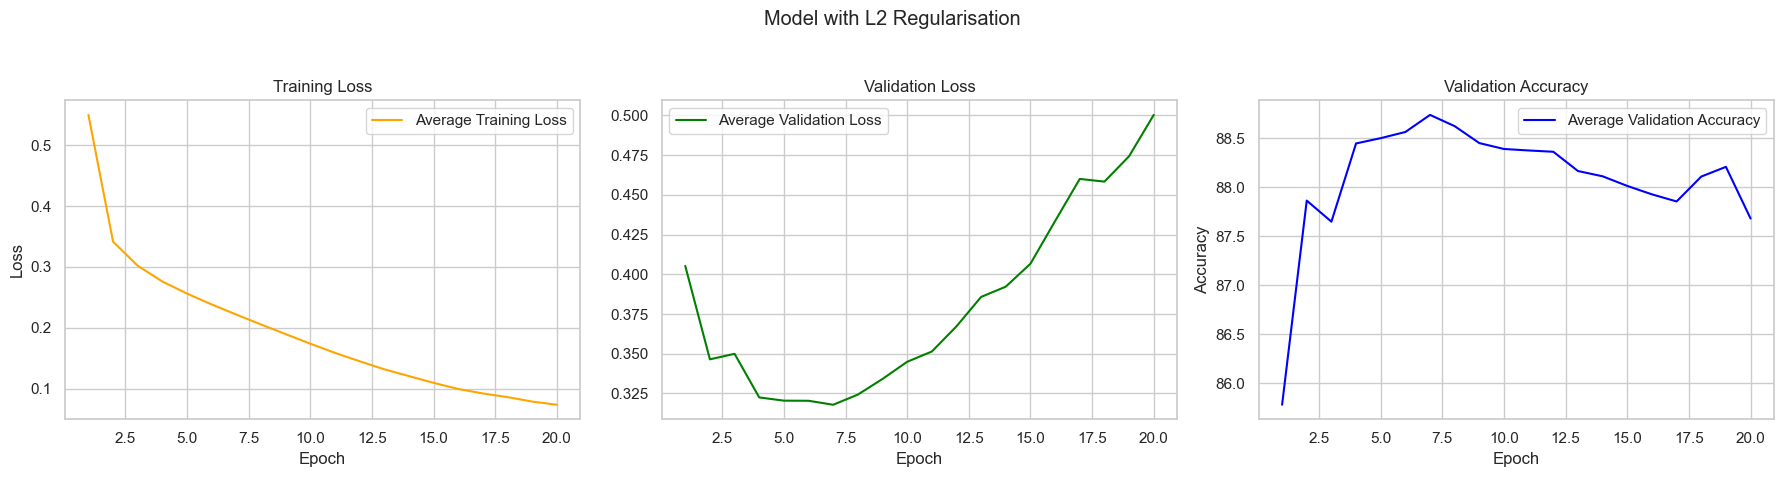

Model with L2 Regularisation - Final Average Training Loss: 0.073
Model with L2 Regularisation - Final Average Validation Loss: 0.500
Model with L2 Regularisation - Final Average Validation Accuracy: 87.68%


 ################################ 




In [194]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=1e-5)  # implementing l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []


print(f"Running cross-validation with best model using without dropout")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with L2 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

In [195]:
#best performing model on test dataset

In [196]:
def train_and_validate_model(train_loader, val_loader, model, optimizer, scheduler, epochs, device):
    import torch
    from torch import no_grad
    from torch.nn import functional as F
    from tqdm import tqdm
    import numpy as np

    train_losses = []
    val_losses = []
    val_accuracies = []
    all_preds = []
    all_labels = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        preds = []
        labels = []
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
                preds.extend(y_pred.argmax(1).tolist())
                labels.extend(y.tolist())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)
        all_preds.extend(preds)
        all_labels.extend(labels)

    return train_losses, val_losses, val_accuracies, all_preds, all_labels

In [197]:
import torch
from torch import no_grad
from torch.nn import functional as F
from tqdm import tqdm

def train_and_validate_model(train_loader, val_loader, model, optimizer, scheduler, epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Variables for storing sample predictions
    sample_preds = []
    sample_labels = []
    sample_images = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
                
                # Optionally collect data for visualization
                if epoch == epochs - 1:  # Collect on last epoch
                    predictions = y_pred.argmax(1)
                    sample_preds.extend(predictions.cpu().numpy())
                    sample_labels.extend(y.cpu().numpy())
                    sample_images.extend(X.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    # Return the usual metrics and the samples for visualization
    return train_losses, val_losses, val_accuracies, sample_images, sample_preds, sample_labels

In [198]:
# We also need to modify our k-fold cross validation function:
def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - setup_optimizer_scheduler:
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies, sample_images, sample_preds, sample_labels = train_and_validate_model(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device
        )

        # Plot the confusion matrix for the last fold or adjust to accumulate across folds
       # plot_confusion_matrix(all_labels, all_preds, num_classes=47)  # Adjust num_classes as needed
         # End timing here
        if fold == 5:
            # Load the mapping
            mapping_file_path = 'emnist-balanced-mapping.txt'
            label_char_mapping = load_label_mapping(mapping_file_path)
            plot_confusion_matrix(sample_labels, sample_preds, num_classes=47, label_char_mapping=label_char_mapping)
            # Display top six sample predictions
            print("Top six sample predictions:")
            #for i in range(6):
                #print(f"Image {i+1} - True label: {sample_labels[i]}, Predicted: {sample_preds[i]}")
            plot_sample_predictions(sample_images, sample_labels, sample_preds, label_char_mapping)

# Assume you have labels and preds from your validation phase
            #plot_confusion_matrix(all_labels, all_preds, num_classes=47, label_char_mapping=label_char_mapping)
    
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)

       # print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results

Running cross-validation with best model
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Train time on cuda: 14.893 seconds
Starting fold 2/5


Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Train time on cuda: 14.896 seconds
Starting fold 3/5


Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Train time on cuda: 14.921 seconds
Starting fold 4/5


Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Train time on cuda: 14.889 seconds
Starting fold 5/5


Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


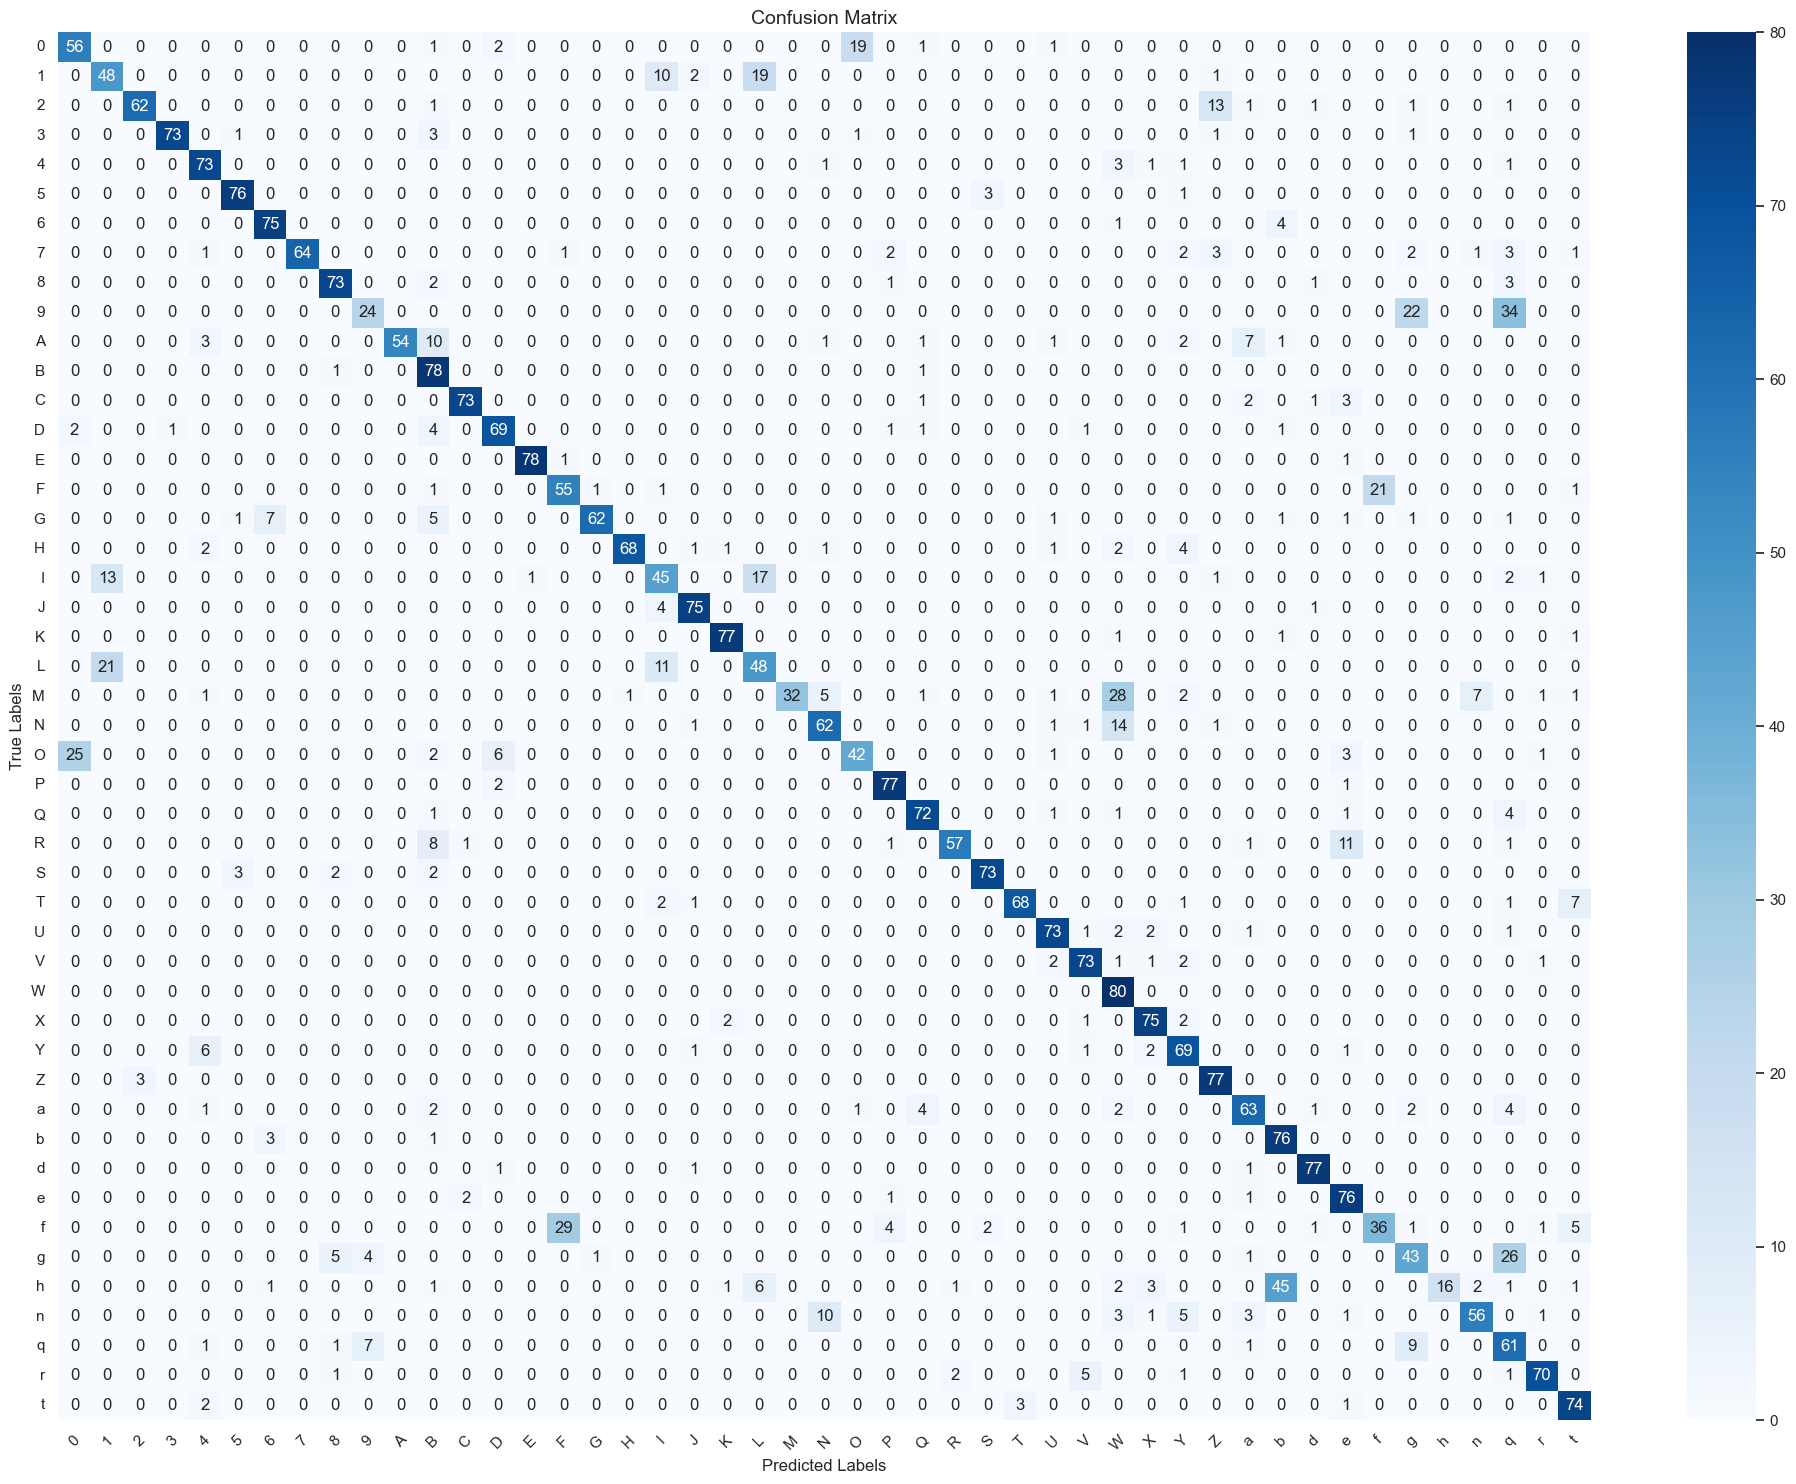

Top six sample predictions:


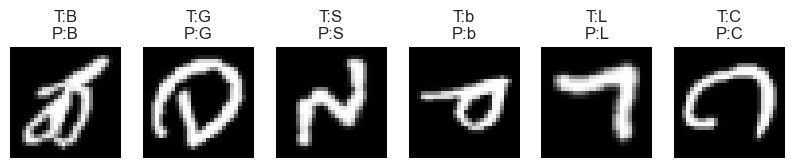

Train time on cuda: 17.849 seconds


In [199]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=1e-5)  # implementing l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []


print(f"Running cross-validation with best model")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=test_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)



    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})